# Original formulation of the problem:

From the original problem: 
$$
\begin{align}
\min_{x \in \mathcal{X}} \quad & f(x)  \\
\text{s.t.} \quad & P [g(x,\xi) \le 0] \geq p,
\end{align}
$$


There is an equivalent problem which is the sample average approximation of the problem that can be defined as follows:
$$
\begin{aligned}
\min_{x \in \mathcal{X}, \eta, y_1, \ldots, y_S} \quad & f(x) \\
\text{s.t.} \quad & \eta \le 0 \\
& g(x,\xi_{j}) - \eta \le M (1 - y_j), \quad j = 1, \ldots, S \\
& \frac{1}{S} \sum_{i=1}^{S} y_i \geq p, \\
& y_j \in \{0, 1\}, \quad j = 1, \ldots, S.
\end{aligned}
$$

We import the libraries and gurobi license:

In [79]:
#libraries 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
import time
import pandas as pd

#We import gurobi license and solver and ipopt solver
#Gurobi
import os
os.environ['GRB_LICENSE_FILE'] = r'C:\Users\laull\TFM\Gurobi\gurobi.lic'

opt = SolverFactory("gurobi")
opt.options["TimeLimit"] = 10800  # before 3600 secs. restriction (max. 3 hours)
opt.options["Seed"] = 10  # So that the results are reproducible

#Ipopt
opt2 = SolverFactory("ipopt")
opt2.options["max_wall_time"] = 10800    # 3600 secs. restriction

# Example 1

Let consider the problem
$$
\begin{align}
\min_{x_1,x_2} \quad & -x_1-x_2 \\
\text{s.t.} \quad & P [\xi_1 x_1 +(\xi_2+3) x_2-5 \le 0] \geq 0.8,
\end{align}
$$

where  $\xi_1 \sim N(1, \sigma = 0.2)$ and $\xi_1 \sim N(-2, \sigma= 0.1)$ .

Writing its equivalent average sample problem we would have to solve the next optimization problem:
$$
\begin{aligned}
\min_{x \in \textit{X}, \eta, y_1, \ldots, y_S} \quad & -x_1-x_2 \\
\text{s.t.} \quad & \eta \le 0 \\
& \xi_1 x_1 +(\xi_2+3) x_2-5 - \eta \le M (1 - y_j), \quad j = 1, \ldots, S \\
& \frac{1}{S} \sum_{i=1}^{S} y_i \geq 0.8, \\
& y_j \in \{0, 1\}, \quad j = 1, \ldots, S.
\end{aligned}
$$
where M is a large enough positive number.

We generate N scenarios. There would be two sets of generated data, for $N1=10$ and $N2 = 500$ scenarios:

In [80]:
#Data Example 1 10 scenarios 
np.random.seed(10)
N1= 10
N2 = 500
p1=0.8  #alpha

#Create the data. S is the number of scenarios studied
mean = [1, -2]  # means for xi1 and xi2
std_dev = [0.2, 0.1]  # sd for xi1 and xi2

#Data matirx: random normal distribution
data_matrix = np.column_stack((
    np.random.normal(mean[0], std_dev[0], N1),
    np.random.normal(mean[1], std_dev[1], N1)
))

data_matrix2 = np.column_stack((
    np.random.normal(mean[0], std_dev[0], N2),
    np.random.normal(mean[1], std_dev[1], N2) 
))

print("This is going to be the simulated scenarios for the first example:", data_matrix)

#Crate the vector of probabilities for each scenario and transform it into an np array
probabilities = [1/N1]*N1
probabilities = np.array(probabilities)

probabilities2 = [1/N2]*N2
probabilities2 = np.array(probabilities2)

Results={}


This is going to be the simulated scenarios for the first example: [[ 1.2663173  -1.95669738]
 [ 1.14305579 -1.87969626]
 [ 0.69091994 -2.09650657]
 [ 0.99832323 -1.89717259]
 [ 1.12426719 -1.97713699]
 [ 0.85598289 -1.95548624]
 [ 1.05310232 -2.11366022]
 [ 1.02170971 -1.98648631]
 [ 1.00085829 -1.8515463 ]
 [ 0.96507996 -2.10798049]]


We define the functions $f$ and $g$ that are going to be the inputs from my first example:

$$f_1 = -x_1 - x_2$$
$$g_1 = \xi_1 x_1 +(\xi_2+3) x_2-5   $$

In [81]:
#Problem functions
def g_1(x1, x2, xi):
    return xi[0] * x1 + (xi[1] + 3) * x2 - 5

def f_1(model):
    return -sum(model.x[i] for i in model.I)

We create the Average sample optimization problem in pyomo and solve it for this example:

In [82]:
def create_model1(M, N, p, simulated_data, g_function, f_function):
    model = ConcreteModel()

    # Sets
    model.J = RangeSet(0, N-1)  
    model.I = RangeSet(0, 1)   

    # Variables
    model.x = Var(model.I, within=NonNegativeReals)  
    model.y = Var(model.J, within=Binary)
    model.eta = Var(within=NonPositiveReals)  
    
    # **Objective function **
    model.Objective = Objective(rule=f_function, sense=minimize)

    # **g(x, ξ) Expression **
    def g_expr_rule(model, j):
        return g_function(model.x[0], model.x[1], simulated_data[j, :]) 
    model.g = Expression(model.J, rule=g_expr_rule)

    # ** Probability restriction for g**
    def prob_rule(model, j):
        return model.g[j] - model.eta <= M * (1 - model.y[j])  
    model.prob = Constraint(model.J, rule=prob_rule)

    # **Proportion restriction**
    def proportion_rule(model):
        return (1 / N) * sum(model.y[j] for j in model.J) >= p
    model.proportion = Constraint(rule=proportion_rule)

    return model

**Example 1:** Average sample using 10 scenarios

In [243]:
M=10
#Solve average sample for n=10
example1_p1_n10 = create_model1(M=M, N=N1, p=p1, simulated_data=data_matrix, g_function=g_1, f_function=f_1)

result = opt.solve(example1_p1_n10, tee=True)

# Show the results
print("Optimal Values of Variables for g_1:")
for i in example1_p1_n10.I:
    print(f"x[{i}] = {example1_p1_n10.x[i].value}")

print(f"eta = {example1_p1_n10.eta.value}")

for j in example1_p1_n10.J:
    print(f"y[{j}] = {example1_p1_n10.y[j].value}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpc02gxzvs.pyomo.lp
Reading time = 0.00 seconds
x1: 11 rows, 13 columns, 50 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 11 rows, 13 columns and 50 nonzeros
Model fingerprint: 0x599238c3
Variable types: 3 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+01]
Found heuristic solution: objective -

Let`s graph this problem:

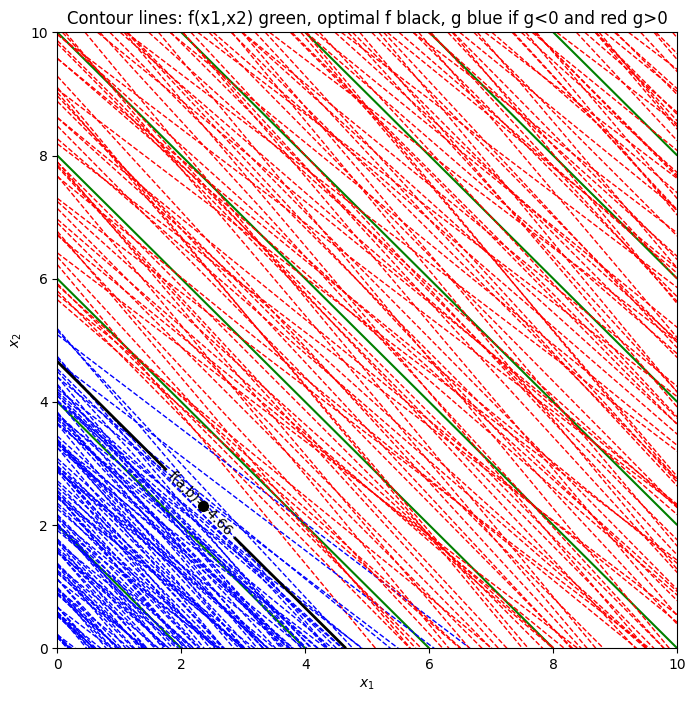

In [323]:
# Grid of 30 elements for (x1, x2) in [0, 10] 
x1 = np.linspace(0, 10, 40)
x2 = np.linspace(0, 10, 40)
X1, X2 = np.meshgrid(x1, x2)

# Initialize plot and axis 
fig, ax = plt.subplots(figsize=(8, 8))

# Plot contour lines for f (=-x1-x2)
f = -X1 - X2
ax.contour(X1, X2, f, levels=10, colors='green', linestyles='solid', linewidths=1.5)

# Plot contour lines for g(x1, x2, xi1, xi2)
for j in example1_p1_n10.J:
    
    g = g_1(X1, X2, data_matrix[j, :]) 

    # We separate positive (red) from negative values (blue)
    g_neg = np.ma.masked_where(g >= example1_p1_n10.eta.value, g)  # g < 0
    g_pos = np.ma.masked_where(g <= example1_p1_n10.eta.value, g)  # g > 0

    # Blue contour lines for g < 0
    ax.contour(X1, X2, g_neg, levels=15, colors='blue', linestyles='dashed', linewidths=1.0)

    # Red contour lines for g > 0
    ax.contour(X1, X2, g_pos, levels=15, colors='red', linestyles='dashed', linewidths=1.0)

# Optimal solution addings:
# Plot contour line on the optimal solution 
nivel_f = -example1_p1_n10.x[0].value - example1_p1_n10.x[1].value  

contour_f = ax.contour(X1, X2, f, levels=[nivel_f], colors='black', linestyles='solid', linewidths=2)
ax.clabel(contour_f, inline=True, fontsize=10, fmt=f'f(a,b)={nivel_f:.2f}')

#Plot the point:
ax.plot(example1_p1_n10.x[0].value, example1_p1_n10.x[1].value, 'ko', markersize = 7, label = "Sol.")


# Set axis 
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Contour lines: f(x1,x2) green, optimal f black, g blue if g<0 and red g>0")

plt.savefig("Contourlines_example1_n10.png")
plt.show()

**Example 1:** Average sample using 500 scenarios

In [286]:
M=10

#Define the model: average sample for n=500 simulations
example1_p1_n500 = create_model1(M=M, N=N2, p=p1, simulated_data=data_matrix2, g_function=g_1, f_function=f_1)

#Solve with gurobi
result = opt.solve(example1_p1_n500, tee=True)

# We s
print("Optimal Values of Variables for g_1:")
for i in example1_p1_n500.I:
    print(f"x[{i}] = {example1_p1_n500.x[i].value}")

print(f"eta = {example1_p1_n500.eta.value}")

for j in example1_p1_n500.J:
    print(f"y[{j}] = {example1_p1_n500.y[j].value}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmp23wips2j.pyomo.lp
Reading time = 0.00 seconds
x1: 501 rows, 503 columns, 2500 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 501 rows, 503 columns and 2500 nonzeros
Model fingerprint: 0x6737762a
Variable types: 3 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+01]
Found heuristic solution: o

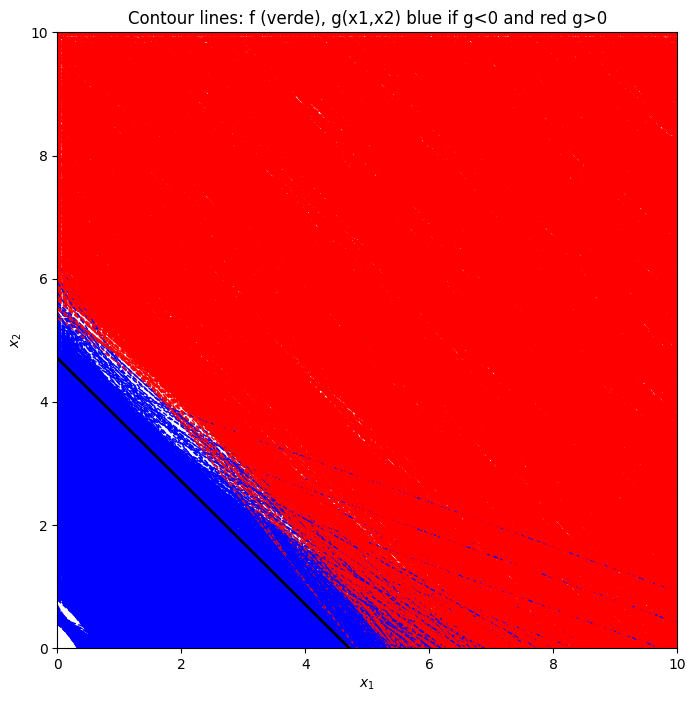

In [295]:
# Grid of 30 elements for (x1, x2) in [0, 500] 
x1 = np.linspace(0, 10, 30)
x2 = np.linspace(0, 10, 30)
X1, X2 = np.meshgrid(x1, x2)

# Initialize plot and axis 
fig, ax = plt.subplots(figsize=(8, 8))

# Plot contour lines for f (=-x1-x2)
f = -X1 - X2
ax.contour(X1, X2, f, levels=10, colors='green', linestyles='solid', linewidths=1.5)

# Plot contour lines for g(x1, x2, xi1, xi2)
for j in example1_p1_n500.J:
    
    g = g_1(X1, X2, data_matrix2[j, :]) 

    # We separate positive (red) from negative values (blue)
    g_neg = np.ma.masked_where(g >= example1_p1_n500.eta.value, g)  # g < 0
    g_pos = np.ma.masked_where(g <= example1_p1_n500.eta.value, g)  # g > 0

    # Blue contour lines for g < 0
    ax.contour(X1, X2, g_neg, levels=10, colors='blue', linestyles='dashed', linewidths=1.0)

    # Red contour lines for g > 0
    ax.contour(X1, X2, g_pos, levels=10, colors='red', linestyles='dashed', linewidths=1.0)

# Plot contour line on the optimal solution 
nivel_f = -example1_p1_n500.x[0].value - example1_p1_n500.x[1].value  

contour_f = ax.contour(X1, X2, f, levels=[nivel_f], colors='black', linestyles='solid', linewidths=2)
ax.clabel(contour_f, inline=True, fontsize=50, fmt=f'f(a,b)={nivel_f:.2f}')

# Set axis 
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Contour lines: f (verde), g(x1,x2) blue if g<0 and red g>0")

plt.savefig("Contourlines_example1.png")
plt.show()

## CVaR algorithm

This analogous problem has the next expression:

$$
\begin{align*}
\min_{x \in \mathcal{X}, \eta, v_1, ..., v_S} \quad & f(x)  \\
\text{s.t.} \quad & \eta + \frac{1}{1-p}\sum_{j=1}^S p_j v_j \le 0  \\
& v_j \geq g(x,\xi_j) - \eta, \quad j = 1,..., S  \\
& v_j \geq 0, \quad j = 1, ..., S, \
\end{align*}
$$

where $ \mathcal{P} [\xi = \xi_i] = p_i$ for all $ i \in \{1, \ldots, n\} $ and the left term of the constrain is going to be the CVaR of the problem, that is:
$$
\eta + \frac{1}{1-p}\sum_{j=1}^S p_j v_j
$$

In the example we are studying the problem is:
$$
\begin{align*}
\min_{x \in \mathcal{X}, \eta, v_1, ..., v_S} \quad & -x_{1} - x_{2}  \\
\text{s.t.} \quad & \eta + \frac{1}{1-p}\sum_{j=1}^S p_j v_j \le 0  \\
& v_j \geq \xi_1 x_1 +(\xi_2+3) x_2-5 - \eta, \quad j = 1,..., S  \\
& v_j \geq 0, \quad j = 1, ..., S. \
\end{align*}
$$
Therefore in this example $p_j = \mathcal{P} \left ( (\xi_1, \xi_2) = (\xi_{1_{j}}, \xi_{2_{j}}) \right ) $ where $\xi_1 \sim N(1, \sigma = 0.2)$ and $\xi_2 \sim N(-2, \sigma= 0.1)$ .


Before solving the problem, with the values of $\xi $ computed the first step would be computing this vectors of probabilities, we have that the probability of each scenario is $1/S$, been $S$ the number of scenarios studied in the problem.

In [83]:
def create_model4(p,matrix_xi, x_ini, v_ini, eta_ini, probs, N, g_function, f_function):
    
    model3 = ConcreteModel()

    # Sets
    model3.J = RangeSet(0, N-1)  
    model3.I = RangeSet(0,1)    
    
    # Variables
    model3.x = Var(model3.I, domain=NonNegativeReals, initialize=x_ini)  
    model3.v = Var(model3.J, domain=NonNegativeReals, initialize=v_ini)
    model3.eta = Var(domain=NonPositiveReals, initialize = eta_ini)

    # **Objective function**
    model3.Objective = Objective(rule=f_function, sense=minimize)  

    # **g(x, ξ) expression**
    def g_expr_rule(model3, j):
        return g_function(model3.x[0], model3.x[1], matrix_xi[j, :]) 
    model3.g = Expression(model3.J, rule=g_expr_rule)
    
    # Proportion prob
    def probs_rule(model3):
        return model3.eta + (1/(1-p))* sum(model3.v[j]*probs[j] for j in model3.J) <= 0
    model3.probs = Constraint(rule=probs_rule)

    # proportion defining v
    def vs_rule(model3, j):
        return model3.g[j] - model3.eta <= model3.v[j]
    model3.vs = Constraint(model3.J, rule=vs_rule)
    
    return model3

**Example 1:** CVaR, 10 scenarios

In [324]:
example1_p4_n10 = create_model4(p= p1,matrix_xi= data_matrix, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities, N=N1, g_function=g_1, f_function= f_1)


result = opt.solve(example1_p4_n10, tee=True)

# Print the results
print("Optimal Values of Variables for g_1:")
for i in example1_p4_n10.I:
    print(f"x[{i}] = {example1_p4_n10.x[i].value}")

print(f"eta = {example1_p4_n10.eta.value}")

Example1_n10_CVaR = example1_p4_n10.eta.value 
for j in example1_p4_n10.J:
    Example1_n10_CVaR = Example1_n10_CVaR + (1/ (1-p1))*(probabilities[j] * example1_p4_n10.v[j].value)

print(f"The Cvar for this example is = {Example1_n10_CVaR}")


Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpho4smx2n.pyomo.lp
Reading time = 0.00 seconds
x1: 11 rows, 13 columns, 51 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 11 rows, 13 columns and 51 nonzeros
Model fingerprint: 0x684c989a
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+00]
Presolve time: 0.00s
Presolved: 11 rows, 13 columns, 51 nonzeros

Iteration    Objective  

**Example 1:** CVaR, 500 scenarios

In [325]:
#Solve it
example1_p4_n500 = create_model4(p = p1,matrix_xi= data_matrix2, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities2, N=N2, g_function=g_1, f_function= f_1)


result = opt.solve(example1_p4_n500, tee=True)

# Print the results
print("Optimal Values of Variables for g_1:")
for i in example1_p4_n500.I:
    print(f"x[{i}] = {example1_p4_n500.x[i].value}")

print(f"eta = {example1_p4_n500.eta.value}")

Example1_n500_CVaR = example1_p4_n500.eta.value 
for j in example1_p4_n500.J:
    Example1_n500_CVaR = Example1_n500_CVaR + (1/ (1-p1))*(probabilities2[j] * example1_p4_n500.v[j].value)

print(f"The Cvar for this example is = {Example1_n500_CVaR}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpxmrwu_6w.pyomo.lp
Reading time = 0.01 seconds
x1: 501 rows, 503 columns, 2501 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 501 rows, 503 columns and 2501 nonzeros
Model fingerprint: 0x37899f49
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+00]
Presolve time: 0.01s
Presolved: 501 rows, 503 columns, 2501 nonzeros

Iteration   

## Alternative bi-level formulation

A new faster alternative to solve this example would be using this equivalent formulation:
$$
\begin{align*}
\min_{x \in {\mathcal X},\eta, v_1,...,v_S,\pi_1,...,\pi_S } \quad & f(x)  \\
\text{s.t.} \quad &  \eta \le 0  \\
&  p\sum_{j=1}^S u_j+ (1-p)\sum_{j=1}^S  v_j  \leq \sum_{j=1}^S \pi_j g(x,\xi_j)  \\
& u_j - v_j = g(x,\xi_j)  - \eta,\; j=1,...,S, \\
& u_j , v_j \ge 0,\; j=1,...,S\\
&\sum_{j=1}^S \pi_j = 0, \quad \pi_j \in [-(1-p), p], \quad j = 1, ..., S,
\end{align*}
$$
which for our problem the formulation would be like this:

$$
\begin{align*}
\min_{x \in {\mathcal X},\eta, v_1,...,v_S,\pi_1,...,\pi_S } \quad & -x_{1}-x_2  \\
\text{s.t.} \quad &  \eta \le 0  \\
&  p\sum_{j=1}^S u_j+ (1-p)\sum_{j=1}^S  v_j  \leq \sum_{j=1}^S \pi_j ( \xi_1 x_1 +(\xi_2+3) x_2-5)  \\
& u_j - v_j = g(x,\xi_j)  - \eta,\; j=1,...,S, \\
& u_j , v_j \ge 0,\; j=1,...,S\\
&\sum_{j=1}^S \pi_j = 0, \quad \pi_j \in [-(1-p), p], \quad j = 1, ..., S.
\end{align*},
$$

A function to compute the initial values for the problem given an initial solution is created. 
The function is called initialize values and its inputs are:
- **the variables x1,x2:** usually are solutions from previous problems
- **sim_matrix:** the simulation matrix with the scenarios
- **p:** the probability p from the restriction of the problem
- **N:** the number of simulated scenarios  
- **g:** the function g to compute the weights

In [84]:
def initialize_values(x1, x2, sim_matrix, p, N, g):
    
    #Given (x1,x2) initialization values a vector with the values of g(x1,x2, xi_n) is computed
    g_ini = np.array([g(x1, x2, sim_matrix[j, :]) for j in range(N)])
    
    # The Index J is computed
    J = next(j for j in range(1, N + 1) if (j / N) >= p)

    # The index of g sorted from lower values to larger of g(x1, x2, xi_n)
    sigma = np.argsort(g_ini)  

    # The vector of pi+s is created 
    pi_ini = np.zeros(N)
    for j in range(N):
        k = j + 1
        if k < J:  # Caso 1
            pi_ini[sigma[j]] = -(1 - p)
        elif k == J:  # Caso 2
            pi_ini[sigma[j]] = (J-1) * (1 - p) - (N - J) * p
        else:  # Caso 3
            pi_ini[sigma[j]] = p

    #We sort g based on its values and compute the sample quantile, which will be eta
    sorted_gini = np.sort(g_ini)
    n_lower = int(p * N)  #Quantile
    eta = sorted_gini[n_lower - 1]

    # u y v are computed from the variables x1 and x2
    u_ini = np.empty(N)
    v_ini = np.empty(N)

    for j in range(N):
        if g_ini[j] >= eta:
            u_ini[j] = g_ini[j] - eta
            v_ini[j] = 0
        else:
            v_ini[j] = -(g_ini[j] - eta)
            u_ini[j] = 0

    return {
        "g_ini": g_ini,
        "eta_ini": eta,
        "J": J,
        "pi_ini": pi_ini,
        "u_ini": u_ini,
        "v_ini": v_ini
    }

The bilevel algorithm model is defined:

In [85]:
def create_model3(p,matrix_xi, x_ini, u_ini, v_ini, pi_ini, eta_ini, N, g_function, f_function):
    
    model = ConcreteModel()

    # Sets
    model.J = RangeSet(0, N-1)  
    model.I = RangeSet(0,1)    
    
    # Variables
    model.x = Var(model.I, domain=NonNegativeReals, initialize=x_ini)  
    model.u = Var(model.J, domain=NonNegativeReals, initialize= u_ini)
    model.v = Var(model.J, domain=NonNegativeReals, initialize=v_ini)
    model.pi = Var(model.J, bounds=(-(1 - p), p), initialize = pi_ini)
    model.eta = Var(domain=NonPositiveReals, initialize = eta_ini)
    
    # **g(x, ξ) expression**
    def g_expr_rule(model, j):
        return g_function(model.x[0], model.x[1], matrix_xi[j, :]) 
    model.g = Expression(model.J, rule=g_expr_rule)

    # *Objective function**
    model.Objective = Objective(rule=f_function, sense=minimize)

    #Restrictions: 
    # weights pi sum cero 
    def pesos_rule(model):
        return sum(model.pi[j] for j in model.J) == 0
    model.pesos = Constraint(rule=pesos_rule)

    # Define u,v  = g - eta 
    def cuantil_rule(model, j):
        return model.g[j] - model.eta == model.u[j] - model.v[j]
    model.cuantil = Constraint(model.J, rule=cuantil_rule)

    # Proportion constraint
    def combinacion_rule(model):
        return p*(sum(model.u[j] for j in model.J) ) + (1-p)*(sum(model.v[j] for j in model.J) ) <= (sum(model.pi[j] * model.g[j]  for j in model.J) )
    model.combinacion = Constraint(rule=combinacion_rule)  
    
    return model

**Example 1:** Bilevel algorithm using 10 scenarios, inicialization values $(x1, x2) = (1,3)$ 

In [327]:
#n =10, initial values: x1= 1 y x2 = 3 

resultado = initialize_values(x1= 2, x2=4, sim_matrix=data_matrix, p=p1, N=N1, g=g_1)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))


x_ini_dict = {0: 2, 1: 4}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve it
example1_p3_n10 = create_model3(p = p1, matrix_xi = data_matrix, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini = eta_ini, N = N1, g_function = g_1, f_function = f_1)


result = opt2.solve(example1_p3_n10, tee=True)

# Print the results
print("Optimal Values of Variables for f_1:")
for i in example1_p3_n10.I:
    print(f"x[{i}] = {example1_p3_n10.x[i].value}")

print(f"eta = {example1_p3_n10.eta.value}")

0.0
WARNING (W1002): Setting Var 'pi[8]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `1.5955313731082459` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: max_wall_time=10800


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:       3

**Example 1:** Bilevel algorithm using 10 scenarios, inicialization values $(x1, x2) =$ CVaR

In [328]:
#n =10, initial values CVaR

resultado = initialize_values(x1= example1_p4_n10.x[0].value, x2=example1_p4_n10.x[0].value, sim_matrix=data_matrix, p=p1, N=N1, g=g_1)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))


x_ini_dict = {0: example1_p4_n10.x[0].value, 1: example1_p4_n10.x[0].value}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))} 
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve it
example1_p3_n10 = create_model3(p = p1, matrix_xi = data_matrix, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini = eta_ini, N = N1, g_function = g_1, f_function = f_1)


result = opt2.solve(example1_p3_n10, tee=True)

# Print the results
print("Optimal Values of Variables for f_1:")
for i in example1_p3_n10.I:
    print(f"x[{i}] = {example1_p3_n10.x[i].value}")

print(f"eta = {example1_p3_n10.eta.value}")

0.0
WARNING (W1002): Setting Var 'pi[8]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


Ipopt 3.14.16: max_wall_time=10800


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:       32
Number of nonzeros in Lagrangian Hessian.............:       20

Total number of variables............................:       33
                     variables with only lower bounds:       22
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        1
Total number of equality constraints.................:  

**Example 1:** Bilevel algorithm using 500 scenarios, inicialization values $(x1, x2) = (1,3)$ 

Previous to solve with the bilevel approach, we verify if the values of $g(x,\xi)$ on the initial values are repeated or not. They are not repeated so we can proceed with the algorithm:

In [329]:
#We see if in the average sample there are g's that are the same:

values_g_1_bilevel = np.array([ g_1(1, 3, data_matrix2[j,:]) for j in range(N2)])

for i in range(N2):
    for k in range(N2):
        if i>k and values_g_1_bilevel[i]==values_g_1_bilevel[k]:
            print(f" For scenarios {i} and {k} g_1 on the bilevel function outputs the same result")

In [330]:
#n =500, initial values: x1= 1 y x2 = 3 

resultado = initialize_values(x1= 1, x2=3, sim_matrix=data_matrix2, p=p1, N=N2, g=g_1)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))


x_ini_dict = {0: 1, 1: 3}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve it
example1_p3_n500 = create_model3(p = p1, matrix_xi = data_matrix2, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini = eta_ini, N = N2, g_function = g_1, f_function = f_1)


result = opt2.solve(example1_p3_n500, tee=True)

# Print the results
print("Optimal Values of Variables for f_1:")
for i in example1_p3_n500.I:
    print(f"x[{i}] = {example1_p3_n500.x[i].value}")

print(f"eta = {example1_p3_n500.eta.value}")

-2.90878432451791e-14
WARNING (W1002): Setting Var 'pi[286]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.16: max_wall_time=10800


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3000
Number of nonzeros in inequality constraint Jacobian.:     1502
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:     1503
                     variab

**Example 1:** Bilevel algorithm using 500 scenarios, inicialization values: solutions from the average sample $(x1, x2) \cdot 0.8$ 

Previous to solve with the bilevel approach, we verify if the values of $g(x,\xi)$ on the initial values are repeated or not. They are not repeated so we can proceed with the algorithm:

In [68]:
#We see if in the average sample there are g's that are the same:
values_g_1_bilevel = np.array([ g_1(example1_p1_n500.x[0].value, example1_p1_n500.x[1].value, data_matrix2[j,:]) for j in range(N2)])

for i in range(N2):
    for k in range(N2):
        if i>k and values_g_1_bilevel[i]==values_g_1_bilevel[k]:
            print(f" For scenarios {i} and {k} g_1 on the bilevel function outputs the same result")

 For scenarios 483 and 129 g_1 on the bilevel function outputs the same result


Therefore we cannot use the average sample values as initial values for x1 and x2 since the weights won't be assigned correctly.

**Example 1:** Bilevel algorithm using 500 scenarios, inicialization values: solutions from the CVaR $(x1, x2)$ 

In [69]:
x1_ini = example1_p4_n500.x[0].value
x2_ini = example1_p4_n500.x[1].value

values_g_1_bilevel = np.array([ g_1(x1_ini, x2_ini, data_matrix2[j,:]) for j in range(N2)])

for i in range(N2):
    for k in range(N2):
        if i>k and values_g_1_bilevel[i]==values_g_1_bilevel[k]:
            print(f" For scenarios {i} and {k} g_1 on the bilevel function outputs the same result")

In [331]:
x1_ini = example1_p4_n500.x[0].value
x2_ini = example1_p4_n500.x[1].value


resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix2, p=p1, N=N2, g=g_1)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))


x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))} 
eta_ini = resultado["eta_ini"] 

#Solve it
example1_p3_n500 = create_model3(p = p1, matrix_xi = data_matrix2, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini = eta_ini, N = N2, g_function = g_1, f_function = f_1)


result = opt2.solve(example1_p3_n500, tee=True)

# Print the results
print("Optimal Values of Variables for g_1:")
for i in example1_p3_n500.I:
    print(f"x[{i}] = {example1_p3_n500.x[i].value}")

print(f"eta = {example1_p3_n500.eta.value}")

-1.2434497875801753e-14
WARNING (W1002): Setting Var 'pi[323]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.16: max_wall_time=10800


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3000
Number of nonzeros in inequality constraint Jacobian.:     1502
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:     1503
                     vari

## Bi-level iterative algorithm

In this iterative process we should solve this new master program (MP):

$$
\begin{align*}
\min_{x \in {\cal X},\eta, v_1,...,v_S} \quad & f(x)+M\theta  \\
\text{s.t.} \quad &  \eta \le 0\notag \\
&    p\sum_{j=1}^S u_j+ (1-p)\sum_{j=1}^S  v_j  \leq \sum_{j=1}^S \bar{\pi}_{j}^{k} g(x,\xi_j) +\theta;   \\
& u_j-v_j = g(x,\xi_j)  - \eta,\; j=1,...,S, \\
& u_j,v_j \ge 0,\; j=1,...,S
\end{align*}
$$
where M is a big constant.

For this section I am going to use a concretemodel and every iteration I am going to change the inputs. Instead of doing an abstract one an create a .dat every iteration, which seems to be more time-consuming. 

In [86]:
def create_model5(M, p, pi, N, sim_matrix, x_ini, u_ini, v_ini, eta_ini, g_function, f_function):
    # Concrete model
    model4 = ConcreteModel()

    # Conjuntos
    model4.J = RangeSet(0, N-1)
    model4.I = RangeSet(0,1)

    # Variables
    model4.x = Var(model4.I, domain=NonNegativeReals, initialize=x_ini)  
    model4.v = Var(model4.J, domain=NonNegativeReals, initialize=v_ini)
    model4.u = Var(model4.J, domain=NonNegativeReals, initialize=u_ini)
    model4.eta = Var(domain=NonPositiveReals, initialize=eta_ini)
    model4.theta = Var(domain=NonNegativeReals)

    #Objective function
    def objective_rule(model4):
        return f_function(model4) + M * model4.theta
    model4.Objective = Objective(rule=objective_rule, sense=minimize)

    # **g(x, ξ) expression**
    def g_expr_rule(model4, j):
        return g_function(model4.x[0], model4.x[1], sim_matrix[j, :]) 
    model4.g = Expression(model4.J, rule=g_expr_rule)
    
    # u,v restriction
    def cuantil_rule(model4, j):
        return model4.g[j]- model4.eta == model4.u[j] - model4.v[j]
    model4.cuantil = Constraint(model4.J, rule=cuantil_rule)       
    
    #Proportion and weights
    def slack_rule(model4):
        return p * sum(model4.u[j] for j in model4.J) + (1 - p) * sum(model4.v[j] for j in model4.J)  <= \
            sum(pi[j] * model4.g[j] for j in model4.J) + model4.theta
    model4.slack = Constraint(rule=slack_rule)

    return model4


Now I compute the iterative algorithm to solve this problem. The following functions are defined:

- `bilevel_iteration_loop:`this loop iterates over the bilevel algorithm with weights pi defined previously until the criteria for convergence is hold. The inputs are:
    - **Max_iterations:** 
    - **Tolerance:** defined to compare the weights $pi_k$ and $p_{k+1}$
    - **M:** 
    - **p:** the probability coefficient for the restriction
    - **matrix_xi:** the simulated data for each scenario
    - **num_scen:** The number of scenarios used
    - **x1_v0, x2_v0:** intialization values
    - **g:** restriction function from the problem
    - **f:** objective function

Also the function `vectors_equal_with_tolerance`is created to compare if two vectors are equal given a tolerance. 

In [87]:
#Parameters 
tolerance = 1e-5
max_iterations = 20
M = 100

#La función para comparar los vectores pi en cada iteración con los anteriores

def vectors_equal_with_tolerance(v1, v2, tol):
    return all(abs(a - b) < tol for a, b in zip(v1, v2))

In [88]:
def bilevel_iteration_loop(max_iterations, tolerance,M, p, matrix_xi, num_scen, x1_v0, x2_v0, g, f):
    k = 0  # Iteración inicial
    # Valores para k=0
    x1, x2= x1_v0, x2_v0
    pi_previous = []  # Lista para almacenar vectores pi generados
    current_pi = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1} with k = {k}")

        # Calcular valores iniciales de pi, u, y v
        resultado = initialize_values(x1, x2, matrix_xi, p, num_scen, g=g)
        current_pi = resultado["pi_ini"]
        if num_scen<20:
            print("Los pesos para esta k son:", current_pi)

        # Comprobar si el nuevo pi coincide con algún anterior
        if any(vectors_equal_with_tolerance(current_pi, prev_pi, tolerance) for prev_pi in pi_previous):
            print("Terminating: π vector matches a previously generated vector.")
            break

        # Guardar el nuevo vector pi
        pi_previous.append(current_pi)

        # Guardar los nuevos diccionarios para inicializar los valores con los de esta iteración
        x_ini_dict = {0:x1 , 1: x2}  
        u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
        v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
        eta = resultado["eta_ini"]

        # Crear el modelo
        modelo = create_model5(M=M, p=p1, pi = current_pi, N= num_scen, sim_matrix=matrix_xi, x_ini=x_ini_dict, u_ini=u_ini_dict, v_ini=v_ini_dict, eta_ini=eta, g_function=g, f_function = f)
                                
        # Resolver el modelo
        result = opt.solve(modelo)

        # Verificar el estado del resultado
        if (result.solver.termination_condition == TerminationCondition.infeasible or 
            result.solver.termination_condition == TerminationCondition.unbounded):
            print("Warning: Model is infeasible or unbounded in iteration {}.".format(iteration + 1))
            break

        # Obtener soluciones óptimas
        x1 = modelo.x[0].value
        x2 = modelo.x[1].value
        eta = modelo.eta.value
        theta = modelo.theta.value

        # Imprimir resultados de la iteración actual
        print(f"Optimal x1: {x1}, x2: {x2}, eta: {eta}")
        print(f"Optimal theta: {theta}")

        # Imprimir el valor de la función objetivo
        objective_value = modelo.Objective.expr()
        print(f"Objective value in iteration {iteration + 1}: {objective_value}")

        # Incrementar k
        k += 1

    print("Algorithm completed.")
    return modelo, result

**Example 1:** Iterative bilevel algorithm using 10 scenarios, inicialization values: solutions from the average sample $(x1, x2) * 0.8$ 

In [332]:
# Ejecutar el bucle iterativo n=10 con los valores iniciales del Average Sample * 0.8
example1_p5_n10, example1_p5_n10_result  = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix, num_scen=N1, x1_v0=example1_p1_n10.x[0].value * 0.8, x2_v0=example1_p1_n10.x[1].value * 0.8, g= g_1, f = f_1)

Iteration 1 with k = 0
Los pesos para esta k son: [ 0.8  0.8 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2]
Optimal x1: 2.348122396428702, x2: 2.3073304932795735, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: -4.655452889708275
Iteration 2 with k = 1
Los pesos para esta k son: [ 0.8  0.8 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2]
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 1:** Iterative bilevel algorithm using 10 scenarios, inicialization values: solutions from the CVaR $(x1, x2)$ 

In [333]:
# Ejecutar el bucle iterativo n=10 con los valores iniciales del CVaR
example1_p5_n10, example1_p5_n10_result = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix, num_scen=N1, x1_v0=example1_p4_n10.x[0].value, x2_v0=example1_p4_n10.x[1].value, g= g_1, f = f_1)

Iteration 1 with k = 0
Los pesos para esta k son: [-0.2  0.8 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2  0.8 -0.2]


Optimal x1: 0.8384335509958168, x2: 3.7748176004517586, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: -4.613251151447575
Iteration 2 with k = 1
Los pesos para esta k son: [-0.2  0.8 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2  0.8 -0.2]
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 1:** Iterative bilevel algorithm using 500 scenarios, inicialization values: solutions from the average sample $(x1, x2) * 0.8$ 

In [ ]:
# Ejecutar el bucle iterativo n=500 con los valores iniciales del average sample * 0.8
example1_p5_n500, example1_p5_n500_result = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1,matrix_xi = data_matrix2, num_scen=N2, x1_v0=example1_p4_n500.x[0].value * 0.8, x2_v0=example1_p4_n500.x[1].value * 0.8, g= g_1, f = f_1)

Iteration 1 with k = 0
Optimal x1: 0.9190803437254826, x2: 3.78883980467628, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: -4.7079201484017625
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 1:** Iterative bilevel algorithm using 500 scenarios, inicialization values: solutions from CVaR

In [334]:
# Ejecutar el bucle iterativo n=500 con los valores iniciales del CVaR
example1_p5_n500, example1_p5_n500_result = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix2, num_scen=N2, x1_v0=example1_p4_n500.x[0].value, x2_v0=example1_p4_n500.x[1].value, g= g_1, f = f_1)

Iteration 1 with k = 0
Optimal x1: 0.8954299850168901, x2: 3.8136189960537927, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: -4.709048981070683
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.


## Bi-level McCornick convex relaxation (different bounds for g depending on each scenario)

The general formulation of this algorithm can be written as:
$$
\min_{x \in {\cal X}, \eta, u_1, ..., u_S, v_1, ..., v_S, \pi_1, ..., \pi_S, z_1, ..., z_S} \quad f(x)
$$
subject to:
$$
\begin{align*}
& \eta \le 0,  \\
& p\sum_{j=1}^S u_j + (1-p)\sum_{j=1}^S v_j \leq \sum_{j=1}^S z_j, \\
& u_j - v_j = g(x, \xi_j) - \eta, \quad j = 1, ..., S,  \\
& u_j, v_j \ge 0, \quad j = 1, ..., S,  \\
& \sum_{j=1}^S \pi_j = 0, \quad \pi_j \in [-(1-p), p], \quad j = 1, ..., S,  \\
& z_j \geq \pi_j g_{j}^{\rm LO} - (1-p) g(x, \xi_j) + (1-p) g_{j}^{\rm LO}, \quad j = 1, ..., S,  \\
& z_j \geq \pi_j g_{j}^{\rm UP} + p g(x, \xi_j) - p g_{j}^{\rm UP}, \quad j = 1, ..., S,  \\
& z_j \leq \pi_j g_{j}^{\rm UP} - (1-p) g(x, \xi_j) + (1-p) g_{j}^{\rm UP}, \quad j = 1, ..., S,  \\
& z_j \leq \pi_j g_{j}^{\rm LO} + p g(x, \xi_j) - p g_{j}^{\rm LO}, \quad j = 1, ..., S. 
\end{align*}
$$

where $g^{\rm LO}$ is the lower bound of $g$ near the optimal values of x and with the scenarios we are working with and $g^{\rm UP}$ is the upper bound.

To apply it to our example we should compute the upper and lower bound of g on our dataset in an environments centred in our solutions. So, we are going to plot the values of g around these points.






In [89]:
def create_model7(p, N, simulated_data, x_ini, u_ini, v_ini, eta_ini, pi_ini, g_LO, g_UP, g_function, f_function):
   
    model7 = ConcreteModel()

    # Sets
    model7.J = RangeSet(0, N-1)
    model7.I = RangeSet(0,1)

    # Variables
    model7.x = Var(model7.I, domain=NonNegativeReals, initialize=x_ini)  
    model7.v = Var(model7.J, domain=NonNegativeReals, initialize=v_ini)
    model7.u = Var(model7.J, domain=NonNegativeReals, initialize=u_ini)
    model7.pi = Var(model7.J, bounds=(-(1 - p), p), initialize = pi_ini)
    model7.z = Var(model7.J, domain=Reals)
    model7.eta = Var(domain=NonPositiveReals, initialize=eta_ini)

    model7.Objective = Objective(rule=f_function, sense=minimize)  

    # **g(x, ξ) expression**
    def g_expr_rule(model7, j):
        return g_function(model7.x[0], model7.x[1], simulated_data[j, :]) 
    model7.g = Expression(model7.J, rule=g_expr_rule)

    # u,v restriction
    def cuantil_rule(model7, j):
        return model7.g[j] - model7.eta == model7.u[j] - model7.v[j]
    model7.cuantil = Constraint(model7.J, rule=cuantil_rule)
        
    #Weights sum 0
    def suma_pis(model7):
        return sum( model7.pi[j] for j in model7.J) == 0
    model7.sumapi = Constraint(rule=suma_pis)
    
    #Proportion restriction based on z
    def slack_rule(model7):
            return p * sum(model7.u[j] for j in model7.J) + (1 - p) * sum(model7.v[j] for j in model7.J) <= sum(model7.z[j] for j in model7.J) 
    model7.slack = Constraint(rule=slack_rule)

    #Restrictions to create the variable z
    def cua_zeta(model7, j):
            return model7.z[j] <= model7.pi[j]*g_LO[j] + p* model7.g[j] -p*g_LO[j]
    model7.cuazeta = Constraint(model7.J, rule=cua_zeta)

    def ter_zeta(model7, j):
            return model7.z[j] <= model7.pi[j]*g_UP[j] - (1-p)* model7.g[j] + (1-p)*g_UP[j]
    model7.terzeta = Constraint(model7.J, rule=ter_zeta)

    def seg_zeta(model7, j):
            return model7.z[j] >= model7.pi[j]*g_UP[j] +p* model7.g[j] -p*g_UP[j]
    model7.segzeta = Constraint(model7.J, rule=seg_zeta)

    def prim_zeta(model7, j):
            return model7.z[j] >= model7.pi[j]*g_LO[j] - (1-p)* model7.g[j] + (1-p)*g_LO[j]
    model7.primzeta = Constraint(model7.J, rule=prim_zeta)
    
    return model7

Since this algorithm works by defining narrow margins close to a real solution so that the algorithm can find a better solution, a function is created where given a function $g$, a solution and the simulation data it creates a vector with upper and lower bounds for $z[n]$ to take. The function is called `compute_g_bounds`and the inputs are:
- **g**:
- **matrix_xi:**
- **S**: number of scenarios 
- **x1_sol, x2_sol**: initialize values for the variables
- **perc: CAMBIAR A QUE SEA SUMAR UNA M**

M is going to be the maximum variable that g() takes around the initialization value in any of the scenarios:

In [90]:
def compute_g_bounds(g, matrix_xi, S, x1_sol, x2_sol, M):
    value = []
    g_LOs = []
    g_UPs = []
    for i in range(0,S): 
        val = g(x1_sol, x2_sol, matrix_xi[i,:])
        value.append(val)
        g_LOs.append(val - M)  #Substract M for lower bounds
        g_UPs.append(val + M)  # Add M for upper bounds 
    Dicc = {"Valores": value, "g_up" : g_UPs, "g_lo" : g_LOs }
    return   Dicc    

**Example 1:** Mc Cormick algorithm using 10 scenarios, inicialization values: solutions from the bilevel $(x1, x2)$ 


In [335]:
#Ejecuto para n= 10 y bilevel
x1_ini = example1_p3_n10.x[0].value
x2_ini = example1_p3_n10.x[1].value

g_values = [g_1(x1_ini, x2_ini, data_matrix[j,:]) for j in range(N1)]
M = max(g_values)

resultado = initialize_values(x1= x1_ini, x2=x2_ini, sim_matrix=data_matrix, p=p1, N=N1, g=g_1)


x_ini_dict = {0: x1_ini  , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))} 
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))} 
eta_ini = resultado["eta_ini"]

Dicc_n10 = compute_g_bounds(g_1,data_matrix,N1, x1_ini, x2_ini, M)
example1_p7_n10 = create_model7(p= p1, N  = N1, simulated_data = data_matrix, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_n10["g_lo"], g_UP = Dicc_n10["g_up"], g_function = g_1, f_function = f_1)

opt.solve(example1_p7_n10)

# Display the results
print("Optimal Values of Variables:")
for i in example1_p7_n10.I:
    print(f"x[{i}] = {example1_p7_n10.x[i].value}" )

print(f"eta = {example1_p7_n10.eta.value}")
    

WARNING (W1002): Setting Var 'pi[4]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `8.407373019991837e-08`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal Values of Variables:
x[0] = 2.575691814365013
x[1] = 2.202182328067407
eta = 0.0


**Example 1:** Mc Cormick algorithm using 10 scenarios, inicialization values: solutions from CVaR $(x1, x2)$ 


In [336]:
#Ejecuto para n= 10 and CVaR
x1_ini = example1_p4_n10.x[0].value
x2_ini = example1_p4_n10.x[1].value

g_values = [g_1(x1_ini, x2_ini, data_matrix[j,:]) for j in range(N1)]
M = max(g_values)

resultado = initialize_values(x1= x1_ini, x2=x2_ini, sim_matrix=data_matrix, p=p1, N=N1, g=g_1)


x_ini_dict = {0: x1_ini  , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))} 
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))} 
eta_ini = resultado["eta_ini"]

Dicc_n10 = compute_g_bounds(g_1,data_matrix,N1, x1_ini, x2_ini, M)
example1_p7_n10 = create_model7(p= p1, N  = N1, simulated_data = data_matrix, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_n10["g_lo"], g_UP = Dicc_n10["g_up"], g_function = g_1, f_function = f_1)

opt.solve(example1_p7_n10)

# Display the results
print("Optimal Values of Variables:")
for i in example1_p7_n10.I:
    print(f"x[{i}] = {example1_p7_n10.x[i].value}" )

print(f"eta = {example1_p7_n10.eta.value}")
    

WARNING (W1002): Setting Var 'pi[0]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables:
x[0] = 1.2770479073404875
x[1] = 3.2407540848059972
eta = 0.0


**Example 1:** Mc Cormick algorithm using 500 scenarios, inicialization values: solutions from the bilevel $(x1, x2)$ 


In [337]:
#Ejecuto para n= 500 and Bilevel
x1_ini = example1_p3_n500.x[0].value
x2_ini = example1_p3_n500.x[1].value

g_values = [g_1(x1_ini, x2_ini, data_matrix2[j,:]) for j in range(N2)]
M = max(g_values)

resultado = initialize_values(x1= x1_ini, x2=x2_ini, sim_matrix=data_matrix2, p=p1, N=N2, g=g_1)


x_ini_dict = {0: x1_ini  , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))} 
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))} 
eta_ini = resultado["eta_ini"]

Dicc_n500 = compute_g_bounds(g_1,data_matrix2,N2, x1_ini, x2_ini, M* 0.5)
example1_p7_n500_bil = create_model7(p= p1, N  = N2, simulated_data = data_matrix2, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_n500["g_lo"], g_UP = Dicc_n500["g_up"], g_function = g_1, f_function = f_1)

opt.solve(example1_p7_n500_bil)

# Display the results
print("Optimal Values of Variables:")
for i in example1_p7_n500_bil.I:
    print(f"x[{i}] = {example1_p7_n500_bil.x[i].value}" )

print(f"eta = {example1_p7_n500_bil.eta.value}")
    

WARNING (W1002): Setting Var 'pi[205]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `4.346119258258341e-06`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal Values of Variables:
x[0] = 0.8747481426355643
x[1] = 4.057185905042383
eta = 0.0


**Example 1:** Mc Cormick algorithm using 500 scenarios, inicialization values: solutions from the CVaR $(x1, x2)$ 


In [342]:
#Ejecuto para n= 500 and CVaR
x1_ini = example1_p4_n500.x[0].value
x2_ini = example1_p4_n500.x[1].value

g_values = [g_1(x1_ini, x2_ini, data_matrix2[j,:]) for j in range(N2)]
M = max(g_values)

resultado = initialize_values(x1= x1_ini, x2=x2_ini, sim_matrix=data_matrix2, p=p1, N=N2, g=g_1)


x_ini_dict = {0: x1_ini  , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))} 
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))} 
eta_ini = resultado["eta_ini"]

Dicc_n500 = compute_g_bounds(g_1,data_matrix2,N2, x1_ini, x2_ini, M*0.5)
example1_p7_n500 = create_model7(p= p1, N  = N2, simulated_data = data_matrix2, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_n500["g_lo"], g_UP = Dicc_n500["g_up"], g_function = g_1, f_function = f_1)

opt.solve(example1_p7_n500)

# Display the results
print("Optimal Values of Variables:")
for i in example1_p7_n500.I:
    print(f"x[{i}] = {example1_p7_n500.x[i].value}" )

print(f"eta = {example1_p7_n500.eta.value}")
    

WARNING (W1002): Setting Var 'pi[323]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables:
x[0] = 0.9544788745213373
x[1] = 3.7782802254991505
eta = -0.017793645760778132


Mc Cormick comparisons

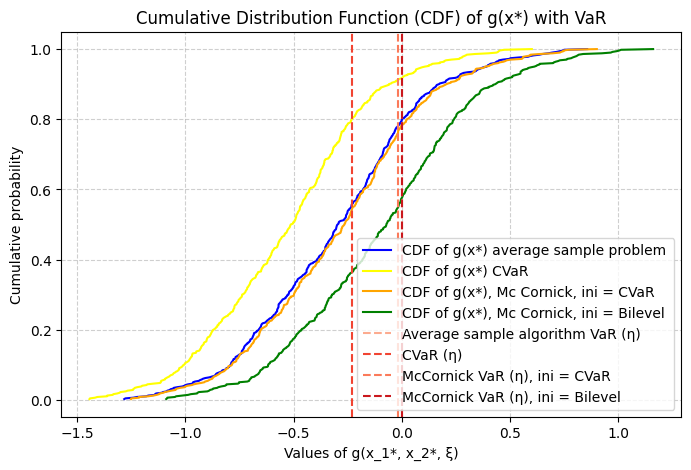

In [177]:
# Cumulative plot of g
g_n500_values1 = np.array([g_1(example1_p1_n500.x[0].value, example1_p1_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values4 = np.array([g_1(example1_p4_n500.x[0].value, example1_p4_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values7 = np.array([g_1(example1_p7_n500.x[0].value, example1_p7_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values7_bil = np.array([g_1(example1_p7_n500_bil.x[0].value, example1_p7_n500_bil.x[1].value, xi) for xi in data_matrix2])

# Sort values for the cumulative distribution function
g_n500_values1_sorted = np.sort(g_n500_values1)
g_n500_values4_sorted = np.sort(g_n500_values4)
g_n500_values7_sorted_bil = np.sort(g_n500_values7_bil)
g_n500_values7_sorted = np.sort(g_n500_values7)
cdf_values = np.arange(1, N2 + 1) / N2  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n500_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) average sample problem")
plt.plot(g_n500_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n500_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*), Mc Cornick, ini = CVaR ")
plt.plot(g_n500_values7_sorted_bil, cdf_values, linestyle="-", color="green", markersize=3, label="CDF of g(x*), Mc Cornick, ini = Bilevel ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example1_p1_n500.eta.value, color=colors[0], linestyle='--', label="Average sample algorithm VaR (η)")
plt.axvline(x=example1_p4_n500.eta.value, color=colors[2], linestyle='--', label="CVaR (η)")
plt.axvline(x=example1_p7_n500.eta.value, color=colors[1], linestyle='--', label="McCornick VaR (η), ini = CVaR")
plt.axvline(x=example1_p7_n500_bil.eta.value, color=colors[3], linestyle='--', label="McCornick VaR (η), ini = Bilevel")


# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig('Example1_n500_Mc_cormick.png')
plt.show()


**Accumulative plot of g** Example 1

n=10

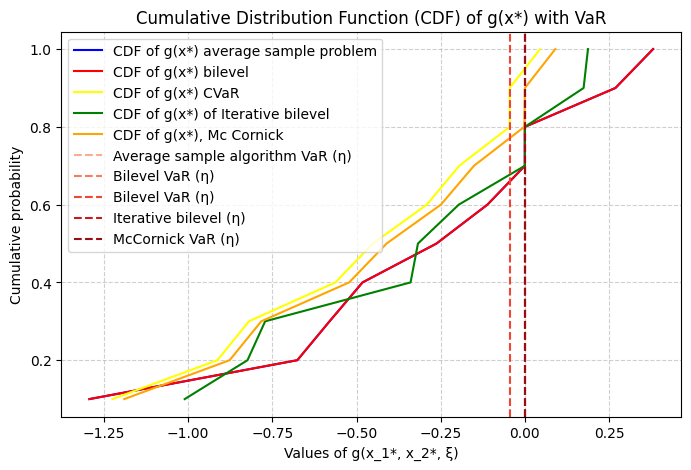

In [85]:
# Cumulative plot of g
g_n10_values1 = np.array([g_1(example1_p1_n10.x[0].value, example1_p1_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values3 = np.array([g_1(example1_p3_n10.x[0].value, example1_p3_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values4 = np.array([g_1(example1_p4_n10.x[0].value, example1_p4_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values5 = np.array([g_1(example1_p5_n10.x[0].value, example1_p5_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values7 = np.array([g_1(example1_p7_n10.x[0].value, example1_p7_n10.x[1].value, xi) for xi in data_matrix])

# Sort values for the cumulative distribution function
g_n10_values1_sorted = np.sort(g_n10_values1)
g_n10_values3_sorted = np.sort(g_n10_values3)
g_n10_values4_sorted = np.sort(g_n10_values4)
g_n10_values5_sorted = np.sort(g_n10_values5)
g_n10_values7_sorted = np.sort(g_n10_values7)
cdf_values = np.arange(1, N1 + 1) / N1  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n10_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) average sample problem")
plt.plot(g_n10_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) bilevel")
plt.plot(g_n10_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n10_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) of Iterative bilevel")
plt.plot(g_n10_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*), Mc Cornick ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example1_p1_n10.eta.value, color=colors[0], linestyle='--', label="Average sample algorithm VaR (η)")
plt.axvline(x=example1_p3_n10.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example1_p4_n10.eta.value, color=colors[2], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example1_p5_n10.eta.value, color=colors[3], linestyle='--', label="Iterative bilevel (η)")
plt.axvline(x=example1_p7_n10.eta.value, color=colors[4], linestyle='--', label="McCornick VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


n=500

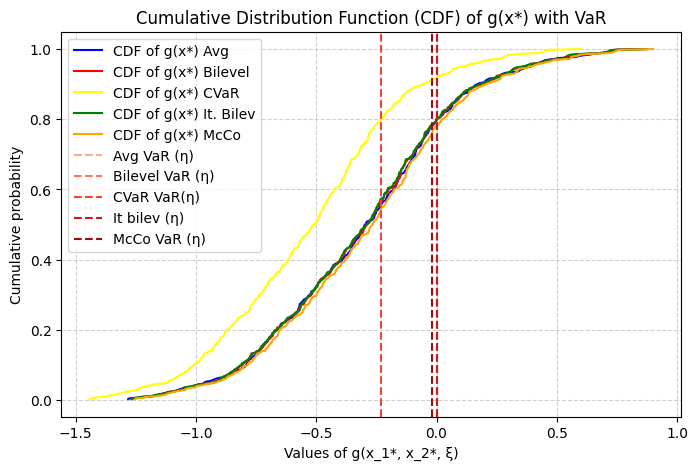

In [393]:
# Cumulative plot of g
g_n500_values1 = np.array([g_1(example1_p1_n500.x[0].value, example1_p1_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values3 = np.array([g_1(example1_p3_n500.x[0].value, example1_p3_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values4 = np.array([g_1(example1_p4_n500.x[0].value, example1_p4_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values5 = np.array([g_1(example1_p5_n500.x[0].value, example1_p5_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values7 = np.array([g_1(example1_p7_n500.x[0].value, example1_p7_n500.x[1].value, xi) for xi in data_matrix2])

# Sort values for the cumulative distribution function
g_n500_values1_sorted = np.sort(g_n500_values1)
g_n500_values3_sorted = np.sort(g_n500_values3)
g_n500_values4_sorted = np.sort(g_n500_values4)
g_n500_values5_sorted = np.sort(g_n500_values5)
g_n500_values7_sorted = np.sort(g_n500_values7)
cdf_values = np.arange(1, N2 + 1) / N2  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n500_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) Avg")
plt.plot(g_n500_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) Bilevel")
plt.plot(g_n500_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n500_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) It. Bilev")
plt.plot(g_n500_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*) McCo ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example1_p1_n500.eta.value, color=colors[0], linestyle='--', label="Avg VaR (η)")
plt.axvline(x=example1_p3_n500.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example1_p4_n500.eta.value, color=colors[2], linestyle='--', label="CVaR VaR(η)")
plt.axvline(x=example1_p5_n500.eta.value, color=colors[3], linestyle='--', label="It bilev (η)")
plt.axvline(x=example1_p7_n500.eta.value, color=colors[4], linestyle='--', label="McCo VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.savefig('Example1_n500_accum_plot.png')
plt.show()

# Example 2: Non-Linear example

The problem consider for this section is: 
$$
\begin{align}
\min_{x_1,x_2 \in \mathcal{X}} \quad & x_1^2+x_2^2 \\
\text{s.t.} \quad & P[ x_2-\xi_1 x_1^2- \xi_2\le 0] \geq 0.8,
\end{align}
$$

So in this example we have that: $f(x_1,x_2) = x_1^2+x_2^2 $ and $g(x_1,x_2; \xi)= x_2-\xi_1 x_1^2- \xi_2$

In this problem we are also going to analyze $N1=10$ scenarios and $N2=100$ scenarios. And the probability of the restriction remains the same $p_2 = p_1 = 0.8$.

The first solution is going to be given with the sample average problem:

## Sample average sample formulation
$$
\begin{aligned}
\min_{x \in \mathcal{X}, \eta, y_1, \ldots, y_S} \quad & x_1^2+x_2^2 \\
\text{s.t.} \quad & \eta \le 0 \\
& x_2-\xi_1 x_1^2- \xi_2 - \eta \le M (1 - y_j), \quad j = 1, \ldots, S \\
& \frac{1}{S} \sum_{i=1}^{S} y_i \geq p, \\
& y_j \in \{0, 1\}, \quad j = 1, \ldots, S.
\end{aligned}
$$


The first step then is to define the functions on python and apply the problem define:


In [91]:
# We define f and g for this example 
def g_2(x1, x2, xi):
    return x2 - xi[0] * x1**2 -xi[1] 

def f_2(model):
    return sum(model.x[i]**2 for i in model.I)

**Example 2:** Average sample, n=10


In [71]:
M=100

example2_p1_n10 = create_model1(M=M, N=N1, p=p1, simulated_data=data_matrix, g_function=g_2, f_function=f_2)

result = opt.solve(example2_p1_n10, tee=True)

# Print the results
print("Optimal Values of Variables for f_2:")
for i in example2_p1_n10.I:
    print(f"x[{i}] = {example2_p1_n10.x[i].value}")

print(f"eta = {example2_p1_n10.eta.value}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpf3a4a8_v.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 13 columns, 10 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1 rows, 13 columns and 10 nonzeros
Model fingerprint: 0x1afd46ba
Model has 2 quadratic objective terms
Model has 10 quadratic constraints
Variable types: 3 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e-01]
  QMatrix range    [7e-01, 1e+00]
  QLMatrix range   [1e+00, 1e+02]


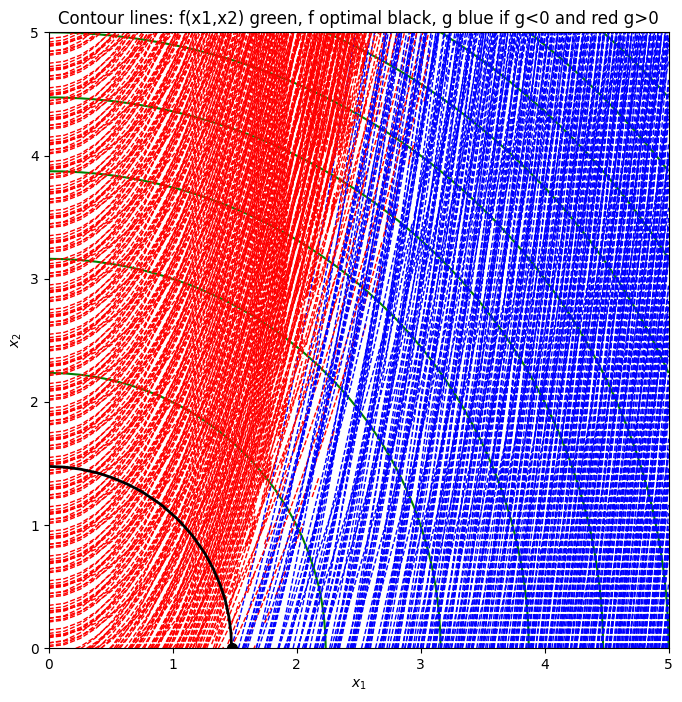

In [314]:
# Grid of 30 elements for (x1, x2) in [0, 500] 
x1 = np.linspace(0, 5, 40)
x2 = np.linspace(0, 5, 40)
X1, X2 = np.meshgrid(x1, x2)

# Initialize plot and axis 
fig, ax = plt.subplots(figsize=(8, 8))

# Plot contour lines for f (=-x1-x2)
f = X1*X1 + X2*X2
ax.contour(X1, X2, f, levels=10, colors='green', linestyles='solid', linewidths=1.5)

# Plot contour lines for g(x1, x2, xi1, xi2)
for j in example2_p1_n10.J:
    
    g = g_2(X1, X2, data_matrix[j, :]) 

    # We separate positive (red) from negative values (blue)
    g_neg = np.ma.masked_where(g >= example2_p1_n10.eta.value, g)  # g < 0
    g_pos = np.ma.masked_where(g <= example2_p1_n10.eta.value, g)  # g > 0

    # Blue contour lines for g < 0
    ax.contour(X1, X2, g_neg, levels=40, colors='blue', linestyles='dashed', linewidths=1.0)

    # Red contour lines for g > 0
    ax.contour(X1, X2, g_pos, levels=40, colors='red', linestyles='dashed', linewidths=1.0)

# Related to solution: 
## Plot contour line on the optimal solution 
opt_x1 = example2_p1_n10.x[0].value
opt_x2 = example2_p1_n10.x[1].value

nivel_f = opt_x1 * opt_x1 +  opt_x2  *opt_x2

contour_f = ax.contour(X1, X2, f, levels=[nivel_f], colors='black', linestyles='solid', linewidths=2)
ax.clabel(contour_f, inline=True, fontsize=500, fmt=f'f(a,b)={nivel_f:.2f}')

#Plot optimal point: 
ax.plot(opt_x1, opt_x2, 'ko', markersize=7, label='Solution') 


# Set axis 
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Contour lines: f(x1,x2) green, f optimal black, g blue if g<0 and red g>0")

plt.savefig("Contourlines_example2_n10.png")
plt.show()

**Example 2:** Average sample, n=500

In [72]:
M=100

example2_p1_n500 = create_model1(M=M, N=N2, p=p1, simulated_data=data_matrix2, g_function=g_2, f_function=f_2)
result = opt.solve(example2_p1_n500, tee=True)

#Print the results
print("Optimal Values of Variables for f_2:")
for i in example2_p1_n500.I:
    print(f"x[{i}] = {example2_p1_n500.x[i].value}")

print(f"eta = {example2_p1_n500.eta.value}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmp95ijkqs8.pyomo.lp
Reading time = 0.00 seconds
x1: 1 rows, 503 columns, 500 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1 rows, 503 columns and 500 nonzeros
Model fingerprint: 0xcc0ff168
Model has 2 quadratic objective terms
Model has 500 quadratic constraints
Variable types: 3 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [2e-03, 2e-03]
  QMatrix range    [4e-01, 2e+00]
  QLMatrix range   [1e+00, 

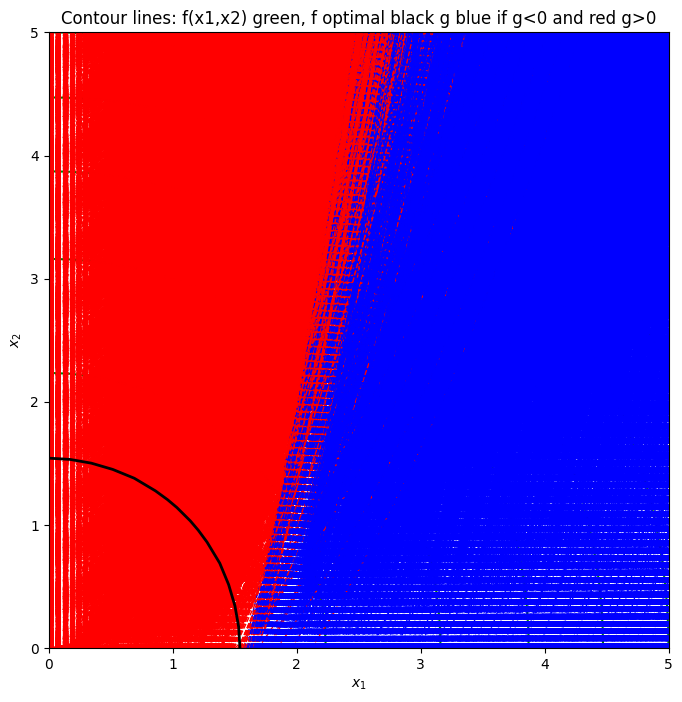

In [ ]:
# Grid of 30 elements for (x1, x2) in [0, 500] 
x1 = np.linspace(0, 5, 30)
x2 = np.linspace(0, 5, 30)
X1, X2 = np.meshgrid(x1, x2)

# Initialize plot and axis 
fig, ax = plt.subplots(figsize=(8, 8))

# Plot contour lines for f (=-x1-x2)
f = X1*X1 + X2*X2
ax.contour(X1, X2, f, levels=10, colors='green', linestyles='solid', linewidths=1.5)

# Plot contour lines for g(x1, x2, xi1, xi2)
for j in example2_p1_n500.J:
    
    g = g_2(X1, X2, data_matrix2[j, :]) 

    # We separate positive (red) from negative values (blue)
    g_neg = np.ma.masked_where(g >= example2_p1_n500.eta.value, g)  # g < 0 (hide positive values)
    g_pos = np.ma.masked_where(g <= example2_p1_n500.eta.value, g)  # g > 0

    # Blue contour lines for g < 0
    ax.contour(X1, X2, g_neg, levels=20, colors='blue', linestyles='dashed', linewidths=1.0)

    # Red contour lines for g > 0
    ax.contour(X1, X2, g_pos, levels=20, colors='red', linestyles='dashed', linewidths=1.0)

# Plot contour line on the optimal solution 
nivel_f = example2_p1_n500.x[0].value * example2_p1_n500.x[0].value +  example2_p1_n500.x[1].value  *example2_p1_n500.x[1].value

contour_f = ax.contour(X1, X2, f, levels=[nivel_f], colors='black', linestyles='solid', linewidths=2)
ax.clabel(contour_f, inline=True, fontsize=500, fmt=f'f(a,b)={nivel_f:.2f}')

# Set axis 
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Contour lines: f(x1,x2) green, f optimal black g blue if g<0 and red g>0")

plt.savefig("Contourlines_example2.png")
plt.show()

## CVaR

**Example 2:** CVaR, n=10

In [174]:

example2_p4_n10 = create_model4(p= p1,matrix_xi= data_matrix, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities, N=N1, g_function=g_2, f_function= f_2)
result = opt.solve(example2_p4_n10, tee=True)

#Print the results
print("Optimal Values of Variables for g_1:")
for i in example2_p4_n10.I:
    print(f"x[{i}] = {example2_p4_n10.x[i].value}")
    
#VaR
print(f"eta = {example2_p4_n10.eta.value}")

#CVaR
Example2_n10_CVaR = example2_p4_n10.eta.value 
for j in example2_p4_n10.J:
    Example2_n10_CVaR = Example2_n10_CVaR + (1/ (1-p1))*(probabilities[j] * example2_p4_n10.v[j].value)

print(f"The Cvar for this example is = {Example2_n10_CVaR}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmppw6l4cky.pyomo.lp
Reading time = 0.00 seconds
x1: 1 rows, 13 columns, 11 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1 rows, 13 columns and 11 nonzeros
Model fingerprint: 0x948b3ac5
Model has 2 quadratic objective terms
Model has 10 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  QMatrix range    [7e-01, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range 

**Example 2:** CVaR, n=500

In [73]:
example2_p4_n500 = create_model4(p= p1,matrix_xi= data_matrix2, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities2, N=N2, g_function=g_2, f_function= f_2)

result = opt.solve(example2_p4_n500, tee=True)

# Print results: x_i variables, VaR, CVaR
print("Optimal Values of Variables for g_2:")
for i in example2_p4_n500.I:
    print(f"x[{i}] = {example2_p4_n500.x[i].value}")

#VaR
print(f"eta = {example2_p4_n500.eta.value}")

#CVaR
Example2_n500_CVaR = example2_p4_n500.eta.value 
for j in example2_p4_n500.J:
    Example2_n500_CVaR = Example2_n500_CVaR + (1/ (1-p1))*(probabilities2[j] * example2_p4_n500.v[j].value)

print(f"The Cvar for this example is = {Example2_n500_CVaR}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpy6_jhg7j.pyomo.lp
Reading time = 0.00 seconds
x1: 1 rows, 503 columns, 501 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1 rows, 503 columns and 501 nonzeros
Model fingerprint: 0x34049573
Model has 2 quadratic objective terms
Model has 500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  QMatrix range    [4e-01, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective r

## Bilevel formulation

$$
\begin{align*}
\min_{x_1, x_2 \in {\mathcal X},\eta, v_1,...,v_S,\pi_1,...,\pi_S } \quad & x_{1}^2 + x_{2}^2 \\
\text{s.t.} \quad &  \eta \le 0  \\
&  p\sum_{j=1}^S u_j+ (1-p)\sum_{j=1}^S  v_j  \leq \sum_{j=1}^S \pi_j ( x_2-\xi_{j,1} x_1^2- \xi_{j,2} ) \\
& u_j - v_j = x_2-\xi_{j,1} x_1^2- \xi_{j,2}  - \eta,\; j=1,...,S, \\
& u_j , v_j \ge 0,\; j=1,...,S\\
&\sum_{j=1}^S \pi_j = 0, \quad \pi_j \in [-(1-p), p], \quad j = 1, ..., S,
\end{align*}
$$

**Example 2**: Bilevel, n=10: initialization: avge. sample solution $(x_1,x_2)*0.8$

In [176]:
#Define initialization values and parameters for the problem
x1_ini = example2_p1_n10.x[0].value * 0.8
x2_ini = example2_p1_n10.x[1].value *0.8
M=200

# Create all the initialization parameters
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix,  p=p1, N=N1, g=g_2)

#The sum of weithgs pi should be zero
print(sum(resultado["pi_ini"]))

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the problem with ipopt
example2_p3_n10 = create_model3(p = p1, matrix_xi = data_matrix, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini= eta_ini, N = N1, g_function = g_2, f_function = f_2)

result = opt2.solve(example2_p3_n10, tee=True)

# Print results
print("Optimal Values of Variables for g_2:")
for i in example2_p3_n10.I:
    print(f"x[{i}] = {example2_p3_n10.x[i].value}")

print(f"eta = {example2_p3_n10.eta.value}")

0.0
WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `0.7588729758882844` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:       32
Number of nonzeros

**Example 2**: Bilevel, n=10: initialization: CVaR solution $(x_1,x_2)$

In [177]:
#Define initialization values and parameters for the problem
x1_ini = example2_p4_n10.x[0].value 
x2_ini = example2_p4_n10.x[1].value 
M=200

# Create all the initialization parameters
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix,  p=p1, N=N1, g=g_2)

#The sum of weithgs pi should be zero
print(sum(resultado["pi_ini"]))

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the problem with ipopt
example2_p3_n10 = create_model3(p = p1, matrix_xi = data_matrix, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini= eta_ini, N = N1, g_function = g_2, f_function = f_2)

result = opt2.solve(example2_p3_n10, tee=True)

# Print results
print("Optimal Values of Variables for g_2:")
for i in example2_p3_n10.I:
    print(f"x[{i}] = {example2_p3_n10.x[i].value}")

print(f"eta = {example2_p3_n10.eta.value}")

0.0
WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:       32
Number of nonzeros in Lagrangian Hessian.............:       23

Total number of variables............................:       33
                     variables with only lower bounds:       22
    

**Example 2**: Bilevel, n=500, initialization values: average sample solution $(x_1,x_2)*0.8$

First I make sure that $g_2(x_{ini},\xi)$ does not give repeated values for different scenarios:

In [181]:
g_values = np.array([g_2(example2_p1_n500.x[0].value, example2_p1_n500.x[1].value , data_matrix2[j,:]) for j in range(N2)])

for i in range(N2):
    for k in range(N2):
        if i>k and g_values[i] == g_values[k]:
            print(f"The value of g(1.54,0, xi) in the scenarios {i} and {k} is repeated")

In [195]:
#Define initialization values and parameters for the problem
x1_ini = example2_p1_n500.x[0].value *0.5
x2_ini = example2_p1_n500.x[1].value 
M=200

# Create all the initialization parameters
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix2,  p=p1, N=N2, g=g_2)

#The sum of weithgs pi should be zero
print(sum(resultado["pi_ini"]))

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the problem with ipopt
example2_p3_n500 = create_model3(p = p1, matrix_xi = data_matrix2, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini= eta_ini, N = N2, g_function = g_2, f_function = f_2)

result = opt2.solve(example2_p3_n500, tee=True)

# Print results
print("Optimal Values of Variables for g_2:")
for i in example2_p3_n500.I:
    print(f"x[{i}] = {example2_p3_n500.x[i].value}")

print(f"eta = {example2_p3_n500.eta.value}")

-3.730349362740526e-14
WARNING (W1002): Setting Var 'pi[296]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `1.5354389951805523` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3000
Number of nonzeros in inequality constraint Jacobian.:     1

**Example 2**: Bilevel, n=500, initialization values: CVaR $(x_1,x_2)$

First I make sure that $g_2(x_{ini},\xi)$ does not give repeated values for different scenarios:

In [98]:
g_values = np.array([g_2(example2_p4_n500.x[0].value, example2_p4_n500.x[1].value , data_matrix2[j,:]) for j in range(N2)])

for i in range(N2):
    for k in range(N2):
        if i>k and g_values[i] == g_values[k]:
            print(f"The value of g(1.54,0, xi) in the scenarios {i} and {k} is repeated")

In [179]:
#Define initialization values and parameters for the problem
x1_ini = example2_p4_n500.x[0].value 
x2_ini = example2_p4_n500.x[1].value 
M=200

# Create all the initialization parameters
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix2,  p=p1, N=N2, g=g_2)

#The sum of weithgs pi should be zero
print(sum(resultado["pi_ini"]))

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the problem with ipopt
example2_p3_n500 = create_model3(p = p1, matrix_xi = data_matrix2, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, eta_ini= eta_ini, N = N2, g_function = g_2, f_function = f_2)

result = opt2.solve(example2_p3_n500, tee=True)

# Print results
print("Optimal Values of Variables for g_2:")
for i in example2_p3_n500.I:
    print(f"x[{i}] = {example2_p3_n500.x[i].value}")

print(f"eta = {example2_p3_n500.eta.value}")

-3.885780586188048e-14
WARNING (W1002): Setting Var 'pi[457]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3000
Number of nonzeros in inequality constraint Jacobian.:     1502
Number of nonzeros in Lagrangian Hessian.............:     1003

Total number of variables............................:     1503
                     variables with only lower

## Bilevel iterative problem

$$
\begin{align*}
\min_{x_1, x_2 \in {\cal X},\eta, v_1,...,v_S} \quad & x_{1}^2 + x_{2}^2 +M\theta  \\
\text{s.t.} \quad &  \eta \le 0\notag \\
&    p\sum_{j=1}^S u_j+ (1-p)\sum_{j=1}^S  v_j  \leq \sum_{j=1}^S \bar{\pi}_{j}^{k} g(x,\xi_j) +\theta;   \\
& u_j-v_j = g(x,\xi_j)  - \eta,\; j=1,...,S, \\
& u_j,v_j \ge 0,\; j=1,...,S
\end{align*}
$$

**Example 2**: Iterative bilevel, n=10, initialization values: Average sample solution $(x_1,x_2)*0.8$

In [398]:
x1_ini = example2_p1_n10.x[0].value * 0.8
x2_ini = example2_p1_n10.x[1].value * 0.8

example2_p5_n10, result2_p5_n10 = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix, num_scen=N1, x1_v0= x1_ini, x2_v0=x2_ini,  g= g_2, f = f_2)

Iteration 1 with k = 0
Los pesos para esta k son: [-0.2 -0.2  0.8 -0.2 -0.2  0.8 -0.2 -0.2 -0.2 -0.2]
WARNING (W1001): Setting Var 'eta' to a value `0.7588729758882844` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001


Optimal x1: 1.4779222485105366, x2: 0.0, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: 2.18425417264244
Iteration 2 with k = 1
Los pesos para esta k son: [-0.2 -0.2  0.8 -0.2 -0.2  0.8 -0.2 -0.2 -0.2 -0.2]
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 2**: Iterative bilevel, n=10, initialization values: CVaR $(x_1,x_2)$

In [399]:
x1_ini = example2_p4_n10.x[0].value
x2_ini = example2_p4_n10.x[1].value 

example2_p5_n10, result2_p5_n10= bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix, num_scen=N1, x1_v0= x1_ini, x2_v0=x2_ini,  g= g_2, f = f_2)

Iteration 1 with k = 0
Los pesos para esta k son: [-0.2 -0.2  0.8 -0.2 -0.2  0.8 -0.2 -0.2 -0.2 -0.2]


Optimal x1: 1.4779222485105366, x2: 0.0, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: 2.18425417264244
Iteration 2 with k = 1
Los pesos para esta k son: [-0.2 -0.2  0.8 -0.2 -0.2  0.8 -0.2 -0.2 -0.2 -0.2]
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 2**: Iterative bilevel, n=500, initialization values: Average sample solution $(x_1,x_2)*0.8$

In [400]:
x1_ini = example2_p1_n500.x[0].value * 0.8
x2_ini = example2_p1_n500.x[1].value * 0.8

example2_p5_n500, result2_p5_n500 = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix2, num_scen=N2, x1_v0= x1_ini, x2_v0=x2_ini,  g= g_2, f = f_2)

Iteration 1 with k = 0
WARNING (W1001): Setting Var 'eta' to a value `0.7283734726054176` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal x1: 1.5415323633062707, x2: 0.0, eta: 0.0
Optimal theta: 0.47222032162743677
Objective value in iteration 1: 2.8659039629913683
Iteration 2 with k = 1
WARNING (W1001): Setting Var 'eta' to a value `0.006058989440925089` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal x1: 1.5436500299173979, x2: 0.0, eta: 0.0
Optimal theta: 0.0007470161972061296
Objective value in iteration 2: 2.383629895798422
Iteration 3 with k = 2
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 2**: Iterative bilevel, n=500, initialization values: CVaR solution $(x_1,x_2)$

In [401]:
x1_ini = example2_p4_n500.x[0].value 
x2_ini = example2_p4_n500.x[1].value 

example2_p5_n500, result2_p5_n500 = bilevel_iteration_loop(max_iterations, tolerance, M=M, p=p1, matrix_xi = data_matrix2, num_scen=N2, x1_v0= x1_ini, x2_v0=x2_ini,  g= g_2, f = f_2)

Iteration 1 with k = 0
Optimal x1: 1.543578362766545, x2: 0.0, eta: 0.0
Optimal theta: 0.027861331100557225
Objective value in iteration 1: 2.411519840552824
Iteration 2 with k = 1
WARNING (W1001): Setting Var 'eta' to a value `0.0009710371607070112`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal x1: 1.5436500299173979, x2: 0.0, eta: 0.0
Optimal theta: 0.0007470161972061296
Objective value in iteration 2: 2.383629895798422
Iteration 3 with k = 2
Terminating: π vector matches a previously generated vector.
Algorithm completed.


# Mc Cornick

**Example 2**: Mc Cormick, n=10, initialization values: Bilevel solution $(x_1,x_2)$

In [385]:
#Initial variables and values
x1_ini = example2_p3_n10.x[0].value
x2_ini = example2_p3_n10.x[1].value

g_values = [g_2(x1_ini, x2_ini, data_matrix[j,:]) for j in range(N1)]
M = max(g_values)

#Initialization of values
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix, p=p1, N=N1, g=g_2)


x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the optimization problem
Dicc_n10 = compute_g_bounds(g_2,data_matrix,N1, x1_ini, x2_ini, M* 0.5)
example2_p7_n10 = create_model7(p= p1, N  = N1, simulated_data = data_matrix, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, pi_ini= pi_ini_dict, eta_ini = eta_ini, g_LO =  Dicc_n10["g_lo"], g_UP = Dicc_n10["g_up"], g_function = g_2, f_function = f_2)

opt.solve(example2_p7_n10)

# Display the results
print("Optimal Values of Variables:")
for i in example2_p7_n10.I:
    print(f"x[{i}] = {example2_p7_n10.x[i].value}" )

print(f"eta = {example2_p7_n10.eta.value}")

WARNING (W1001): Setting Var 'x[1]' to a value `-7.581602633573688e-09`
(float) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `1.0676000750109438e-07`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal Values of Variables:
x[0] = 1.4270217737646038
x[1] = 3.5072037205516067e-09
eta = -6.501955597719609e-09


**Example 2**: Mc Cormick, n=10, initialization values: CVaR solution $(x_1,x_2)$

In [386]:
#Initial variables and values
x1_ini = example2_p4_n10.x[0].value
x2_ini = example2_p4_n10.x[1].value

g_values = [g_2(x1_ini, x2_ini, data_matrix[j,:]) for j in range(N1)]
M = max(g_values)

#Initialization of values
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix, p=p1, N=N1, g=g_2)


x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the optimization problem
Dicc_n10 = compute_g_bounds(g_2,data_matrix,N1, x1_ini, x2_ini, M * 0.5)
example2_p7_n10 = create_model7(p= p1, N  = N1, simulated_data = data_matrix, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, pi_ini= pi_ini_dict, eta_ini = eta_ini, g_LO =  Dicc_n10["g_lo"], g_UP = Dicc_n10["g_up"], g_function = g_2, f_function = f_2)

opt.solve(example2_p7_n10)

# Display the results
print("Optimal Values of Variables:")
for i in example2_p7_n10.I:
    print(f"x[{i}] = {example2_p7_n10.x[i].value}" )

print(f"eta = {example2_p7_n10.eta.value}")

WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables:
x[0] = 1.583105389681018
x[1] = 2.1536730445836443e-09
eta = -0.2340786605293729


**Example 2**: Mc Cormick, n=500, initialization values: Bilevel solution $(x_1,x_2)$

In [106]:
#Initial variables and values
x1_ini = example2_p3_n500.x[0].value
x2_ini = example2_p3_n500.x[1].value

g_values = [g_2(x1_ini, x2_ini, data_matrix2[j,:]) for j in range(N2)]
M = max(g_values)

#Initialization of values
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix2, p=p1, N=N2, g=g_2)


x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the optimization problem
Dicc_n500 = compute_g_bounds(g_2,data_matrix2,N2, x1_ini, x2_ini, M*0.5)
example2_p7_n500 = create_model7(p= p1, N  = N2, simulated_data = data_matrix2, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, pi_ini= pi_ini_dict, eta_ini = eta_ini, g_LO =  Dicc_n500["g_lo"], g_UP = Dicc_n500["g_up"], g_function = g_2, f_function = f_2)

opt.solve(example2_p7_n500)

# Display the results
print("Optimal Values of Variables:")
for i in example2_p7_n500.I:
    print(f"x[{i}] = {example2_p7_n500.x[i].value}" )

print(f"eta = {example2_p7_n500.eta.value}")

WARNING (W1001): Setting Var 'x[1]' to a value `-7.980091309812073e-09`
(float) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1002): Setting Var 'pi[357]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `5.45805764962104e-06` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal Values of Variables:
x[0] = 1.4167787895083541
x[1] = 1.537355553660912e-09
eta = -6.35504151376997e-06


**Example 2**: Mc Cormick, n=500, initialization values: CVaR solution $(x_1,x_2)$

In [75]:
#Initial variables and values
x1_ini = example2_p4_n500.x[0].value
x2_ini = example2_p4_n500.x[1].value

g_values = [g_2(x1_ini, x2_ini, data_matrix2[j,:]) for j in range(N2)]
M = max(g_values)

#Initialization of values
resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=data_matrix2, p=p1, N=N2, g=g_2)


x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

#Solve the optimization problem
Dicc_n500 = compute_g_bounds(g_2,data_matrix2,N2, x1_ini, x2_ini, M * 0.5)
example2_p7_n500 = create_model7(p= p1, N  = N2, simulated_data = data_matrix2, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, pi_ini= pi_ini_dict, eta_ini = eta_ini, g_LO =  Dicc_n500["g_lo"], g_UP = Dicc_n500["g_up"], g_function = g_2, f_function = f_2)

opt.solve(example2_p7_n500)

# Display the results
print("Optimal Values of Variables:")
for i in example2_p7_n500.I:
    print(f"x[{i}] = {example2_p7_n500.x[i].value}" )

print(f"eta = {example2_p7_n500.eta.value}")

WARNING (W1002): Setting Var 'pi[457]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables:
x[0] = 1.542922683784759
x[1] = 1.5359790961021866e-09
eta = -0.0014910767732164995


I count the number of scenarios where the condition is fulfilled


In [76]:
scenarios_fulfilled = []
for j in range(N2):
    valor = g_2(example2_p7_n500.x[0].value, example2_p7_n500.x[1].value, data_matrix2[j,:])
    if valor <= 0:
        scenarios_fulfilled.append(1)
    if valor > 0:
        scenarios_fulfilled.append(0)

#Proporción de escenarios satisfied
sum(scenarios_fulfilled)/N2      

0.796

**Accumulative plot** Example 2

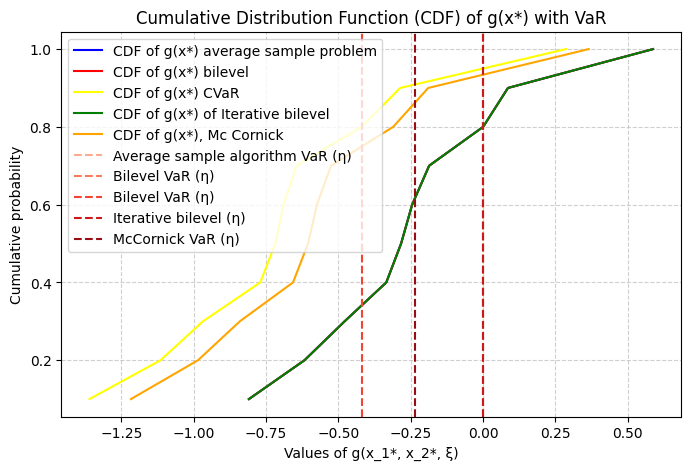

In [108]:
# Cumulative plot of g
g_n10_values1 = np.array([g_2(example2_p1_n10.x[0].value, example2_p1_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values3 = np.array([g_2(example2_p3_n10.x[0].value, example2_p3_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values4 = np.array([g_2(example2_p4_n10.x[0].value, example2_p4_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values5 = np.array([g_2(example2_p5_n10.x[0].value, example2_p5_n10.x[1].value, xi) for xi in data_matrix])
g_n10_values7 = np.array([g_2(example2_p7_n10.x[0].value, example2_p7_n10.x[1].value, xi) for xi in data_matrix])

# Sort values for the cumulative distribution function
g_n10_values1_sorted = np.sort(g_n10_values1)
g_n10_values3_sorted = np.sort(g_n10_values3)
g_n10_values4_sorted = np.sort(g_n10_values4)
g_n10_values5_sorted = np.sort(g_n10_values5)
g_n10_values7_sorted = np.sort(g_n10_values7)
cdf_values = np.arange(1, N1 + 1) / N1  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n10_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) average sample problem")
plt.plot(g_n10_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) bilevel")
plt.plot(g_n10_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n10_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) of Iterative bilevel")
plt.plot(g_n10_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*), Mc Cornick ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example2_p1_n10.eta.value, color=colors[0], linestyle='--', label="Average sample algorithm VaR (η)")
plt.axvline(x=example2_p3_n10.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example2_p4_n10.eta.value, color=colors[2], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example2_p5_n10.eta.value, color=colors[3], linestyle='--', label="Iterative bilevel (η)")
plt.axvline(x=example2_p7_n10.eta.value, color=colors[4], linestyle='--', label="McCornick VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


n=500

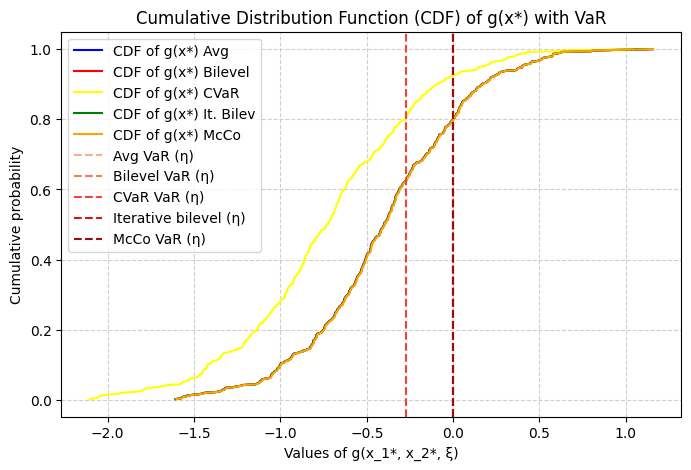

In [ ]:
# Cumulative plot of g
g_n500_values1 = np.array([g_2(example2_p1_n500.x[0].value, example2_p1_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values3 = np.array([g_2(example2_p3_n500.x[0].value, example2_p3_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values4 = np.array([g_2(example2_p4_n500.x[0].value, example2_p4_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values5 = np.array([g_2(example2_p5_n500.x[0].value, example2_p5_n500.x[1].value, xi) for xi in data_matrix2])
g_n500_values7 = np.array([g_2(example2_p7_n500.x[0].value, example2_p7_n500.x[1].value, xi) for xi in data_matrix2])

# Sort values for the cumulative distribution function
g_n500_values1_sorted = np.sort(g_n500_values1)
g_n500_values3_sorted = np.sort(g_n500_values3)
g_n500_values4_sorted = np.sort(g_n500_values4)
g_n500_values5_sorted = np.sort(g_n500_values5)
g_n500_values7_sorted = np.sort(g_n500_values7)
cdf_values = np.arange(1, N2 + 1) / N2  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n500_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) Avg")
plt.plot(g_n500_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) Bilevel")
plt.plot(g_n500_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n500_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) It. Bilev")
plt.plot(g_n500_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*) McCo ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example2_p1_n500.eta.value, color=colors[0], linestyle='--', label="Avg VaR (η)")
plt.axvline(x=example2_p3_n500.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example2_p4_n500.eta.value, color=colors[2], linestyle='--', label="CVaR VaR (η)")
plt.axvline(x=example2_p5_n500.eta.value, color=colors[3], linestyle='--', label="Iterative bilevel (η)")
plt.axvline(x=example2_p7_n500.eta.value, color=colors[4], linestyle='--', label="McCo VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig('Example2_n500_accum_plot.png')
plt.show()


# Example 3: Blending problem

Let consider the problem
$$
\begin{align}
\min_{x_1,x_2} \quad & x_1+x_2 \\
\text{s.t.} \quad & P \left\{
\begin{array}{l}
\omega_1 x_1 + x_2 \geq 7\\
\omega_2 x_1 + x_2 \geq 4 \\
\end{array}
\right\}  \geq \alpha.
\end{align}
$$

Equivalently,
$$
\begin{align}
\min_{x_1,x_2} \quad & x_1+x_2 \\
\text{s.t.} \quad & P \left\{
\begin{array}{l}
7- (\omega_1 x_1 + x_2) \leq 0 \\
4- (\omega_2 x_1 + x_2) \leq 0  \\
\end{array}
\right\}  \geq \alpha,
\end{align}
$$

where  $\omega_1 \sim U[1,4]$ and $\omega_2 \sim U[\frac{1}{3},1] $ and $\alpha = 0.9$.


The scenarios simulated and the functions are defined for this problem:

In [99]:
def g_3a(x1, x2, omega):
    return 7- (omega[0] * x1 + x2  )

def g_3b(x1, x2, omega):
    return 4- (omega[1] * x1 + x2) 

def f_3(model):
    return sum(model.x[i] for i in model.I)

#The maximum of both restrictions
def g_3max(x1,x2, omega):
    return max(g_3a(x1,x2,omega), g_3b(x1,x2, omega))

In [100]:
# Simulation for scenarios
np.random.seed(10)
N3s = 10
N3l = 500
p3 = 0.9

# In this example, the data is uniformly distributed with different upper and lower bounds
data_matrix3s = np.column_stack((
    np.random.uniform(1, 4, N3s),  
    np.random.uniform(1/3, 1, N3s)  
))
print(data_matrix3s)

# Create a data matrix with uniform distribution
data_matrix3l = np.column_stack((
    np.random.uniform(1, 4, N3l),  # First column between 1 and 4
    np.random.uniform(1/3, 1, N3l)  # Second column between 1/3 and 1
))

# Vector of probabilities for each scenario  
probabilities3s = [1/N3s]*N3s
probabilities3l = [1/N3l]*N3l

# Convert to numpy array for easier handling
probabilities3s = np.array(probabilities3s)
probabilities3l = np.array(probabilities3l)

[[3.31396193 0.79023988]
 [1.06225585 0.9689289 ]
 [2.9009447  0.33596551]
 [3.24641165 0.67479484]
 [2.49552104 0.87508064]
 [1.67438994 0.74168404]
 [1.59418859 0.81450354]
 [3.28159214 0.52791738]
 [1.50733251 0.94518275]
 [1.26501944 0.80971719]]


**Example 3**: Average sample, n=10

In [184]:
M=50

#We create the model and add new restrictions for the second g:
example3_p1_n10 = create_model1(M=M, N=N3s, p=p3, simulated_data=data_matrix3s, g_function=g_3a, f_function=f_3)

# Add g_v2 restrictions
example3_p1_n10.g_v2 = Expression(example3_p1_n10.J, rule=lambda example3_p1_n10, j: g_3b(example3_p1_n10.x[0], example3_p1_n10.x[1], data_matrix3s[j, :]))
example3_p1_n10.prob_v2 = Constraint(example3_p1_n10.J, rule=lambda example3_p1_n10, j: example3_p1_n10.g_v2[j] - example3_p1_n10.eta <= M * (1 - example3_p1_n10.y[j]))


# Solve it with gurobi
result = opt.solve(example3_p1_n10, tee=True)

# Print results
print("Optimal Values of Variables for f_2:")
for i in example3_p1_n10.I:
    print(f"x[{i}] = {example3_p1_n10.x[i].value}")

print(f"eta = {example3_p1_n10.eta.value}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpys44ke6a.pyomo.lp
Reading time = 0.00 seconds
x1: 21 rows, 13 columns, 90 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 21 rows, 13 columns and 90 nonzeros
Model fingerprint: 0x36a8ac33
Variable types: 3 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 5e+01]
Presolve removed 3 rows and 1 columns

**Example 3**: Average sample, n=500


In [356]:
M=50

#We create the model and add new restrictions for the second g:
example3_p1_n500 = create_model1(M=M, N=N3l, p=p3, simulated_data=data_matrix3l, g_function=g_3a, f_function=f_3)

# Add g_v2 restrictions
example3_p1_n500.g_v2 = Expression(example3_p1_n500.J, rule=lambda example3_p1_n500, j: g_3b(example3_p1_n500.x[0], example3_p1_n500.x[1], data_matrix3l[j, :]))
example3_p1_n500.prob_v2 = Constraint(example3_p1_n500.J, rule=lambda example3_p1_n500, j: example3_p1_n500.g_v2[j] - example3_p1_n500.eta <= M * (1 - example3_p1_n500.y[j]))


# Solve it with gurobi
result = opt.solve(example3_p1_n500, tee=True)

# Print results
print("Optimal Values of Variables for f_3:")
for i in example3_p1_n500.I:
    print(f"x[{i}] = {example3_p1_n500.x[i].value}")

print(f"eta = {example3_p1_n500.eta.value}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpkm_o11ln.pyomo.lp
Reading time = 0.00 seconds
x1: 1001 rows, 503 columns, 4500 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1001 rows, 503 columns and 4500 nonzeros
Model fingerprint: 0x602cadd4
Variable types: 3 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 5e+01]
Found heuristic solution:

In [114]:
valores_g3max_500 = np.array([ g_3max(example3_p1_n500.x[0].value, example3_p1_n500.x[1].value, data_matrix3l[j,:] ) for j in range(N3l)   ])

for  i in range(N3l):
    for j in range (N3l): 
        if i<j and valores_g3max_500[i]==valores_g3max_500[j]:
            print(f"Los valores de g_3max se repiten para las posiciones {i} y {j} y vale {valores_g3max_500[i]} ")

Los valores de g_3max se repiten para las posiciones 270 y 310 y vale 0.0 


In [115]:
#Compruebo lo anterior
print(max(g_3a(example3_p1_n500.x[0].value, example3_p1_n500.x[1].value, data_matrix3l[154,:]), g_3b(example3_p1_n500.x[0].value, example3_p1_n500.x[1].value, data_matrix3l[154,:])))
print(max(g_3a(example3_p1_n500.x[0].value, example3_p1_n500.x[1].value, data_matrix3l[330,:]), g_3b(example3_p1_n500.x[0].value, example3_p1_n500.x[1].value, data_matrix3l[330,:])))

-1.7469344965140348
-0.5152919764413664


## CVaR

**Example 2**: CVaR, n=10

In [186]:
probs = probabilities3s


#We create the model and add new restrictions for the second g:
example3_p4_n10 = create_model4(p= p3,matrix_xi= data_matrix3s, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probs, N=N3s, g_function=g_3a, f_function= f_3)

#Add restrictions for g_v2
example3_p4_n10.g_v2 = Expression(example3_p4_n10.J, rule=lambda example3_p4_n10, j: g_3b(example3_p4_n10.x[0], example3_p4_n10.x[1], data_matrix3s[j, :]))
example3_p4_n10.prob_v2  =  Constraint(example3_p4_n10.J, rule=lambda example3_p4_n10, j: example3_p4_n10.g_v2[j] - example3_p4_n10.eta <= example3_p4_n10.v[j])

# Solve with gurobi
result = opt.solve(example3_p4_n10, tee=True)

# Print results
print("Optimal Values of Variables for f_3:")
for i in example3_p4_n10.I:
    print(f"x[{i}] = {example3_p4_n10.x[i].value}")

#VaR
print(f"eta = {example3_p4_n10.eta.value}")

#CVaR
Example3_n10_CVaR = example3_p4_n10.eta.value 
for j in example3_p4_n10.J:
    Example3_n10_CVaR = Example3_n10_CVaR + (1/ (1-p3))*(probabilities3s[j] * example3_p4_n10.v[j].value)
print(f"The Cvar for this example is = {Example3_n10_CVaR}")


Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmpz5fjzzyh.pyomo.lp
Reading time = 0.00 seconds
x1: 21 rows, 13 columns, 91 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 21 rows, 13 columns and 91 nonzeros
Model fingerprint: 0xb247998f
Coefficient statistics:
  Matrix range     [3e-01, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 7e+00]
Presolve time: 0.00s
Presolved: 21 rows, 13 columns, 91 nonzeros

Iteration    Objective  

In [119]:
#I study if the max of g has the same value for different scenarios and these solutions
valores_n10_cvar = np.array([g_3max( example3_p4_n10.x[0].value,  example3_p4_n10.x[1].value, data_matrix3s[j,:]) for j in range(N3s)])
valores_n10_cvar


array([-1.87641641,  0.        ,  0.        , -1.3995615 , -2.22685792,
       -1.67585267, -1.97663941, -0.79287246, -1.83842455, -0.83753115])

**Example 3**: CVaR, n=500


In [187]:
probs = probabilities3l

#We create the model and add new restrictions for the second g:
example3_p4_n500 = create_model4(p= p3,matrix_xi= data_matrix3l, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probs, N=N3l, g_function=g_3a, f_function= f_3)

#Add restrictions for g_v2
example3_p4_n500.g_v2 = Expression(example3_p4_n500.J, rule=lambda example3_p4_n500, j: g_3b(example3_p4_n500.x[0], example3_p4_n500.x[1], data_matrix3l[j, :]))
example3_p4_n500.prob_v2  =  Constraint(example3_p4_n500.J, rule=lambda example3_p4_n500, j: example3_p4_n500.g_v2[j] - example3_p4_n500.eta <= example3_p4_n500.v[j])


# Solve it with gurobi
result = opt.solve(example3_p4_n500, tee=True)

# Print results
print("Optimal Values of Variables for g_1:")
for i in example3_p4_n500.I:
    print(f"x[{i}] = {example3_p4_n500.x[i].value}")

#VaR
print(f"eta = {example3_p4_n500.eta.value}")

#CVaR
Example3_n500_CVaR = example3_p4_n500.eta.value 
for j in example3_p4_n500.J:
    Example3_n500_CVaR = Example3_n500_CVaR + (1/ (1-p3))*(probabilities3l[j] * example3_p4_n500.v[j].value)

print(f"The Cvar for this example is = {Example3_n500_CVaR}")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmp5qum9u1p.pyomo.lp
Reading time = 0.01 seconds
x1: 1001 rows, 503 columns, 4501 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1001 rows, 503 columns and 4501 nonzeros
Model fingerprint: 0x625b6d41
Coefficient statistics:
  Matrix range     [2e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 7e+00]
Presolve time: 0.00s
Presolved: 1001 rows, 503 columns, 4501 nonzeros

Iteration

In [121]:
#Compruebo para g_500 si pasa lo mismo: g_max toma dos valores iguales
valores500_ga = np.array([ g_3a( example3_p4_n500.x[0].value , example3_p4_n500.x[1].value , data_matrix3l[j,:]) for j in range(N3l) ])
valores500_gb = np.array([ g_3b( example3_p4_n500.x[0].value , example3_p4_n500.x[1].value , data_matrix3l[j,:]) for j in range(N3l) ])
valores500_gmax= np.array([ max(valores500_ga[j], valores500_gb[j]) for j in range(N3l) ])

for j in range(N3l):
    for i in range(N3l):
        if j<i and valores500_gmax[j] == valores500_gmax[i]: 
            print(f"Se repiten los valores {j} y {i}. Concretamente valen: {valores500_gmax[i]}  ")
            

Se repiten los valores 82 y 126. Concretamente valen: -0.2921213870535775  


In [122]:
#Compruebo lo anterior
print(max(g_3a(example3_p4_n500.x[0].value, example3_p4_n500.x[1].value, data_matrix3l[257,:]), g_3b(example3_p4_n500.x[0].value, example3_p4_n500.x[1].value, data_matrix3l[257,:])))
print(max(g_3a(example3_p4_n500.x[0].value, example3_p4_n500.x[1].value, data_matrix3l[192,:]), g_3b(example3_p4_n500.x[0].value, example3_p4_n500.x[1].value, data_matrix3l[192,:])))

-2.560047520979305
-2.317341955686489


## Bilevel algorithm

In ths case, everything related to the pi's for the initialize values are going to depend on the maximum value of g_3a or g_3b for each escenario. That is why for this first step it was defined $g_{3\text{max}}(x)= \text{max}(g_{3a}(x, \omega_{1j}),g_{3b}(x, \omega_{2j}) )$, to compute the initial values in each escenario n.

The bilevel algorithm needs and extra variable an function to be defined to find the solution:
- g_j(n): a vector of dimension N. It behaves as the maximum of g's and will replaced the original function g in the constraints. That is:
$$
g_j \in \reals \ \text{s.t.} \{ g_j \geq g_3a(x,\omega_{1j}) \ \text{and} \ g_j  \geq g_3b(x,\omega_{2j})  \}
$$

- smooth_max(a,b,epsilon): to create the previous variable it is needed to define a differentiable approximation for the maximum function. Given $\epsilon > =$,  the smooth maximum has the following formula:

$$
   \text{smooth\_max}(a,b,\epsilon) = \frac{1}{2} \cdot (a + b + \sqrt{(a - b)^2 + \epsilon})

$$

Before defining the model with this extra parameters, it is defined an analogous function, called `initialize_values_2gs`, that initializes the variables using the maximum of both functions.

In [103]:
## Initialize values function when having two g's

def initialize_values_2gs(x1, x2, matriz_xi, p, S, ga,gb):
    ga_ini = np.array([ga(x1, x2, matriz_xi[j, :]) for j in range(S)])
    gb_ini = np.array([gb(x1, x2, matriz_xi[j, :]) for j in range(S)])
    
    gmax_ini=np.empty(S)
    for j in range(0,S):
        gmax_ini[j] = max(ga_ini[j],gb_ini[j])
    
    # Calcular el índice J
    J = next(j for j in range(1, S + 1) if (j / S) >= p)

    # Ordenar los índices según g(x, xi) de menor a mayor
    sigma = np.argsort(gmax_ini)  # Indices ordenados por g

    # Construir el vector pi según mis indices anteriores
    pi_ini = np.zeros(S)
    for j in range(S):
        k = j + 1
        if k < J:  # Caso 1
            pi_ini[sigma[j]] = -(1 - p)
        elif k == J:  # Caso 2
            pi_ini[sigma[j]] = (J-1) * (1 - p) - (S - J) * p
        else:  # Caso 3
            pi_ini[sigma[j]] = p

    #Ordeno g y calculo el eta:
    sorted_gmax = np.sort(gmax_ini)
    
    # Definimos eta como el cuantil S*p 
    n_lower = int(p * S)
    eta = sorted_gmax[n_lower - 1]

    # Calcular los valores iniciales de u y v
    u_ini = np.empty(S)
    v_ini = np.empty(S)

    for j in range(S):
        if gmax_ini[j] >= eta:
            u_ini[j] = gmax_ini[j] - eta
            v_ini[j] = 0
        else:
            v_ini[j] = -(gmax_ini[j] - eta)
            u_ini[j] = 0

    return {
        "g_ini": gmax_ini,
        "eta_ini": eta,
        "pi_ini": pi_ini,
        "u_ini": u_ini,
        "v_ini": v_ini
    }

In [108]:
def create_model3_2gs(p, matrix_xi, x_ini, u_ini, v_ini, pi_ini, g_ini, eta_ini, N, ga_function, gb_function, f_function):
    
    model = ConcreteModel()

    # Conjuntos
    model.J = RangeSet(0, N-1)  
    model.I = RangeSet(0,1)    
    
    # Variables
    model.x = Var(model.I, domain=NonNegativeReals, initialize=x_ini)  
    model.u = Var(model.J, domain=NonNegativeReals, initialize= u_ini)
    model.v = Var(model.J, domain=NonNegativeReals, initialize=v_ini)
    model.pi = Var(model.J, bounds=(-(1 - p), p), initialize = pi_ini)
    model.eta = Var(domain=NonPositiveReals, initialize = eta_ini)
    model.g_j = Var(model.J, domain=Reals, initialize = g_ini)
    
    # **Expresiones para ga(x, omega) y gb(x,omega)**
    def ga_expr_rule(model, j):
        return ga_function(model.x[0], model.x[1], matrix_xi[j, :]) 
    model.ga = Expression(model.J, rule=ga_expr_rule)
    
    def gb_expr_rule(model, j):
        return gb_function(model.x[0], model.x[1], matrix_xi[j, :]) 
    model.gb = Expression(model.J, rule=gb_expr_rule)

    # Objective function
    model.Objective = Objective(rule=f_function, sense=minimize)

    #Restricciones para g_j
    def smooth_max(a, b, epsilon=1e-4):
        return 0.5 * (a + b + sqrt((a - b)**2 + epsilon))

    def define_gj_soft(m, j):
        g1 = m.ga[j] 
        g2 = m.gb[j]
        return m.g_j[j] == smooth_max(g1, g2)

    model.g_soft = Constraint(model.J, rule=define_gj_soft)

    # Restricción que cumplen los pesos pi
    def pesos_rule(model):
        return sum(model.pi[j] for j in model.J) == 0
    model.pesos = Constraint(rule=pesos_rule)

    #Restrictions defining u and v
    def cuantil_rule(model, j):
        return model.g_j[j] - model.eta == model.u[j] - model.v[j]
    model.cuantil = Constraint(model.J, rule=cuantil_rule)

    #Proportion rule
    def combinacion_rule(model):
        return p*(sum(model.u[j] for j in model.J) ) + (1-p)*(sum(model.v[j] for j in model.J) ) <= (sum(model.pi[j] * model.g_j[j]  for j in model.J) )
    model.combinacion = Constraint(rule=combinacion_rule)  
    
    return model

**Example 3**: Bilevel, n=10, Initialization values: real solution $(x_1,x_2)*0.8$


In [190]:
#Initial values
x1 = 0.8* 9/(11-9*p3)
x2 = 0.8* (41-36*p3)/(11-9*p3)

resultado = initialize_values_2gs(x1, x2, data_matrix3s, p3, N3s, g_3a, g_3b )

x_ini_dict = {0: x1 , 1: x2}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N3s)}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N3s)}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N3s)}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N3s)}
eta_ini = resultado["eta_ini"]

#Create the model
example3_p3_n10 = create_model3_2gs(p = p3, matrix_xi = data_matrix3s, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict, eta_ini =eta_ini, N = N3s, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

# Solve it with ipopt
result = opt2.solve(example3_p3_n10, tee=True)

# Print results
print("Optimal Values of Variables for g_3:")
for i in example3_p3_n10.I:
    print(f"x[{i}] = {example3_p3_n10.x[i].value}")

print(f"eta = {example3_p3_n10.eta.value}")

WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


WARNING (W1001): Setting Var 'eta' to a value `1.486848280634959` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       80
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:       11

Total number of variables............................:       43
                     variables with only lower bounds:       22
                variables 

**Example 3**: Bilevel, n=10, Initialization values: CVaR $(x_1,x_2)$


In [191]:
#Initial values
x1 = example3_p4_n10.x[0].value
x2 = example3_p4_n10.x[1].value

resultado = initialize_values_2gs(x1, x2, data_matrix3s, p3, N3s, g_3a, g_3b )

x_ini_dict = {0: x1 , 1: x2}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N3s)}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N3s)}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N3s)}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N3s)}
eta_ini = resultado["eta_ini"]

#Create the model
example3_p3_n10 = create_model3_2gs(p = p3, matrix_xi = data_matrix3s, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict, eta_ini =eta_ini, N = N3s, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

# Solve it with ipopt
opt2 = SolverFactory("ipopt")
result = opt2.solve(example3_p3_n10, tee=True)

# Print results
print("Optimal Values of Variables for g_3:")
for i in example3_p3_n10.I:
    print(f"x[{i}] = {example3_p3_n10.x[i].value}")

print(f"eta = {example3_p3_n10.eta.value}")

WARNING (W1002): Setting Var 'pi[1]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       80
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:       11

Total number of variables............................:       43
                     variables with only lower bounds:       22
        

**Example 3**: Bilevel, n=500, Initialization values: average sample $(x_1,x_2)*0.8$


In [ ]:
#Initial values
x1 = 0.8* 9/(11-9*p3)
x2 = 0.8* (41-36*p3)/(11-9*p3)

resultado = initialize_values_2gs(x1, x2, data_matrix3s, p3, N3s, g_3a, g_3b )

x_ini_dict = {0: x1 , 1: x2}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N3s)}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N3s)}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N3s)}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N3s)}
eta_ini = resultado["eta_ini"]

#Create the model
example3_p3_n500 = create_model3_2gs(p = p3, matrix_xi = data_matrix3s, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict, eta_ini =eta_ini, N = N3s, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

# Solve it with ipopt
opt2 = SolverFactory("ipopt")
result = opt2.solve(example3_p3_n500, tee=True)

# Print results
print("Optimal Values of Variables for g_3:")
for i in example3_p3_n500.I:
    print(f"x[{i}] = {example3_p3_n500.x[i].value}")

print(f"eta = {example3_p3_n500.eta.value}")


WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `3.5542801753968494` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       80
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in 

**Example 3**: Bilevel, n=500, Initialization values: CVaR $(x_1,x_2)$


In [355]:
#Initial values
x1 = example3_p4_n500.x[0].value
x2 = example3_p4_n500.x[1].value

resultado = initialize_values_2gs(x1, x2, data_matrix3s, p3, N3s, g_3a, g_3b )

x_ini_dict = {0: x1 , 1: x2}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N3s)}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N3s)}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N3s)}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N3s)}
eta_ini = resultado["eta_ini"]

#Create the model
example3_p3_n500 = create_model3_2gs(p = p3, matrix_xi = data_matrix3s, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict, eta_ini =eta_ini, N = N3s, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

# Solve it with ipopt
opt2 = SolverFactory("ipopt")
result = opt2.solve(example3_p3_n500, tee=True)

# Print results
print("Optimal Values of Variables for g_3:")
for i in example3_p3_n500.I:
    print(f"x[{i}] = {example3_p3_n500.x[i].value}")

print(f"eta = {example3_p3_n500.eta.value}")


WARNING (W1002): Setting Var 'pi[2]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       80
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:       11

Total number of variables............................:       43
                     variables with only lower bounds:       22
        

#### PLOT BILEVEL: smooth_max function 

The difference between maximum function in the simulated scenarios vs the max. smooth from pyomo when evaluating on the solution from the cvar is plotted

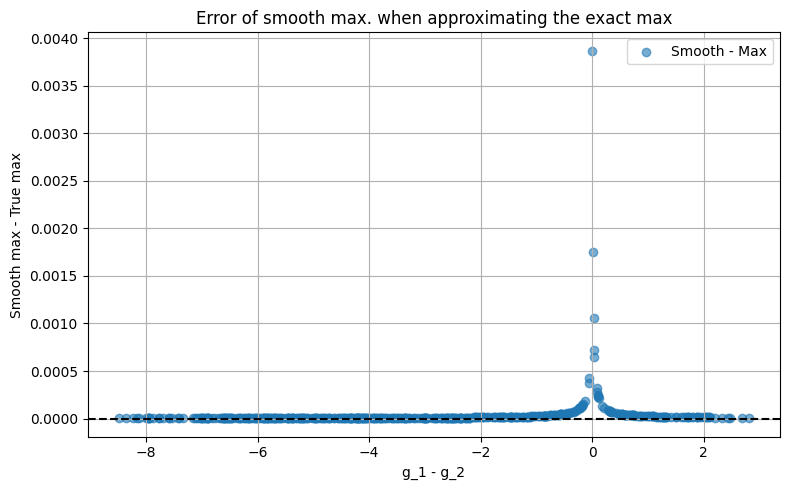

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Calcular a = g_3a y b = g_3b para cada escenario
x1_star = example3_p3_n10.x[0].value
x2_star = example3_p3_n10.x[1].value

g3a_vals = 7 - (data_matrix3l[:, 0] * x1_star + x2_star)
g3b_vals = 4 - (data_matrix3l[:, 1] * x1_star + x2_star)

# max exacto y versión suavizada
gmax_exact = np.maximum(g3a_vals, g3b_vals)
smooth_max = 0.5 * (g3a_vals + g3b_vals + np.sqrt((g3a_vals - g3b_vals)**2 + 1e-4))

# Diferencia entre ambos
diff = smooth_max - gmax_exact

# Plot: Diferencia en función de la diferencia entre g_3a y g_3b
plt.figure(figsize=(8, 5))
plt.scatter(g3a_vals - g3b_vals, diff, alpha=0.6, label="Smooth - Max")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("g_1 - g_2")
plt.ylabel("Smooth max - True max")
plt.title("Error of smooth max. when approximating the exact maximum")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('C:/Users/laull/TFM/smooth_max_error.png')
plt.show()

## Iterative bilevel

The analogous function for the model is created when two functions are defined in the uncertain restriction.


In [106]:
def create_model5_2gs(M, p, pi, N, matriz_xi, x_ini, u_ini, v_ini, eta_ini, g_ini, ga, gb, f_function):
    
    model4 = ConcreteModel()

    # Sets
    model4.J = RangeSet(0, N-1)
    model4.I = RangeSet(0,1)

    # Variables
    model4.x = Var(model4.I, domain=NonNegativeReals, initialize=x_ini)  
    model4.v = Var(model4.J, domain=NonNegativeReals, initialize=v_ini)
    model4.u = Var(model4.J, domain=NonNegativeReals, initialize=u_ini)
    model4.g_j = Var(model4.J, domain=Reals, initialize=g_ini)
    model4.eta = Var(domain=NonPositiveReals, initialize=eta_ini)
    model4.theta = Var(domain=NonNegativeReals)

    # **Expressions for: ga(x, omega) and gb(x,omega)**
    def ga_expr_rule(model, j):
        return ga(model.x[0], model.x[1], matriz_xi[j, :]) 
    model4.ga = Expression(model4.J, rule=ga_expr_rule)
    
    def gb_expr_rule(model, j):
        return gb(model.x[0], model.x[1], matriz_xi[j, :]) 
    model4.gb = Expression(model4.J, rule=gb_expr_rule)

    #Restrictions for g_j
    def smooth_max(a, b, epsilon=1e-4):
        return 0.5 * (a + b + sqrt((a - b)**2 + epsilon))

    def define_gj_soft(m, j):
        g1 = m.ga[j] 
        g2 = m.gb[j]
        return m.g_j[j] == smooth_max(g1, g2)

    model4.g_soft = Constraint(model4.J, rule=define_gj_soft)

    #Objective function
    def objective_rule(model4):
        return f_function(model4) + M * model4.theta
    model4.Objective = Objective(rule=objective_rule, sense=minimize)
    
    # Constraint defining u,v
    def cuantil_rule(model4, j):
        return model4.g_j[j]- model4.eta == model4.u[j] - model4.v[j]
    model4.cuantil = Constraint(model4.J, rule=cuantil_rule)       
    
    #Proportion rule
    def slack_rule(model4):
        return p * sum(model4.u[j] for j in model4.J) + (1 - p) * sum(model4.v[j] for j in model4.J)  <= \
            sum(pi[j] * model4.g_j[j] for j in model4.J) + model4.theta
    model4.slack = Constraint(rule=slack_rule)

    return model4

In [107]:
def bilevel_iteration_loop3(max_iterations, tolerance, M, p, matrix_xi, num_scen, x1_v0, x2_v0, ga, gb, f):
    k = 0  # Initial iteration
    # Values for k=0
    x1, x2 = x1_v0, x2_v0
    pi_previous = []  # List to store generated pi vectors
    current_pi = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1} with k = {k}")

        # Compute initial values of pi, u, and v
        resultado = initialize_values_2gs(x1, x2, matrix_xi, p, num_scen, ga=ga, gb=gb)
        current_pi = resultado["pi_ini"]
        if num_scen < 20:
            print("The weights for this k are:", current_pi)
            print("The sum of pi is:", sum(current_pi))

        # Check if the new pi matches any previous one
        if any(vectors_equal_with_tolerance(current_pi, prev_pi, tolerance) for prev_pi in pi_previous):
            print("Terminating: π vector matches a previously generated vector.")
            break

        # Save the new pi vector
        pi_previous.append(current_pi)

        # Save the new dictionaries to initialize values with those from this iteration
        x_ini_dict = {0: x1, 1: x2}
        u_ini_dict = {j: resultado["u_ini"][j] for j in range(num_scen)}
        v_ini_dict = {j: resultado["v_ini"][j] for j in range(num_scen)}
        g_ini_dict = {j: resultado["g_ini"][j] for j in range(num_scen)}
        eta_ini_dict = resultado["eta_ini"]

        # Create the model
        modelo = create_model5_2gs(M, p=p3, pi=current_pi, N=num_scen, matriz_xi=matrix_xi, x_ini=x_ini_dict, u_ini=u_ini_dict, v_ini=v_ini_dict, eta_ini=eta_ini_dict, g_ini=g_ini_dict, ga=g_3a, gb=g_3b, f_function=f)
        
        # Solve the model
        result = opt2.solve(modelo)

        # Check the result status
        if (result.solver.termination_condition == TerminationCondition.infeasible or 
            result.solver.termination_condition == TerminationCondition.unbounded):
            print("Warning: Model is infeasible or unbounded in iteration {}.".format(iteration + 1))
            break

        # Get optimal solutions
        x1 = modelo.x[0].value
        x2 = modelo.x[1].value
        eta = modelo.eta.value
        theta = modelo.theta.value

        # Print results of the current iteration
        print(f"Optimal x1: {x1}, x2: {x2}, eta: {eta}")
        print(f"Optimal theta: {theta}")
        
        # Print the objective function value
        objective_value = modelo.Objective.expr()
        print(f"Objective value in iteration {iteration + 1}: {objective_value}")

        # Increment k
        k += 1

    print("Algorithm completed.")
    return modelo, result

**Example 3**: Iterative bilevel, n=10, Initialization values: Bilevel $(x_1,x_2)$

In [217]:
x1 = example3_p3_n10.x[0].value
x2 = example3_p3_n10.x[1].value
#Model
example3_p5_n10, example3_p5_n10_result = bilevel_iteration_loop3(max_iterations, tolerance, M=100, p=p3, matrix_xi = data_matrix3s, num_scen=N3s, x1_v0=x1, x2_v0=x2, ga= g_3a, gb = g_3b, f = f_3)

Iteration 1 with k = 0
The weights for this k are: [-0.1  0.9 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
The sum of pi is: 0.0


Optimal x1: 3.229103732819195, x2: 2.9151372400090536, eta: 9.090909091500234e-09
Optimal theta: -9.99088014640247e-09
Objective value in iteration 1: 6.144239973740233
Iteration 2 with k = 1
The weights for this k are: [-0.1  0.9 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
The sum of pi is: 0.0
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 3**: Iterative bilevel, n=10, Initialization values: CVaR $(x_1,x_2)$

In [104]:
# n=10 y sols del bilevel
x1 = example3_p4_n10.x[0].value
x2 = example3_p4_n10.x[1].value
example3_p5_n10, example3_p5_n10_result = bilevel_iteration_loop3(max_iterations, tolerance, M=100, p=p3, matrix_xi = data_matrix3s, num_scen=N3s, x1_v0=x1, x2_v0=x2, ga= g_3a, gb = g_3b, f = f_3)

Iteration 1 with k = 0
The weights for this k are: [-0.1 -0.1  0.9 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
The sum of pi is: 0.0
Optimal x1: 5.614433856089874, x2: 1.0360447995464104, eta: 9.090909092572463e-09
Optimal theta: -9.9908656857672e-09
Objective value in iteration 1: 6.650477656549716
Iteration 2 with k = 1
The weights for this k are: [-0.1 -0.1  0.9 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
The sum of pi is: 0.0
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 3**: Iterative bilevel, n=500, Initialization values: Bilevel solutions $(x_1,x_2) * 0.8$

In [105]:
x1 = example3_p3_n500.x[0].value
x2 = example3_p3_n500.x[1].value

example3_p5_n500, example3_p5_n500_result = bilevel_iteration_loop3(max_iterations, tolerance, M=100, p=p3, matrix_xi = data_matrix3l, num_scen=N3l, x1_v0=x1, x2_v0=x2, ga= g_3a, gb = g_3b, f = f_3)

Iteration 1 with k = 0
WARNING (W1001): Setting Var 'eta' to a value `0.013259334502357056` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal x1: 3.242076591957064, x2: 2.912110458665209, eta: 9.090909090625312e-09
Optimal theta: -9.990843309321015e-09
Objective value in iteration 1: 6.154186051537942
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.


**Example 3**: Iterative bilevel, n=500, Initialization values: CVaR $(x_1,x_2)$

In [357]:
# Ejecutar el bucle iterativo n=10 con las sols del bilevel
x1 = example3_p4_n500.x[0].value
x2 = example3_p4_n500.x[1].value
example3_p5_n500, example3_p5_n500_result = bilevel_iteration_loop3(max_iterations, tolerance, M=100, p=p3, matrix_xi = data_matrix3l, num_scen=N3l, x1_v0=x1, x2_v0=x2, ga= g_3a, gb = g_3b, f = f_3)

Iteration 1 with k = 0
Optimal x1: 3.4608342693687857, x2: 2.8224697924856614, eta: 9.0909090906163e-09
Optimal theta: -9.990839347179801e-09
Objective value in iteration 1: 6.283303062770512
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.


## Mc Cormick

### G bounds for each escenario

Definition for analogous model when 2 functions are defined into the same probability restriction

In [109]:
#We make the pyomo model for this last algorithm  
def create_model7_2gs(p, N, matriz_xi, x_ini, u_ini, v_ini, eta_ini, pi_ini, g_LO, g_UP, ga_function, gb_function, f_function):
    
    model7 = ConcreteModel()

    # Sets
    model7.J = RangeSet(0, N-1)
    model7.I = RangeSet(0,1)

    # Variables
    model7.x = Var(model7.I, domain=NonNegativeReals, initialize=x_ini)  
    model7.v = Var(model7.J, domain=NonNegativeReals, initialize=v_ini)
    model7.u = Var(model7.J, domain=NonNegativeReals, initialize=u_ini)
    model7.pi = Var(model7.J, bounds=(-(1 - p), p), initialize = pi_ini)
    model7.z = Var(model7.J, domain=Reals)
    model7.eta = Var(domain=NonPositiveReals, initialize=eta_ini)
    model7.g_j = Var(model7.J, domain=Reals)

    #Objective function
    model7.Objective = Objective(rule=f_function, sense=minimize)  

    #Expressions for g_a and g_b
    def ga_expr_rule(model7, j):
        return ga_function(model7.x[0], model7.x[1], matriz_xi[j, :]) 
    model7.ga = Expression(model7.J, rule=ga_expr_rule)
    
    def gb_expr_rule(model7, j):
        return gb_function(model7.x[0], model7.x[1], matriz_xi[j, :]) 
    model7.gb = Expression(model7.J, rule=gb_expr_rule)

    #Restrictions for  g_j
    def rule1_gJ(model7,j):
        return (model7.g_j[j] >= model7.ga[j])
    model7.rule1_g_j = Constraint(model7.J, rule=rule1_gJ)
    
    def rule2_gJ(model7,j):
        return (model7.g_j[j] >= model7.gb[j])
    model7.rule2_g_j = Constraint(model7.J, rule=rule2_gJ)
    

    # Restriction defining u,v
    def cuantil_rule(model7, j):
        return model7.g_j[j] - model7.eta == model7.u[j] - model7.v[j]
    model7.cuantil = Constraint(model7.J, rule=cuantil_rule)
        
    #Restriction over sum of weights 
    def suma_pis(model7):
        return sum( model7.pi[j] for j in model7.J) == 0
    model7.sumapi = Constraint(rule=suma_pis)
    
    #Proportion restriction
    def slack_rule(model7):
            return p * sum(model7.u[j] for j in model7.J) + (1 - p) * sum(model7.v[j] for j in model7.J) <= sum(model7.z[j] for j in model7.J) 
    model7.slack = Constraint(rule=slack_rule)

    #Restrictions for the variable z
    def cua_zeta(model7, j):
            return model7.z[j] <= model7.pi[j]*g_LO[j] + p* model7.g_j[j] -p*g_LO[j]
    model7.cuazeta = Constraint(model7.J, rule=cua_zeta)

    def ter_zeta(model7, j):
            return model7.z[j] <= model7.pi[j]*g_UP[j] - (1-p)* model7.g_j[j] + (1-p)*g_UP[j]
    model7.terzeta = Constraint(model7.J, rule=ter_zeta)

    def seg_zeta(model7, j):
            return model7.z[j] >= model7.pi[j]*g_UP[j] +p* model7.g_j[j] -p*g_UP[j]
    model7.segzeta = Constraint(model7.J, rule=seg_zeta)

    def prim_zeta(model7, j):
            return model7.z[j] >= model7.pi[j]*g_LO[j] - (1-p)* model7.g_j[j] + (1-p)*g_LO[j]
    model7.primzeta = Constraint(model7.J, rule=prim_zeta)
    
    return model7

**Example 3**: Mc Cormick, n=10, Initialization values: Bilevel $(x_1,x_2)$

In [109]:
#Initialize values
x1_ini = example3_p3_n10.x[0].value
x2_ini = example3_p3_n10.x[1].value


resultado = initialize_values_2gs(x1=x1_ini, x2=x2_ini, matriz_xi=data_matrix3s, p=p3, S=N3s, ga=g_3a, gb = g_3b)

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

M = max(resultado["g_ini"])

Dicc_n10 = compute_g_bounds(g_3max,data_matrix3s,N3s, x1_ini, x2_ini, M)
g_LO = Dicc_n10["g_lo"]
g_UP = Dicc_n10["g_up"]

#We crate the instance with the model
example3_p7_n10 = create_model7_2gs(p= p3, N  = N3s, matriz_xi = data_matrix3s, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  g_LO, g_UP = g_UP, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

#We solve it:
opt.solve(example3_p7_n10)

# Display the results
print("Optimal Values of Variables:")
for i in example3_p7_n10.I:
    print(f"x[{i}] = {example3_p7_n10.x[i].value}" )

print(f"eta = {example3_p7_n10.eta.value}")
    

WARNING (W1002): Setting Var 'pi[2]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


Optimal Values of Variables:
x[0] = 2.975759102041944
x[1] = 3.0002475730109675
eta = 0.0


**Example 3**: Mc Cormick, n=10, Initialization values: CVaR $(x_1,x_2)$

In [110]:
#Initialize values
x1_ini = example3_p4_n10.x[0].value
x2_ini = example3_p4_n10.x[1].value

resultado = initialize_values_2gs(x1=x1_ini, x2=x2_ini, matriz_xi=data_matrix3s, p=p3, S=N3s, ga=g_3a, gb = g_3b)

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

M = max(resultado["g_ini"])

Dicc_n10 = compute_g_bounds(g_3max,data_matrix3s,N3s, x1_ini, x2_ini, M)
g_LO = Dicc_n10["g_lo"]
g_UP = Dicc_n10["g_up"]

#We crate the instance with the model
example3_p7_n10 = create_model7_2gs(p= p3, N  = N3s, matriz_xi = data_matrix3s, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  g_LO, g_UP = g_UP, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

#We solve it:
opt.solve(example3_p7_n10)

# Display the results
print("Optimal Values of Variables:")
for i in example3_p7_n10.I:
    print(f"x[{i}] = {example3_p7_n10.x[i].value}" )

print(f"eta = {example3_p7_n10.eta.value}")
    

WARNING (W1002): Setting Var 'pi[1]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables:
x[0] = 4.130579530487535
x[1] = 2.6122677377874908
eta = 0.0


**Example 3**: Mc Cormick, n=500, Initialization values: Bilevel $(x_1,x_2)$

In [111]:
#Initialize values
x1_ini = example3_p3_n500.x[0].value
x2_ini = example3_p3_n500.x[1].value

resultado = initialize_values_2gs(x1=x1_ini, x2=x2_ini, matriz_xi=data_matrix3l, p=p3, S=N3l, ga=g_3a, gb = g_3b)

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

M = max(resultado["g_ini"])

Dicc_n500 = compute_g_bounds(g_3max,data_matrix3l,N3l, x1_ini, x2_ini, M)
g_LO = Dicc_n500["g_lo"]
g_UP = Dicc_n500["g_up"]

#We crate the instance with the model
example3_p7_n500 = create_model7_2gs(p= p3, N  = N3l, matriz_xi = data_matrix3l, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  g_LO, g_UP = g_UP, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

#We solve it:
opt.solve(example3_p7_n500)

# Display the results
print("Optimal Values of Variables:")
for i in example3_p7_n500.I:
    print(f"x[{i}] = {example3_p7_n500.x[i].value}" )

print(f"eta = {example3_p7_n500.eta.value}")

WARNING (W1002): Setting Var 'pi[270]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `0.013259334502357056` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal Values of Variables:
x[0] = 2.791644306808986
x[1] = 2.9413409016666354
eta = 0.0


**Example 3**: Mc Cormick, n=500, Initialization values: CVaR $(x_1,x_2)$

In [112]:
#Initialize values
x1_ini = example3_p4_n500.x[0].value
x2_ini = example3_p4_n500.x[1].value

resultado = initialize_values_2gs(x1=x1_ini, x2=x2_ini, matriz_xi=data_matrix3l, p=p3, S=N3l, ga=g_3a, gb = g_3b)

x_ini_dict = {0: x1_ini , 1: x2_ini}  
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]

M = max(resultado["g_ini"])

Dicc_n500 = compute_g_bounds(g_3max,data_matrix3l,N3l, x1_ini, x2_ini, M/2)
g_LO = Dicc_n500["g_lo"]
g_UP = Dicc_n500["g_up"]

#We crate the instance with the model
example3_p7_n500 = create_model7_2gs(p= p3, N  = N3l, matriz_xi = data_matrix3l, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  g_LO, g_UP = g_UP, ga_function = g_3a, gb_function = g_3b, f_function = f_3)

#We solve it:
opt.solve(example3_p7_n500)

# Display the results
print("Optimal Values of Variables:")
for i in example3_p7_n500.I:
    print(f"x[{i}] = {example3_p7_n500.x[i].value}" )

print(f"eta = {example3_p7_n500.eta.value}")

WARNING (W1002): Setting Var 'pi[126]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables:
x[0] = 3.4720676625847124
x[1] = 2.911306312998911
eta = -0.09268899966766186


**Cumulative plot**

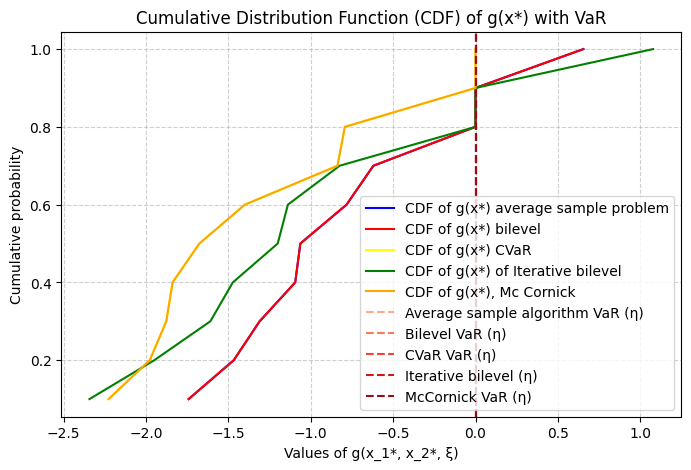

In [113]:
# Cumulative plot of g
g_n10_values1 = np.array([g_3max(example3_p1_n10.x[0].value, example3_p1_n10.x[1].value, xi) for xi in data_matrix3s])
g_n10_values3 = np.array([g_3max(example3_p3_n10.x[0].value, example3_p3_n10.x[1].value, xi) for xi in data_matrix3s])
g_n10_values4 = np.array([g_3max(example3_p4_n10.x[0].value, example3_p4_n10.x[1].value, xi) for xi in data_matrix3s])
g_n10_values5 = np.array([g_3max(example3_p5_n10.x[0].value, example3_p5_n10.x[1].value, xi) for xi in data_matrix3s])
g_n10_values7 = np.array([g_3max(example3_p7_n10.x[0].value, example3_p7_n10.x[1].value, xi) for xi in data_matrix3s])

# Sort values for the cumulative distribution function
g_n10_values1_sorted = np.sort(g_n10_values1)
g_n10_values3_sorted = np.sort(g_n10_values3)
g_n10_values4_sorted = np.sort(g_n10_values4)
g_n10_values5_sorted = np.sort(g_n10_values5)
g_n10_values7_sorted = np.sort(g_n10_values7)
cdf_values = np.arange(1, N3s + 1) / N3s  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n10_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) average sample problem")
plt.plot(g_n10_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) bilevel")
plt.plot(g_n10_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n10_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) of Iterative bilevel")
plt.plot(g_n10_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*), Mc Cornick ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example3_p1_n10.eta.value, color=colors[0], linestyle='--', label="Average sample algorithm VaR (η)")
plt.axvline(x=example3_p3_n10.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example3_p4_n10.eta.value, color=colors[2], linestyle='--', label="CVaR VaR (η)")
plt.axvline(x=example3_p5_n10.eta.value, color=colors[3], linestyle='--', label="Iterative bilevel (η)")
plt.axvline(x=example3_p7_n10.eta.value, color=colors[4], linestyle='--', label="McCornick VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


N= 500

In [434]:
x1_real, x2_real = 3.103, 2.97 

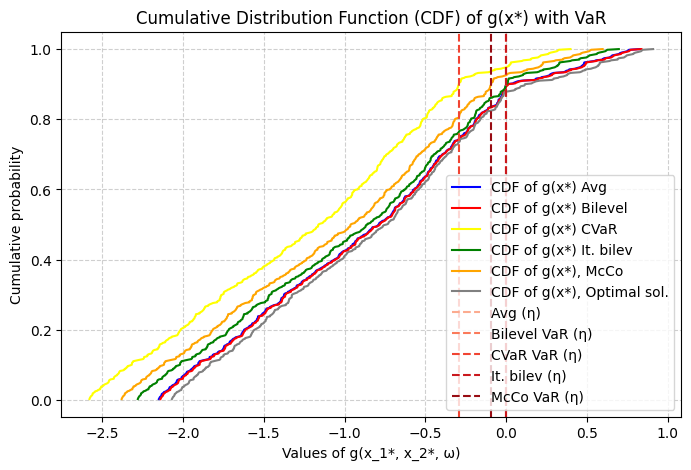

In [437]:
# Cumulative plot of g
g_real_sols =  np.array([g_3max(x1_real, x2_real, xi) for xi in data_matrix3l]) 
g_n500_values1 = np.array([g_3max(example3_p1_n500.x[0].value, example3_p1_n500.x[1].value, xi) for xi in data_matrix3l])
g_n500_values3 = np.array([g_3max(example3_p3_n500.x[0].value, example3_p3_n500.x[1].value, xi) for xi in data_matrix3l])
g_n500_values4 = np.array([g_3max(example3_p4_n500.x[0].value, example3_p4_n500.x[1].value, xi) for xi in data_matrix3l])
g_n500_values5 = np.array([g_3max(example3_p5_n500.x[0].value, example3_p5_n500.x[1].value, xi) for xi in data_matrix3l])
g_n500_values7 = np.array([g_3max(example3_p7_n500.x[0].value, example3_p7_n500.x[1].value, xi) for xi in data_matrix3l])

# Sort values for the cumulative distribution function
g_n500_values1_sorted = np.sort(g_n500_values1)
g_n500_values3_sorted = np.sort(g_n500_values3)
g_n500_values4_sorted = np.sort(g_n500_values4)
g_n500_values5_sorted = np.sort(g_n500_values5)
g_n500_values7_sorted = np.sort(g_n500_values7)
g_real_sols_sorted = np.sort(g_real_sols)
cdf_values = np.arange(1, N3l + 1) / N3l  # Cumulative fractions by adding one value per solution


# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n500_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) Avg")
plt.plot(g_n500_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) Bilevel")
plt.plot(g_n500_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n500_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) It. bilev")
plt.plot(g_n500_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*), McCo ")
plt.plot(g_real_sols_sorted, cdf_values, linestyle="-", color="grey", markersize=3, label="CDF of g(x*), Optimal sol.")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example3_p1_n500.eta.value, color=colors[0], linestyle='--', label="Avg (η)")
plt.axvline(x=example3_p3_n500.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example3_p4_n500.eta.value, color=colors[2], linestyle='--', label="CVaR VaR (η)")
plt.axvline(x=example3_p5_n500.eta.value, color=colors[3], linestyle='--', label="It. bilev (η)")
plt.axvline(x=example3_p7_n500.eta.value, color=colors[4], linestyle='--', label="McCo VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ω)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig('Example3_n500_accum_plot.png')
plt.show()

# Example 4: Hydro Power Management problem 



$$ 
\text{Minimize}_x \ {f=\sum_{ t=1}^T \sum_{j=1}^3 c_t^{(j)}x_t^{(j)}},$$
where cost coefficients are computed as:
$$
\begin{array}
  c_t^{(1)}  & = & w_1-w_2-\lambda^{(1)}\pi_t\\
  c_t^{(2)}  & = & w_1-w_2-\lambda^{(2)}\pi_t\\
  c_t^{(3)}  & = & w_2-\lambda^{(3)}\pi_t,
\end{array}
$$

these cost coefficients take into consideration not only energy selling incomes but also the levels at the end of the considered period, subject to constraints:
$$
\text{Prob} \left(
\begin{array}{rcl}
   l_0^{(1)}+\sum_{\tau=1}^{t}\xi_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(2)}&\le&l^{\ast(1)}; &\forall t \\
   l_0^{(1)}+\sum_{\tau=1}^{t}\xi_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(2)}&\ge&l_\ast^{(1)}; & \forall t  \\
  l_0^{(2)}+\sum_{\tau=1}^{t}\xi_\tau^{(2)}+\sum_{\tau=1}^{t}x_\tau^{(1)}+\sum_{\tau=1}^{t}x_\tau^{(2)}-\sum_{\tau=1}^{t}x_\tau^{(3)} & \le& l^{\ast(2)}; & \forall t \\
  l_0^{(2)}+\sum_{\tau=1}^{t}\xi_\tau^{(2)}+\sum_{\tau=1}^{t}x_\tau^{(1)}+\sum_{\tau=1}^{t}x_\tau^{(2)}-\sum_{\tau=1}^{t}x_\tau^{(3)}&\ge&l_\ast^{(2)}; &\forall t
\end{array}\right) \geq \alpha
$$
$$
0 \le x_t^{(j)} \le  m^{(j)};\;j=1,2,3;t=1,2,\ldots,T.
$$


Where in our example the parameters are:
- $T=32$ and $\alpha = 0.9$
-  $l_\ast^{(1)},l^{\ast(1)} = 0, 95.000$ and $l_\ast^{(2)},l^{\ast(2)} = 0, 11.000$
-  $l_0^{(1)} = 120$ and $l_0^{(2)} = 130$ 
-  $\xi_t^{(i)}$: they are independent for each ($i=1,2$) and we have that: $\xi_t^{(1)} \sim N(15, 0.375) $ and $\xi_t^{(2)} \sim N(12, 0.24) $
-  $m^{(1)} = 55, m^{(2)} = 65, m^{(3)} = 80$ 
-  $x_t^{(j)}$: Water release used for turbine $j$ during time interval $t$ ($j=1,2,3;\;t=1,\ldots,32$), will be our variables.
-  $\lambda^{(1)} = 0.638 $, $\lambda^{(2)} = 0.7.41$ and $\lambda^{(3)} = 0.694$.
-  $w_1 = 20$ and $w_2 = 15$
-  $\pi_t$ for $t=1 \cdot 32$ we have:
$$\pi=\left\{
\begin{array}{c}
  2.5, 2.5, 3.75, 6.25, 5.0, 3.75, 2.5, 2.5,\\
  2.5, 2.5, 2.5, 2.5, 2.5, 2.0, 2.0, 2.0,\\
  2.0, 2.0, 2.0, 2.0, 2.5, 2.5, 2.5, 2.5,\\
  5.0, 5.0, 6.25, 7.5, 6.25, 5.0, 3.75, 2.5
\end{array}\right\}.$$

Due to the complexity of the problem, each function defining a model has been created to this exact example, proceding in an analogous way as the previous functions. Specially, in the third example, since it required looking at the maximum of two functions in the uncertain constraint. In this case, there are no only two functions, but $4 \cdot 32 = 128.$

In [2]:
#Fixed parameters
#alpha
alpha=0.9 
#Number of time intervals
T=32  
#Reservoirs parameteres
#m
upper_oper_limits = np.array([55,65,80])  
#lambda
lambdas = np.array([0.638, 0.741, 0.694]) 
#Omegas: Evaluation coefficients
omegas= np.array([20,15])
#pi
pi= np.array([2.5, 2.5, 3.75, 6.25, 5.0, 3.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.0, 2.0, 2.0, 
            2.0, 2.0, 2.0, 2.0, 2.5, 2.5, 2.5, 2.5, 5.0, 5.0, 6.25, 7.5, 6.25, 5.0, 3.75, 2.5])

#We create the cost coefficients: for the objective function
c1 = np.empty(T)
for t in range(T):
    c1[t] = omegas[0] - omegas[1] - lambdas[0]*pi[t]

c2 = np.empty(T)
for t in range(T):
    c2[t] = omegas[0] - omegas[1] - lambdas[1]*pi[t]

c3 = np.empty(T)
for t in range(T):
    c3[t] = omegas[1] - lambdas[2]*pi[t]

In [3]:
# We create the parameters xi (the water inflows): 
np.random.seed(10)
N5s = 10
N5l = 500

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

S = 500   # Number of scenarios
alpha = 0.9  # Required probability
beta = alpha  # Required probability
T = 32      # Time intervals

# Generate the covariance matrix and compute its Cholesky decomposition
def cholesky_bidiag_cov(T, sigma, rho):
    Cov = np.zeros((T, T))
    np.fill_diagonal(Cov, sigma**2)
    for t in range(T-1):
        Cov[t, t+1] = rho * sigma**2
        Cov[t+1, t] = rho * sigma**2
    L = np.linalg.cholesky(Cov)
    return L

# Means
mu1 = 15.0
mu2 = 12.0

# Standard deviations and autocorrelations
sigma1 = 0.375
sigma2 = 0.24
rho1 = 0.5
rho2 = 0.5

# Cholesky decomposition for each reservoir
L1 = cholesky_bidiag_cov(T, sigma1, rho1)
L2 = cholesky_bidiag_cov(T, sigma2, rho2)

# n=10
noise1_n10 = np.random.randn(N5s, T)  # My standard normal N(0,1) for each reservoir
noise2_n10 = np.random.randn(N5s, T)
inflows1_scen_n10 = mu1 + noise1_n10 @ L1.T   # mu_x + Z * L^T
inflows2_scen_n10 = mu2 + noise2_n10 @ L2.T

# n=500
noise1_n500 = np.random.randn(N5l, T)
noise2_n500 = np.random.randn(N5l, T)
inflows1_scen_n500 = mu1 + noise1_n500 @ L1.T
inflows2_scen_n500 = mu2 + noise2_n500 @ L2.T

# Vector of probabilities for each scenario  
probabilitieN5s = [1/N5s]*N5s 
probabilitieN5l = [1/N5l]*N5l

# Print for n=10
print("The inflows from xi 1 are:", inflows1_scen_n10)
print("The inflows from xi 2 are:", inflows2_scen_n10)
print(inflows1_scen_n10.size)


The inflows from xi 1 are: [[15.49934494 15.48196613 14.68168217 14.64262929 15.17849339 14.94416108
  14.89848796 15.09638655 15.02833662 14.95252192 15.07578585 15.44196437
  15.04092688 15.03563931 15.32602979 15.18036726 14.80438586 14.74391981
  15.43875147 15.09028258 14.18380845 14.01496191 14.61994982 15.71451774
  15.92349717 15.74414711 15.46200345 15.40307849 15.29109726 15.09457154
  15.08793885 14.78231723]
 [15.04976561 14.87025115 15.29754865 15.35829164 15.16250196 15.0001738
  15.27328931 15.10578793 15.00154795 15.06850621 14.65110926 14.62644681
  14.65393213 14.73603181 14.85263506 14.99825157 15.23450842 15.10547463
  14.95490427 15.07185549 14.92828431 15.05213392 15.41178363 15.27372205
  15.70045886 15.87057291 15.20841335 14.87302821 14.84301364 14.80422805
  15.17322614 15.1066967 ]
 [14.96957918 14.81289565 15.20573081 14.81969495 14.5582634  14.87733779
  15.06060178 15.20884185 15.05491062 15.22078481 15.33723509 15.76096174
  15.21361252 14.784932   14.872

Now I can create the functions $g$ taken into account that our original problem has the next probability constraint:
$$
\mathbb{P}[g(x,\xi) \leq 0] \geq \alpha
$$.
So that our fuctions for the constraint will be:
$$
\begin{array}{rcl}
   g_{5a}(x,\xi) &:=& l_0^{(1)}+\sum_{\tau=1}^{t}\xi_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(2)} - l^{\ast(1)} & t=1,...,T  \\
   g_{5b}(x,\xi) &:=& - (l_0^{(1)} + \sum_{\tau=1}^{t}\xi_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(1)}-\sum_{\tau=1}^{t}x_\tau^{(2)}) + l_\ast^{(1)} & t=1,...,T \\
  g_{5c}(x,\xi) &:=& l_0^{(2)}+\sum_{\tau=1}^{t}\xi_\tau^{(2)}+\sum_{\tau=1}^{t}x_\tau^{(1)}+\sum_{\tau=1}^{t}x_\tau^{(2)}-\sum_{\tau=1}^{t}x_\tau^{(3)} - l^{\ast(2)}& t=1,...,T \\
  g_{5d}(x,\xi) &:=& -(l_0^{(2)}+\sum_{\tau=1}^{t}\xi_\tau^{(2)}+\sum_{\tau=1}^{t}x_\tau^{(1)}+\sum_{\tau=1}^{t}x_\tau^{(2)}-\sum_{\tau=1}^{t}x_\tau^{(3)})  + l_\ast^{(2)}& t=1,...,T
\end{array}
$$
If we change the parametres for the actual numbers we have the next expressions:
$$
\begin{array}{rcl}
   g_{5a}(x,\xi) &:=& 120 + \sum_{\tau=0}^{t} (\xi_\tau^{(1)}-x_\tau^{(1)}-x_\tau^{(2)} ) - 95000 & t=0,...,31 \\
   g_{5b}(x,\xi) &:=& - 120 -  \sum_{\tau=0}^{t} (\xi_\tau^{(1)}-x_\tau^{(1)}-x_\tau^{(2)} ) + 0 & t=0,...,31 \\
  g_{5c}(x,\xi) &:=& 130 +\sum_{\tau=0}^{t} (\xi_\tau^{(2)}+x_\tau^{(1)}+x_\tau^{(2)}-x_\tau^{(3)} ) - 11000 & t=0,...,31 \\
  g_{5d}(x,\xi) &:=& -130 - \sum_{\tau=0}^{t} (\xi_\tau^{(2)}+x_\tau^{(1)}+x_\tau^{(2)}-x_\tau^{(3)} )  + 0 & t=0,...,31
\end{array}
$$
And we are going to input the variables $x^{(j)}_t = x[j,t]$ in the next matrix $X \in \mathbb{R}^{T\times 3}$:
$$
X = \left(
\begin{array}{rcl}
   x^{(1)}_1  &    x^{(1)}_2  & ... &   x^{(1)}_{32}   \\
   x^{(2)}_1  &    x^{(2)}_2  & ... &   x^{(2)}_{32}    \\
   x^{(3)}_1  &    x^{(3)}_2  & ... &   x^{(3)}_{32} 
\end{array}\right)
$$

In [113]:
def create_model1_4gs(M, T, N, alpha, m_matrix, c1,c2,c3, inflows1, inflows2):
    model = ConcreteModel()

    # Sets
    model.J = RangeSet(0, 3-1) #Number of turbines 
    model.I = RangeSet(0, 1)   #Number of dams
    model.T= RangeSet(0, T-1)  #Number of time intervals 
    model.N= RangeSet(0, N-1)  #Number of scenarios

    # Variables
    model.x = Var( model.J, model.T, within=NonNegativeReals)  
    model.y = Var(model.N, within=Binary)
    model.eta = Var(within=NonPositiveReals)  
    model.g_n = Var(model.N, within=Reals)  

    # **Objetive function**
    def f_funcion(model):
        return sum((c1[t] * model.x[0, t] + c2[t] * model.x[1, t] + c3[t] * model.x[2, t]) for t in model.T)
    model.Objective = Objective(rule=f_funcion, sense=minimize)
    
    #Restrictions for g:n (units in seconds)
    def rule1_gn(model, n, tfin):
        return model.g_n[n] >= 120 - 95000 + 900* sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model.rule1_gn = Constraint(model.N, model.T, rule=rule1_gn)

    def rule2_gn(model, n, tfin):
        return model.g_n[n] >= -120  -  900* sum( inflows1[n,t]  - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model.rule2_gn = Constraint(model.N, model.T, rule=rule2_gn)

    def rule3_gn(model, n, tfin):
        return model.g_n[n] >= 130 - 11000 +  900* sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model.rule3_gn = Constraint(model.N, model.T, rule=rule3_gn)
    
    def rule4_gn(model, n, tfin):
        return model.g_n[n] >= -130 -  900* sum( inflows2[n,t]  + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model.rule4_gn = Constraint(model.N, model.T, rule=rule4_gn)

    #New restriction not to surpass the upper operating limit of each turbine
    def rule_m(model, t, j):
        return model.x[j,t] <= m_matrix[j]
    model.operating_limits = Constraint(model.T, model.J, rule=rule_m)
    
    # **Restricion defining y**
    def prob_rule(model, n):
        return model.g_n[n] - model.eta <= M * (1 - model.y[n])  
    model.prob = Constraint(model.N, rule=prob_rule)

    # **Proportion restriction**
    def proportion_rule(model):
        return (1 / N) * sum(model.y[n] for n in model.N) >= alpha
    model.proportion = Constraint(rule=proportion_rule)

    return model

**Example 4**: Average sample, n=10

In [13]:
M=10000

example4_p1_n10 = create_model1_4gs(M,T, N5s, alpha, m_matrix = upper_oper_limits, c1=c1, c2=c2, c3=c3, inflows1 = inflows1_scen_n10,
                                    inflows2= inflows2_scen_n10)

result = opt.solve(example4_p1_n10, tee = True)

# Print results
print(f"The optimal value of the function: {value(example4_p1_n10.Objective)}")
print(f"The VaR is: {example4_p1_n10.eta.value} ")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmph80ddi4_.pyomo.lp
Reading time = 0.03 seconds
x1: 1387 rows, 117 columns, 54216 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 1387 rows, 117 columns and 54216 nonzeros
Model fingerprint: 0x4688512f
Variable types: 107 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+04]
  Objective range  [2e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 4e+05]
Presolve removed 801 ro

**Example 4**: Average sample, n=500

In [5]:
M=10000

example4_p1_n500 = create_model1_4gs(M,T, N5l, alpha, m_matrix = upper_oper_limits, c1=c1, c2=c2, c3=c3, inflows1 = inflows1_scen_n500,
                                    inflows2= inflows2_scen_n500)

result = opt.solve(example4_p1_n500, tee= True)

# Print results
print(f"The optimal value of the function: {value(example4_p1_n500.Objective)}")
print(f"The VaR is: {example4_p1_n500.eta.value} ")

Set parameter Username
Set parameter LicenseID to value 2594561
Academic license - for non-commercial use only - expires 2025-12-03
Read LP format model from file C:\Users\laull\AppData\Local\Temp\tmppzec7g7c.pyomo.lp
Reading time = 0.92 seconds
x1: 64597 rows, 1097 columns, 2706096 nonzeros
Set parameter TimeLimit to value 10800
Set parameter Seed to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10800
Seed  10

Optimize a model with 64597 rows, 1097 columns and 2706096 nonzeros
Model fingerprint: 0x8717308a
Variable types: 597 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+04]
  Objective range  [2e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 4e+05]
Presolve remo

## Example 4: CVaR problem

In [114]:
#Model creation when having 4 g's expressions
def create_model4_4gs(p,inflows1, inflows2, v_ini, eta_ini, probs, N, m_matrix ):
    
    model3 = ConcreteModel()

    # Sets
    model3.J = RangeSet(0, 3-1) #Number of turbines 
    model3.I = RangeSet(0, 1)   #Number of dams
    model3.T= RangeSet(0, T-1)  #Number of time intervals 
    model3.N= RangeSet(0, N-1)  #Number of scenarios

    # Variables
    model3.x = Var( model3.J, model3.T, within=NonNegativeReals)       
    model3.v = Var(model3.N, domain=NonNegativeReals, initialize=v_ini)
    model3.eta = Var(domain=NonPositiveReals, initialize = eta_ini)
    model3.g_n =  Var(model3.N, domain=Reals)

    # **Objective function**
    def f_funcion(model):
        return sum((c1[t] * model.x[0, t] + c2[t] * model.x[1, t] + c3[t] * model.x[2, t]) for t in model.T)
    model3.Objective = Objective(rule=f_funcion, sense=minimize)
    
    #Restrictions for g:n (units in seconds)
    def rule1_gn(model, n, tfin):
        return model.g_n[n] >= 120 - 95000 + 900 *sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model3.rule1_gn = Constraint(model3.N, model3.T, rule=rule1_gn)

    def rule2_gn(model, n, tfin):
        return model.g_n[n] >= -120  - 900 * sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model3.rule2_gn = Constraint(model3.N, model3.T, rule=rule2_gn)

    def rule3_gn(model, n, tfin):
        return model.g_n[n] >= 130 - 11000 + 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model3.rule3_gn = Constraint(model3.N, model3.T, rule=rule3_gn)
    
    def rule4_gn(model, n, tfin):
        return model.g_n[n] >= -130 - 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model3.rule4_gn = Constraint(model3.N, model3.T, rule=rule4_gn)

    #New restriction to not surpass the upper operating limit of each turbine
    def rule_m(model, t, j):
        return model.x[j,t] <= m_matrix[j]
    model3.operating_limits = Constraint(model3.T, model3.J, rule=rule_m)
    
    # **Proportion restriction**
    def probs_rule(model3):
        return model3.eta + (1/(1-p))* sum(model3.v[n]*probs[n] for n in model3.N) <= 0
    model3.probs = Constraint(rule=probs_rule)

    ## **Restriction defining y**
    def vs_rule(model3, n):
        return model3.g_n[n] - model3.eta <= model3.v[n]
    model3.vs = Constraint(model3.N, rule=vs_rule)
    
    return model3


**Example 4**: CVaR, n=10

In [11]:
M=5000
example4_p4_n10 = create_model4_4gs(p = alpha,inflows1 = inflows1_scen_n10, inflows2 = inflows2_scen_n10, v_ini = 1, eta_ini = 0, probs = probabilitieN5s, N=N5s
                                    , m_matrix= upper_oper_limits)

result = opt.solve(example4_p4_n10)

# Print the results
print("Optimal Values of Variables for gf:")
for t in example4_p4_n10.T:
    for j in example4_p4_n10.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p4_n10.x[j,t].value}")

print(f"The value of the objective function is: {value(example4_p4_n10.Objective)} ")
#VaR
print(f"eta = {example4_p4_n10.eta.value}")

#CVaR
example4_n10_CVaR = example4_p4_n10.eta.value 
for j in example4_p4_n10.J:
    example4_n10_CVaR = example4_n10_CVaR + (1/ (1-alpha))*(probabilitieN5s[j] * example4_p4_n10.v[j].value)
print(f"The Cvar for this example is = {example4_n10_CVaR}")


Optimal Values of Variables for gf:
x[turbina 0 en tiempo 0] = 0.0
x[turbina 1 en tiempo 0] = 0.0
x[turbina 2 en tiempo 0] = 0.1864949109768592
x[turbina 0 en tiempo 1] = 0.0
x[turbina 1 en tiempo 1] = 0.0
x[turbina 2 en tiempo 1] = 12.209480563011438
x[turbina 0 en tiempo 2] = 0.0
x[turbina 1 en tiempo 2] = 0.0
x[turbina 2 en tiempo 2] = 12.025870615830812
x[turbina 0 en tiempo 3] = 0.0
x[turbina 1 en tiempo 3] = 58.820505717830606
x[turbina 2 en tiempo 3] = 80.0
x[turbina 0 en tiempo 4] = 0.0
x[turbina 1 en tiempo 4] = 15.059981403139293
x[turbina 2 en tiempo 4] = 28.875904970258272
x[turbina 0 en tiempo 5] = 0.0
x[turbina 1 en tiempo 5] = 14.946535317876842
x[turbina 2 en tiempo 5] = 26.816596995204307
x[turbina 0 en tiempo 6] = 0.0
x[turbina 1 en tiempo 6] = 0.0
x[turbina 2 en tiempo 6] = 1.6677664188747034
x[turbina 0 en tiempo 7] = 0.0
x[turbina 1 en tiempo 7] = 0.0
x[turbina 2 en tiempo 7] = 12.16262920284922
x[turbina 0 en tiempo 8] = 0.0
x[turbina 1 en tiempo 8] = 0.0
x[turbin

**Example 4**: CVar, n=500

In [7]:
M=5000
example4_p4_n500 = create_model4_4gs(p = alpha,inflows1 = inflows1_scen_n500, inflows2 = inflows2_scen_n500, v_ini = 1, eta_ini = 0, probs = probabilitieN5l, 
                                    N=N5l, m_matrix= upper_oper_limits)

result = opt.solve(example4_p4_n500)

# Print the results
print("Optimal Values of Variables for gf:")
for t in example4_p4_n500.T:
    for j in example4_p4_n500.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p4_n500.x[j,t].value}")

print(f"eta = {example4_p4_n500.eta.value}")

print(f"The value of the objective function is: {value(example4_p4_n500.Objective)}")

#CVaR
example4_n500_CVaR = example4_p4_n500.eta.value 
for j in example4_p4_n500.J:
    example4_n500_CVaR = example4_n500_CVaR + (1/ (1-alpha))*(probabilitieN5l[j] * example4_p4_n500.v[j].value)

print(f"The Cvar for this example is = {example4_n500_CVaR}")

Optimal Values of Variables for gf:
x[turbina 0 en tiempo 0] = 0.0
x[turbina 1 en tiempo 0] = 0.0
x[turbina 2 en tiempo 0] = 10.716295182223504
x[turbina 0 en tiempo 1] = 0.0
x[turbina 1 en tiempo 1] = 0.0
x[turbina 2 en tiempo 1] = 2.82270302006539
x[turbina 0 en tiempo 2] = 0.0
x[turbina 1 en tiempo 2] = 0.0
x[turbina 2 en tiempo 2] = 12.518151091214435
x[turbina 0 en tiempo 3] = 0.0
x[turbina 1 en tiempo 3] = 56.88848822402282
x[turbina 2 en tiempo 3] = 76.61094324838074
x[turbina 0 en tiempo 4] = 0.0
x[turbina 1 en tiempo 4] = 15.010381981235243
x[turbina 2 en tiempo 4] = 26.609767300112484
x[turbina 0 en tiempo 5] = 0.0
x[turbina 1 en tiempo 5] = 14.701458694751434
x[turbina 2 en tiempo 5] = 26.622166835813985
x[turbina 0 en tiempo 6] = 0.0
x[turbina 1 en tiempo 6] = 0.0
x[turbina 2 en tiempo 6] = 5.706276098361397
x[turbina 0 en tiempo 7] = 0.0
x[turbina 1 en tiempo 7] = 0.0
x[turbina 2 en tiempo 7] = 12.252586140923716
x[turbina 0 en tiempo 8] = 0.0
x[turbina 1 en tiempo 8] = 44

## Bilevel

The function that creates this algorithm is also created for this scenario

In [115]:

def create_model3_4gs(p, T, N, inflows1, inflows2, m_matrix, x_ini, u_ini, v_ini, pi_ini, g_ini, eta_ini):
    
    model = ConcreteModel()

    # Sets
    model.J = RangeSet(0, 3-1) #Number of turbines 
    model.I = RangeSet(0, 1)   #Number of dams
    model.T= RangeSet(0, T-1)  #Number of time intervals 
    model.N= RangeSet(0, N-1)  #Number of scenarios
    
    # Variables
    model.x = Var( model.J, model.T, within=NonNegativeReals, initialize = x_ini)       
    model.v = Var(model.N, domain=NonNegativeReals, initialize=v_ini)
    model.u = Var(model.N, domain=NonNegativeReals, initialize=u_ini)
    model.pi = Var(model.N, bounds= (-(1-p),p), initialize=pi_ini)
    model.eta = Var(domain=NonPositiveReals, initialize = eta_ini)
    model.g_n =  Var(model.N, domain=Reals, initialize = g_ini)

    # **Objective function**
    def f_funcion(model):
        return sum((c1[t] * model.x[0, t] + c2[t] * model.x[1, t] + c3[t] * model.x[2, t]) for t in model.T) 
    model.Objective = Objective(rule=f_funcion, sense=minimize)
    
    #Restrictions for g_n
    def rule1_gn(model, n, tfin):
        return model.g_n[n] >= 120 - 95000 + 900 *sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model.rule1_gn = Constraint(model.N, model.T, rule=rule1_gn)

    def rule2_gn(model, n, tfin):
        return model.g_n[n] >= -120  - 900 * sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model.rule2_gn = Constraint(model.N, model.T, rule=rule2_gn)

    def rule3_gn(model, n, tfin):
        return model.g_n[n] >= 130 - 11000 + 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model.rule3_gn = Constraint(model.N, model.T, rule=rule3_gn)
    
    def rule4_gn(model, n, tfin):
        return model.g_n[n] >= -130 - 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model.rule4_gn = Constraint(model.N, model.T, rule=rule4_gn)

    #New restriction to not surpass the upper operating limit of each turbine
    def rule_m(model, t, j):
        return model.x[j,t] <= m_matrix[j]
    model.operating_limits = Constraint(model.T, model.J, rule=rule_m)

    # Restricción sum weights pi
    def pesos_rule(model):
        return sum(model.pi[n] for n in model.N) == 0
    model.pesos = Constraint(rule=pesos_rule)

    # Restriction defining u and v
    def cuantil_rule(model, n):
        return model.g_n[n] - model.eta == model.u[n] - model.v[n]
    model.cuantil = Constraint(model.N, rule=cuantil_rule)

    #Proportion restriction
    def combinacion_rule(model):
        return p*(sum(model.u[n] for n in model.N) ) + (1-p)*(sum(model.v[n] for n in model.N) ) <= (sum(model.pi[n] * model.g_n[n]  for n in model.N) )
    model.combinacion = Constraint(rule=combinacion_rule)  
    
    return model

The initializacion function is defined analogously when having $4$ different functions in the uncertain restriction. In this case `initialize_values_4gs` has the following inputs:
- **X:** the solution from where the other variables are initialized
- **n:** number of scenarios (N)#
- **t_fin:** until what period time at we examining the water level
- **inflows:** simulation matrix for the water inflows that arrives to each dam


In [116]:
## I create the initialize values function when having four g's
def g_5a(X, n , t_fin, inflows):  
    suma = 120 - 95000
    for t in range(t_fin+1):
        suma = suma + 900* (inflows[n,t]  - X[0,t] - X[1,t])
    return(suma)

def g_5b(X ,n,t_fin, inflows):
    suma = -120
    for t in range(t_fin+1):
        suma = suma - 900* (inflows[n,t] + X[0,t] + X[1,t])
    return(suma)

def g_5c(X ,n, t_fin, inflows):
    suma = 130 - 11000
    for t in range(t_fin+1):
        suma = suma + 900* (inflows[n,t] + X[0,t] + X[1,t] -  X[2,t])
    return(suma)

def g_5d(X ,n, t_fin, inflows):
    suma = -130
    for t in range(t_fin+1):
        suma = suma - 900* (inflows[n,t] - X[0,t] - X[1,t] +  X[2,t]) 
    return(suma)


# Initiliazation function
def initialize_values_4gs(X, p, S, inflows1, inflows2):
    gmax_ini=np.zeros(S)
    for n in range(S):
        #g_as for each scenario
        gas_escn0 = max([g_5a(X, n, t_fin, inflows1) for t_fin in range(32)])
        #g_b
        gbs_escn0 = max([g_5b(X, n, t_fin, inflows1) for t_fin in range(32)])
        #g_c
        gcs_escn0 = max([g_5c(X, n, t_fin, inflows2) for t_fin in range(32)])
        #g_d
        gds_escn0 = max([g_5d(X, n, t_fin, inflows2) for t_fin in range(32)])
        
        gmax_ini[n] = max (gas_escn0, gbs_escn0, gcs_escn0, gds_escn0)
    
    #Compute J
    J = next(j for j in range(1, S + 1) if (j / S) >= p)

    # Sort indices from g
    sigma = np.argsort(gmax_ini)  

    # Create pi based on the previous sorted index
    pi_ini = np.zeros(S)
    for j in range(S):
        k = j + 1
        if k < J:  
            pi_ini[sigma[j]] = -(1 - p)
        elif k == J:  
            pi_ini[sigma[j]] = (J-1) * (1 - p) - (S - J) * p
        else:  
            pi_ini[sigma[j]] = p

    #Compute eta from the sample quantile
    sorted_gmax = np.sort(gmax_ini)
    
    n_lower = int(p * S)
    eta = sorted_gmax[n_lower - 1]

    # Initialize values for u and v
    u_ini = np.empty(S)
    v_ini = np.empty(S)

    for j in range(S):
        if gmax_ini[j] >= eta:
            u_ini[j] = gmax_ini[j] - eta
            v_ini[j] = 0
        else:
            v_ini[j] = -(gmax_ini[j] - eta)
            u_ini[j] = 0

    return {
        "g_ini": gmax_ini,
        "eta_ini": eta,
        "pi_ini": pi_ini,
        "u_ini": u_ini,
        "v_ini": v_ini
    }

**Example 4**: Bilevel, n=10, initialize values: average sample $(x_1,x_2)*0.8$

In [14]:
#Initialize values
X_sol1_n10 = np.empty((3,32))

for t in example4_p1_n10.T:
    for j in example4_p1_n10.J:
        X_sol1_n10[j,t] = example4_p1_n10.x[j,t].value


resultado = initialize_values_4gs(X = X_sol1_n10* 0.8, p= alpha, S=N5s, inflows1= inflows1_scen_n10, inflows2 = inflows2_scen_n10)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))

x_ini_dict = {(j, t): X_sol1_n10[j, t]* 0.8 for j in range(3) for t in range(32)}
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]
print(u_ini_dict)

#Solve it
example4_p3_n10 = create_model3_4gs(p = alpha, T = 32, N = N5s, inflows1 =inflows1_scen_n10 , inflows2 =inflows2_scen_n10 , m_matrix = upper_oper_limits, 
                                x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict , eta_ini = eta_ini)

result = opt2.solve(example4_p3_n10, tee=True)

# Print the results
print("Optimal Values of Variables for gf:")
for t in example4_p3_n10.T:
    for j in example4_p3_n10.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p3_n10.x[j,t].value}")

print(f"eta = {example4_p3_n10.eta.value}")

print(f"The value of the objective function is: {value(example4_p3_n10.Objective)}")


0.0
{0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.0), 4: np.float64(0.0), 5: np.float64(0.0), 6: np.float64(0.0), 7: np.float64(0.0), 8: np.float64(0.0), 9: np.float64(728.4465529027075)}
WARNING (W1002): Setting Var 'pi[4]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `67970.26569446265` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: max_wall_time=10800


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
****************************************************************

**Example 4**: Bilevel, n=10, initialize values: CVaR solutions $(x_1,x_2)$

In [129]:

X_sol4_n10 = np.empty((3,32))
for t in example4_p4_n10.T:
    for j in example4_p4_n10.J:
        X_sol4_n10[j,t] = example4_p4_n10.x[j,t].value

# Llamamos a la función
resultado = initialize_values_4gs(X = X_sol4_n10, p= alpha, S=N5s, inflows1= inflows1_scen_n10, inflows2 = inflows2_scen_n10)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))


x_ini_dict = {(j, t): X_sol4_n10[j, t] for j in range(3) for t in range(32)}
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]
print(u_ini_dict)

#Solve it
example4_p3_n10 = create_model3_4gs(p = alpha, T = 32, N = N5s, inflows1 =inflows1_scen_n10 , inflows2 =inflows2_scen_n10 , m_matrix = upper_oper_limits, 
                                x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict , eta_ini = eta_ini)


result = opt2.solve(example4_p3_n10, tee=True)

# Print the results
print("Optimal Values of Variables for gf:")
for t in example4_p3_n10.T:
    for j in example4_p3_n10.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p3_n10.x[j,t].value}")

print(f"eta = {example4_p3_n10.eta.value}")

print(f"The value of the objective function is: {value(example4_p3_n10.Objective)}")


0.0
{0: np.float64(2.036415480688447e-11), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.0), 4: np.float64(0.0), 5: np.float64(0.0), 6: np.float64(0.0), 7: np.float64(0.0), 8: np.float64(0.0), 9: np.float64(0.0)}
WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `5.4214410738495644e-11`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***************************************************************************

**Example 4**: Bilevel, n=500, initialize values: average sample $(x_1,x_2)*0.8$: **UNFEASIBLE**

In [158]:
#n=500 y valores iniciales del average sample * 0.8

#X_sol1_n500 = np.empty((3,32))

#for t in example4_p1_n500.T:
#    for j in example4_p1_n500.J:
#        X_sol1_n500[j,t] = example4_p1_n500.x[j,t].value

# Llamamos a la función
#resultado = initialize_values_4gs(X = X_sol1_n500, p= alpha, S=N5l, inflows1= inflows1_scen_n500, inflows2 = inflows2_scen_n500)
#
## Check weights pi sum 0
#print(sum(resultado["pi_ini"]))
#
#
#x_ini_dict = {(j, t): X_sol1_n500[j, t]* 0.8 for j in range(3) for t in range(32)}
#u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
#v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
#pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
#g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
#eta_ini = resultado["eta_ini"]
#print(u_ini_dict)
#
##Solve it
#example4_p3_n500 = create_model3_4gs(p = alpha, T = 32, N = N5l, inflows1 =inflows1_scen_n500 , inflows2 =inflows2_scen_n500 , m_matrix = upper_oper_limits, 
#                                x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict , eta_ini = eta_ini)
#
#
#opt2 = SolverFactory("ipopt")
#result = opt2.solve(example4_p3_n500, tee=True)
#
## Print the results
#print("Optimal Values of Variables for gf:")
#for t in example4_p3_n500.T:
#    for j in example4_p3_n500.J:
#        print(f"x[turbina {j} en tiempo {t}] = {example4_p3_n500.x[j,t].value}")
#
#print(f"eta = {example4_p3_n500.eta.value}")
#
#print(f"The value of the objective function is: {value(example4_p3_n500.Objective)}")
#

**Example 4**: Bilevel, n=500, initialize values: cvAr $(x_1,x_2)$

In [50]:
#n=500 y valores iniciales del CVaR

X_sol4_n500 = np.empty((3,32))

for t in example4_p4_n500.T:
    for j in example4_p4_n500.J:
        X_sol4_n500[j,t] = example4_p4_n500.x[j,t].value

# Llamamos a la función
resultado = initialize_values_4gs(X = X_sol4_n500, p= alpha, S=N5l, inflows1= inflows1_scen_n500, inflows2 = inflows2_scen_n500)

# Check weights pi sum 0
print(sum(resultado["pi_ini"]))


x_ini_dict = {(j, t): X_sol4_n500[j, t] for j in range(3) for t in range(32)}
u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
eta_ini = resultado["eta_ini"]
print(u_ini_dict)

#Solve it
example4_p3_n500 = create_model3_4gs(p = alpha, T = 32, N = N5l, inflows1 =inflows1_scen_n500 , inflows2 =inflows2_scen_n500 , m_matrix = upper_oper_limits, 
                                x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict , eta_ini = eta_ini)

result = opt2.solve(example4_p3_n500, tee=True)

# Print the results
print("Optimal Values of Variables for gf:")
for t in example4_p3_n500.T:
    for j in example4_p3_n500.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p3_n500.x[j,t].value}")

print(f"eta = {example4_p3_n500.eta.value}")

print(f"The value of the objective function is: {value(example4_p3_n500.Objective)}")

1.887379141862766e-14
{0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(810.0086159068904), 3: np.float64(0.0), 4: np.float64(0.0), 5: np.float64(0.0), 6: np.float64(0.0), 7: np.float64(0.0), 8: np.float64(0.0), 9: np.float64(0.0), 10: np.float64(64.43301853175217), 11: np.float64(0.0), 12: np.float64(49.92576639259096), 13: np.float64(0.0), 14: np.float64(0.0), 15: np.float64(0.0), 16: np.float64(0.0), 17: np.float64(0.0), 18: np.float64(0.0), 19: np.float64(553.7534942459479), 20: np.float64(0.0), 21: np.float64(0.0), 22: np.float64(0.0), 23: np.float64(0.0), 24: np.float64(0.0), 25: np.float64(0.0), 26: np.float64(0.0), 27: np.float64(0.0), 28: np.float64(0.0), 29: np.float64(0.0), 30: np.float64(0.0), 31: np.float64(0.0), 32: np.float64(0.0), 33: np.float64(0.0), 34: np.float64(0.0), 35: np.float64(0.0), 36: np.float64(0.0), 37: np.float64(0.0), 38: np.float64(0.0), 39: np.float64(0.0), 40: np.float64(0.0), 41: np.float64(0.0), 42: np.float64(0.0), 43: np.float64(0.0), 44: np.

## Iterative bilevel approach

In [117]:
def create_model5_4gs(M, p, pi, T, N, inflows1, inflows2, m_matrix, x_ini, u_ini, v_ini, g_ini, eta_ini):
    
    model = ConcreteModel()

    # Sets
    model.J = RangeSet(0, 3-1) #Number of turbines
    model.I = RangeSet(0, 1)   #Number of dams
    model.T= RangeSet(0, T-1)  #Number of time intervals
    model.N= RangeSet(0, N-1)  #Number of scenarios
    
    # Variables
    model.x = Var( model.J, model.T, within=NonNegativeReals, initialize = x_ini)       
    model.v = Var(model.N, domain=NonNegativeReals, initialize=v_ini)
    model.u = Var(model.N, domain=NonNegativeReals, initialize=u_ini)
    model.eta = Var(domain=NonPositiveReals, initialize = eta_ini)
    model.g_n =  Var(model.N, domain=Reals, initialize = g_ini)
    model.theta = Var(domain = NonNegativeReals)

    # Objective function
    def f_funcion(model):
        return sum((c1[t] * model.x[0, t] + c2[t] * model.x[1, t] + c3[t] * model.x[2, t]) for t in model.T) + M *model.theta
    model.Objective = Objective(rule=f_funcion, sense=minimize)
    
    #Restrictions for g_n
    def rule1_gn(model, n, tfin):
        return model.g_n[n] >= 120 - 95000 + 900 *sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model.rule1_gn = Constraint(model.N, model.T, rule=rule1_gn)

    def rule2_gn(model, n, tfin):
        return model.g_n[n] >= -120  - 900 * sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model.rule2_gn = Constraint(model.N, model.T, rule=rule2_gn)

    def rule3_gn(model, n, tfin):
        return model.g_n[n] >= 130 - 11000 + 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model.rule3_gn = Constraint(model.N, model.T, rule=rule3_gn)
    
    def rule4_gn(model, n, tfin):
        return model.g_n[n] >= -130 - 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model.rule4_gn = Constraint(model.N, model.T, rule=rule4_gn)

    #New restriction to not surpass the upper operating limit of each turbine
    def rule_m(model, t, j):
        return model.x[j,t] <= m_matrix[j]
    model.operating_limits = Constraint(model.T, model.J, rule=rule_m)

    #Restrictions defining u and v
    def cuantil_rule(model, n):
        return model.g_n[n] - model.eta == model.u[n] - model.v[n]
    model.cuantil = Constraint(model.N, rule=cuantil_rule)

    #Proportion rule
    def combinacion_rule(model):
        return p*(sum(model.u[n] for n in model.N) ) + (1-p)*(sum(model.v[n] for n in model.N) ) <= (sum(pi[n] * model.g_n[n]  for n in model.N) ) + model.theta
    model.combinacion = Constraint(rule=combinacion_rule)  
    
    return model

In [118]:
def bilevel_iteration_loop_4gs(max_iterations, tolerance, M, p, data_inflows1, data_inflows2, num_scen, modelo_ini):
    
    k = 0  # Initial iteration
    
    # Values for k=0: from X and the weights pi
    
    X = np.empty((3,32))
    for t in modelo_ini.T:
        for j in modelo_ini.J:
            X[j,t] = modelo_ini.x[j,t].value
    
    pi_previous = []  # List to store generated pi vectors
    current_pi = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1} with k = {k}")

        # Compute initial values of pi, u, and v
        resultado = initialize_values_4gs(X = X, p= p, S=num_scen, inflows1= data_inflows1, inflows2 = data_inflows2)
        current_pi = resultado["pi_ini"]
        if num_scen < 20:
            print("The weights for this k are:", current_pi)
            print("The sum of pi is:", sum(current_pi))

        # Check if the new pi matches any previous one
        if any(vectors_equal_with_tolerance(current_pi, prev_pi, tolerance) for prev_pi in pi_previous):
            print("Terminating: π vector matches a previously generated vector.")
            break

        # Save the new pi vector
        pi_previous.append(current_pi)

        # Save the new dictionaries to initialize values with those from this iteration
        x_ini_dict = {(j, t): X[j, t] for j in modelo_ini.J for t in modelo_ini.T}
        u_ini_dict = {j: resultado["u_ini"][j] for j in range(num_scen)} 
        v_ini_dict = {j: resultado["v_ini"][j] for j in range(num_scen)}
        g_ini_dict = {j: resultado["g_ini"][j] for j in range(num_scen)}
        eta_ini_dict = resultado["eta_ini"]

        # Create the model
        modelo = create_model5_4gs(M = M, p = p, pi = current_pi, T = 32, N = num_scen, inflows1 = data_inflows1, inflows2 = data_inflows2, m_matrix= upper_oper_limits, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, g_ini = g_ini_dict, eta_ini = eta_ini_dict)
        
        # Solve the model
        opt2 = SolverFactory("ipopt")
        result = opt2.solve(modelo)

        # Check the result status
        if (result.solver.termination_condition == TerminationCondition.infeasible or 
            result.solver.termination_condition == TerminationCondition.unbounded):
            print("Warning: Model is infeasible or unbounded in iteration {}.".format(iteration + 1))
            break

        # Get optimal solutions
        
        # Update X with the solution from the model
        for t in modelo.T:
            for j in modelo.J:
                X[j,t] = modelo.x[j,t].value
                
        eta = modelo.eta.value
        theta = modelo.theta.value

        # Print results of the current iteration
        print("Optimal Values of Variables for gf:")
        for t in modelo.T:
            for j in modelo.J:
                print(f"x[turbine {j} at time {t}] = {modelo.x[j,t].value}")

        print(f"eta = {eta}")
        print(f"eta = {theta}")

        print(f"The value of the objective function is: {value(modelo.Objective)}")

        # Increment k
        k += 1

    print("Algorithm completed.")
    return modelo, result


**Example 4**: Iterative bilevel, n=10, initialize values: Bilevel $(x_1,x_2)$

In [119]:
# Ejecutar el bucle iterativo n=10 con los valores iniciales
tolerance = 1e-5
max_iterations = 20
M = 100

model_ini = example4_p3_n10

example4_p5_n10, example4_p5_n10_result = bilevel_iteration_loop_4gs(max_iterations, tolerance, M=M, p= alpha, data_inflows1 = inflows1_scen_n10, data_inflows2 = inflows2_scen_n10, num_scen=N5s, modelo_ini= model_ini)

Iteration 1 with k = 0
The weights for this k are: [-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.9]
The sum of pi is: 0.0
WARNING (W1001): Setting Var 'x[0,0]' to a value `-9.47479109679537e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,1]' to a value `-9.474791081229889e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,2]' to a value `-9.193270820794902e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,3]' to a value `-6.107334213069198e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,4]' to a value `-5.134167786040464e-09`
(float64) not in domain NonNegativeReals.
    See also htt

**Example 4**: Iterative bilevel, n=10, initialize values: CVaR $(x_1,x_2)$

In [134]:
# Ejecutar el bucle iterativo n=10 con los valores iniciales
M = 100
model_ini = example4_p4_n10

example4_p5_n10, example4_p5_n10_result = bilevel_iteration_loop_4gs(max_iterations, tolerance, M=M, p= alpha, data_inflows1 = inflows1_scen_n10, data_inflows2 = inflows2_scen_n10, num_scen=N5s, modelo_ini= model_ini)

Iteration 1 with k = 0
The weights for this k are: [ 0.9 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]
The sum of pi is: 0.0
WARNING (W1001): Setting Var 'eta' to a value `5.4214410738495644e-11`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
Optimal Values of Variables for gf:
x[turbine 0 at time 0] = -9.809466699663473e-09
x[turbine 1 at time 0] = -9.79859728603068e-09
x[turbine 2 at time 0] = 5.556547120307799
x[turbine 0 at time 1] = -9.809466556197035e-09
x[turbine 1 at time 1] = -9.798597125684863e-09
x[turbine 2 at time 1] = 6.747478807549828
x[turbine 0 at time 2] = -9.707338307728042e-09
x[turbine 1 at time 2] = -9.66577982291557e-09
x[turbine 2 at time 2] = 12.117819993350524
x[turbine 0 at time 3] = -8.587819948626942e-09
x[turbine 1 at time 3] = 58.82050589509585
x[turbine 2 at time 3] = 80.00000079895203
x[turbine 0 at time 4] = -8.234774934340337e-09
x[turbine 1 at time 4] = 15.059981411848707
x[turbine 2 at

**Example 4**: Iterative bilevel, n=500, initialize values: Bilevel

In [135]:
model_ini = example4_p3_n500

example4_p5_n500, example4_p5_n500_result= bilevel_iteration_loop_4gs(max_iterations, tolerance, M=M, p= alpha, data_inflows1 = inflows1_scen_n500, data_inflows2 = inflows2_scen_n500, num_scen=N5l, modelo_ini=model_ini)

Iteration 1 with k = 0
WARNING (W1001): Setting Var 'x[0,0]' to a value `-9.555592370649233e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,1]' to a value `-9.555592365739144e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,2]' to a value `-9.369385704488636e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,3]' to a value `-6.1073342747807e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,4]' to a value `-5.134167846851744e-09`
(float64) not in domain NonNegativeReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'x[0,5]' to a value 

**Example 4**: Iterative bilevel, n=500, initialize values: CVaR

In [55]:
model_ini = example4_p4_n500

example4_p5_n500, example4_p5_n500_result = bilevel_iteration_loop_4gs(max_iterations, tolerance, M=M, p= alpha, data_inflows1 = inflows1_scen_n500, data_inflows2 = inflows2_scen_n500, num_scen=N5l, modelo_ini=model_ini)

Iteration 1 with k = 0
Optimal Values of Variables for gf:
x[turbine 0 at time 0] = -9.555592370424513e-09
x[turbine 1 at time 0] = -9.534326872125058e-09
x[turbine 2 at time 0] = 5.995629259239315
x[turbine 0 at time 1] = -9.555592365531859e-09
x[turbine 1 at time 1] = -9.534326866749807e-09
x[turbine 2 at time 1] = 6.879376591602532
x[turbine 0 at time 2] = -9.369385704215426e-09
x[turbine 1 at time 2] = -9.301490297530524e-09
x[turbine 2 at time 2] = 12.345497966233477
x[turbine 0 at time 3] = -6.107334274780787e-09
x[turbine 1 at time 3] = 57.36252548861984
x[turbine 2 at time 3] = 78.20994803774668
x[turbine 0 at time 4] = -5.1341678468518445e-09
x[turbine 1 at time 4] = 14.700046669737581
x[turbine 2 at time 4] = 26.299431983480652
x[turbine 0 at time 5] = -3.5122237965099013e-09
x[turbine 1 at time 5] = 14.655270971208013
x[turbine 2 at time 5] = 26.575979108758382
x[turbine 0 at time 6] = -2.683383916434043e-10
x[turbine 1 at time 6] = 0.03506541132431846
x[turbine 2 at time 6]

## Mc Cormick 

In [120]:
def compute_g_bounds_4gs( inflows1, inflows2, N, modelo_ini, M):
    value = []
    g_LOs = []
    g_UPs = []
    
    #I initialize the X given a previous solution
    X = np.empty((3,32))
    for t in modelo_ini.T:
        for j in modelo_ini.J:
            X[j,t] = modelo_ini.x[j,t].value
    
    #I create the vector with the maximum in each scenario
    gmax_ini=np.zeros(N)
    for n in range(N):
        #g_as for each scenario
        gas_escn0 = max([g_5a(X, n, t_fin, inflows1) for t_fin in range(32)])
        #g_b
        gbs_escn0 = max([g_5b(X, n, t_fin, inflows1) for t_fin in range(32)])
        #g_c
        gcs_escn0 = max([g_5c(X, n, t_fin, inflows2) for t_fin in range(32)])
        #g_d
        gds_escn0 = max([g_5d(X, n, t_fin, inflows2) for t_fin in range(32)])
        
        gmax_ini[n] = max (gas_escn0, gbs_escn0, gcs_escn0, gds_escn0)
    
    for i in range(0,N):         
        val =  gmax_ini[i]
        value.append(val)
        g_LOs.append(val - M)  #Substract M for the lower bounds
        g_UPs.append(val + M)  #Add M in the upper bounds     
    Dicc = {"Valores": value, "g_up" : g_UPs, "g_lo" : g_LOs }
    return   Dicc 

In [121]:
#We make the pyomo model for this last algorithm  
def create_model7_4gs(p, N, inflows1, inflows2, x_ini, u_ini, v_ini, eta_ini, pi_ini, g_LO, g_UP, m_matrix ):
    # Concrete model
    model7 = ConcreteModel()

    # Sets
    model7.J = RangeSet(0, 3-1) #Number of turbines 
    model7.I = RangeSet(0, 1)   #Number of dams
    model7.T= RangeSet(0, T-1)  #Number of time intervals 
    model7.N= RangeSet(0, N-1)  #Number of scenarios

    # Variables
    model7.x = Var( model7.J, model7.T, within=NonNegativeReals, initialize = x_ini)       
    model7.v = Var(model7.N, domain=NonNegativeReals, initialize=v_ini)
    model7.u = Var(model7.N, domain=NonNegativeReals, initialize=u_ini)
    model7.pi = Var(model7.N, bounds=(-(1 - p), p), initialize = pi_ini)
    model7.z = Var(model7.N, domain=Reals)
    model7.eta = Var(domain=NonPositiveReals, initialize = eta_ini)
    model7.g_n =  Var(model7.N, domain=Reals)
    
    
    # Objective function
    def f_funcion(model):
        return sum((c1[t] * model.x[0, t] + c2[t] * model.x[1, t] + c3[t] * model.x[2, t]) for t in model.T)
    model7.Objective = Objective(rule=f_funcion, sense=minimize)

    #Restrictions for g_n
    def rule1_gn(model, n, tfin):
        return model.g_n[n] >= 120 - 95000 + 900 *sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model7.rule1_gn = Constraint(model7.N, model7.T, rule=rule1_gn)

    def rule2_gn(model, n, tfin):
        return model.g_n[n] >= -120  - 900 * sum( inflows1[n,t] - model.x[0,t] - model.x[1,t] for t in range(tfin+1))
    model7.rule2_gn = Constraint(model7.N, model7.T, rule=rule2_gn)

    def rule3_gn(model, n, tfin):
        return model.g_n[n] >= 130 - 11000 + 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model7.rule3_gn = Constraint(model7.N, model7.T, rule=rule3_gn)
    
    def rule4_gn(model, n, tfin):
        return model.g_n[n] >= -130 - 900*sum( inflows2[n,t] + model.x[0,t] + model.x[1,t] - model.x[2,t]  for t in range(tfin+1))
    model7.rule4_gn = Constraint(model7.N, model7.T, rule=rule4_gn)

    #New restriction to not surpass the upper operating limit of each turbine
    def rule_m(model, t, j):
        return model.x[j,t] <= m_matrix[j]
    model7.operating_limits = Constraint(model7.T, model7.J, rule=rule_m)
    

    #Restrictions defining u and v
    def cuantil_rule(model7, n):
        return model7.g_n[n] - model7.eta == model7.u[n] - model7.v[n]
    model7.cuantil = Constraint(model7.N, rule=cuantil_rule)
        
    #Restriccion suma pis  
    def suma_pis(model7):
        return sum( model7.pi[n] for n in model7.N) == 0
    model7.sumapi = Constraint(rule=suma_pis)
    
    #Proportion restriction
    def slack_rule(model7):
            return p * sum(model7.u[n] for n in model7.N) + (1 - p) * sum(model7.v[n] for n in model7.N) <= sum(model7.z[n] for n in model7.N) 
    model7.slack = Constraint(rule=slack_rule)

    #Restriction for the variable z
    def cua_zeta(model7, n):
            return model7.z[n] <= model7.pi[n]*g_LO[n] + p* model7.g_n[n] -p*g_LO[n]
    model7.cuazeta = Constraint(model7.N, rule=cua_zeta)

    def ter_zeta(model7, n):
            return model7.z[n] <= model7.pi[n]*g_UP[n] - (1-p)* model7.g_n[n] + (1-p)*g_UP[n]
    model7.terzeta = Constraint(model7.N, rule=ter_zeta)

    def seg_zeta(model7, n):
            return model7.z[n] >= model7.pi[n]*g_UP[n] +p* model7.g_n[n] -p*g_UP[n]
    model7.segzeta = Constraint(model7.N, rule=seg_zeta)

    def prim_zeta(model7, n):
            return model7.z[n] >= model7.pi[n]*g_LO[n] - (1-p)* model7.g_n[n] + (1-p)*g_LO[n]
    model7.primzeta = Constraint(model7.N, rule=prim_zeta)
    
    return model7

**Example 4**: Mc Cormick, n=10, CVaR

In [19]:
#Initialization values for paramateres

model = example4_p4_n10

X = np.empty((3,32))
for t in model.T:
    for j in model.J:
        X[j,t] = model.x[j,t].value


resultado = initialize_values_4gs(X = X, p= alpha, S=N5s, inflows1= inflows1_scen_n10, inflows2 = inflows2_scen_n10)

x_ini_dict = {(j, t): X[j, t] for j in model.J for t in model.T}
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N5s)} 
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N5s)}
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N5s)}
eta_ini_dict = resultado["eta_ini"]
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N5s)}

M = max(resultado["g_ini"])

Dicc_n10 = compute_g_bounds_4gs( inflows1_scen_n10, inflows2_scen_n10, N5s, model, M)
g_LO = Dicc_n10["g_lo"]
g_UP = Dicc_n10["g_up"]

#We crate the instance with the model
example4_p7_n10 = create_model7_4gs(p= alpha, N= N5s, inflows1= inflows1_scen_n10, inflows2= inflows2_scen_n10, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini = v_ini_dict, eta_ini = eta_ini_dict, pi_ini = pi_ini_dict, g_LO = g_LO, g_UP = g_UP, m_matrix = upper_oper_limits )

#We solve it:
opt.solve(example4_p7_n10)

print(f"eta = {example4_p7_n10.eta.value}")

print(f"The value of the objective function is: {value(example4_p7_n10.Objective)}")
    

WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.1000000000000002`
outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `5.4214410738495644e-11`
(float64) not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
eta = 0.0
The value of the objective function is: 9803.82023398828


**Example 4**: Mc Cormick, n=500, CVaR (M)

In [20]:
#Initialize values
X = np.empty((3,32))
for t in example4_p4_n500.T:
    for j in example4_p4_n500.J:
        X[j,t] = example4_p4_n500.x[j,t].value


resultado = initialize_values_4gs(X = X, p= alpha, S=N5l, inflows1= inflows1_scen_n500, inflows2 = inflows2_scen_n500)


x_ini_dict = {(j, t): X[j, t] for j in example4_p4_n500.J for t in example4_p4_n500.T}
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N5l)} 
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N5l)}
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N5l)}
eta_ini_dict = resultado["eta_ini"]
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N5l)}

M = max(resultado["g_ini"])

Dicc_n500 = compute_g_bounds_4gs( inflows1_scen_n500, inflows2_scen_n500, N5l, example4_p4_n500, M)
g_LO = Dicc_n500["g_lo"]
g_UP = Dicc_n500["g_up"]

#We crate the instance with the model
example4_p7_n500 = create_model7_4gs(p= alpha, N= N5l, inflows1= inflows1_scen_n500, inflows2= inflows2_scen_n500, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini = v_ini_dict, eta_ini = eta_ini_dict, pi_ini = pi_ini_dict, g_LO = g_LO, g_UP = g_UP, m_matrix = upper_oper_limits )

#We solve it:
opt.solve(example4_p7_n500)

# Display the results
print("Optimal Values of Variables for gf:")
for t in example4_p7_n500.T:
    for j in example4_p7_n500.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p7_n500.x[j,t].value}")

print(f"eta = {example4_p7_n500.eta.value}")

print(f"The value of the objective function is: {value(example4_p7_n500.Objective)}")
    

WARNING (W1002): Setting Var 'pi[62]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables for gf:
x[turbina 0 en tiempo 0] = 0.0
x[turbina 1 en tiempo 0] = 0.0
x[turbina 2 en tiempo 0] = 0.7384387681432821
x[turbina 0 en tiempo 1] = 0.0
x[turbina 1 en tiempo 1] = 0.0
x[turbina 2 en tiempo 1] = 12.22908514295374
x[turbina 0 en tiempo 2] = 0.0
x[turbina 1 en tiempo 2] = 0.0
x[turbina 2 en tiempo 2] = 12.252980071502938
x[turbina 0 en tiempo 3] = 0.0
x[turbina 1 en tiempo 3] = 56.59845649766031
x[turbina 2 en tiempo 3] = 75.98031658217084
x[turbina 0 en tiempo 4] = 0.0
x[turbina 1 en tiempo 4] = 14.706623846586348
x[turbina 2 en tiempo 4] = 26.30600916546359
x[turbina 0 en tiempo 5] = 0.0
x[turbina 1 en tiempo 5] = 14.685727837819758
x[turbina 2 en tiempo 5] = 26.60643597888233
x[turbina 0 en tiempo 6] = 0.0
x[turbina 1 en tiempo 6] = 0.0
x[turbina 2 en t

In [22]:
# Ruta y nombre del archivo de salida
filename = "ex5_McCo_resuelto.txt"

with open(filename, "w") as f:
    # Escribir la función objetivo
    f.write("FUNCIÓN OBJETIVO:\n")
    for obj in example4_p7_n500.component_objects(Objective, active=True):
        f.write(f"Nombre: {obj.name}\n")
        f.write(str(obj.expr) + "\n\n")
    
    # Escribir las restricciones
    f.write("RESTRICCIONES:\n")
    for constraint in example4_p7_n500.component_objects(Constraint, active=True):
        f.write(f"Nombre: {constraint.name}\n")
        for index in constraint:
            f.write(str(constraint[index].expr) + "\n")
        f.write("\n")

print(f"Restricciones y función objetivo guardadas en '{filename}'")


Restricciones y función objetivo guardadas en 'ex5_McCo_resuelto.txt'


**Example 4**: Mc Cormick, n=500, CVaR (M/2)

In [21]:
#Initialize values
X = np.empty((3,32))
for t in example4_p4_n500.T:
    for j in example4_p4_n500.J:
        X[j,t] = example4_p4_n500.x[j,t].value


resultado = initialize_values_4gs(X = X, p= alpha, S=N5l, inflows1= inflows1_scen_n500, inflows2 = inflows2_scen_n500)


x_ini_dict = {(j, t): X[j, t] for j in example4_p4_n500.J for t in example4_p4_n500.T}
u_ini_dict = {j: resultado["u_ini"][j] for j in range(N5l)} 
v_ini_dict = {j: resultado["v_ini"][j] for j in range(N5l)}
g_ini_dict = {j: resultado["g_ini"][j] for j in range(N5l)}
eta_ini_dict = resultado["eta_ini"]
pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N5l)}

M = max(resultado["g_ini"])

Dicc_n500 = compute_g_bounds_4gs( inflows1_scen_n500, inflows2_scen_n500, N5l, example4_p4_n500, M/2)
g_LO = Dicc_n500["g_lo"]
g_UP = Dicc_n500["g_up"]

#We crate the instance with the model
example4_p7_n500_v2 = create_model7_4gs(p= alpha, N= N5l, inflows1= inflows1_scen_n500, inflows2= inflows2_scen_n500, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini = v_ini_dict, eta_ini = eta_ini_dict, pi_ini = pi_ini_dict, g_LO = g_LO, g_UP = g_UP, m_matrix = upper_oper_limits )

#We solve it:
opt.solve(example4_p7_n500_v2)

# Display the results
print("Optimal Values of Variables for gf:")
for t in example4_p7_n500_v2.T:
    for j in example4_p7_n500_v2.J:
        print(f"x[turbina {j} en tiempo {t}] = {example4_p7_n500_v2.x[j,t].value}")

print(f"eta = {example4_p7_n500_v2.eta.value}")

print(f"The value of the objective function is: {value(example4_p7_n500_v2.Objective)}")
    

WARNING (W1002): Setting Var 'pi[62]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Optimal Values of Variables for gf:
x[turbina 0 en tiempo 0] = 0.0
x[turbina 1 en tiempo 0] = 0.0
x[turbina 2 en tiempo 0] = 9.363059796884315
x[turbina 0 en tiempo 1] = 0.0
x[turbina 1 en tiempo 1] = 0.0
x[turbina 2 en tiempo 1] = 3.509461721563642
x[turbina 0 en tiempo 2] = 0.0
x[turbina 1 en tiempo 2] = 0.0
x[turbina 2 en tiempo 2] = 12.518151091214426
x[turbina 0 en tiempo 3] = 0.0
x[turbina 1 en tiempo 3] = 55.93197981381937
x[turbina 2 en tiempo 3] = 74.47719458742652
x[turbina 0 en tiempo 4] = 0.0
x[turbina 1 en tiempo 4] = 14.706623846586348
x[turbina 2 en tiempo 4] = 26.30600916546359
x[turbina 0 en tiempo 5] = 0.0
x[turbina 1 en tiempo 5] = 14.685727837819764
x[turbina 2 en tiempo 5] = 26.606435978882363
x[turbina 0 en tiempo 6] = 0.0
x[turbina 1 en tiempo 6] = 0.0
x[turbina 2 en t

**Cumulative plots**
For the next plots we create a function that given a solution returns the maximum value of g_i for each scenario, where g_i is the functions inside the probability term.

In [244]:
#We save the max values of g's for average sample problem 

def calc_g_n(modelo, N, sim_inflows1, sim_inflows2):
    
    X = np.empty((3,32))
    for t in modelo.T:
        for j in modelo.J:
            X[j,t] = modelo.x[j,t].value

    resultado = initialize_values_4gs(X = X, p= alpha, S=N, inflows1= sim_inflows1, inflows2 = sim_inflows2)
    g_values = resultado["g_ini"]
    
    return(g_values)

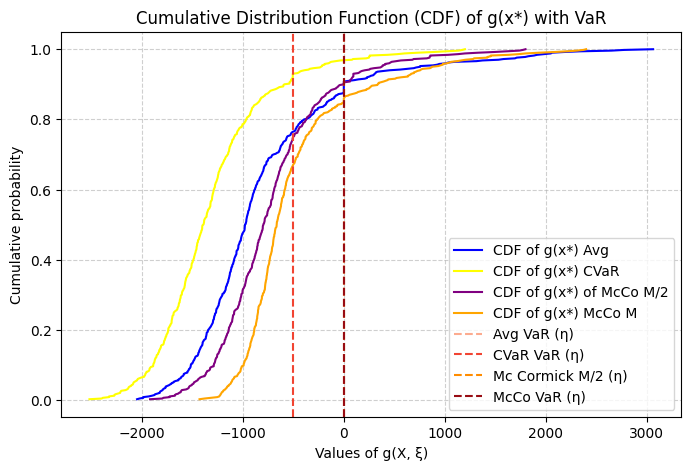

In [406]:
# Cumulative plot of g
g_values1_n500 = calc_g_n(example4_p1_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values4_n500 = calc_g_n(example4_p4_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values7_n500 = calc_g_n(example4_p7_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values7_n500_v2 = calc_g_n(example4_p7_n500_v2, N5l, inflows1_scen_n500, inflows2_scen_n500 )

# Sort values for the cumulative distribution function
g_n500_values1_sorted = np.sort(g_values1_n500)
g_n500_values4_sorted = np.sort(g_values4_n500)
g_n500_values7_sorted_v2 = np.sort(g_values7_n500_v2)
g_n500_values7_sorted = np.sort(g_values7_n500)
cdf_values = np.arange(1, N5l + 1) / N5l  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n500_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) Avg")
plt.plot(g_n500_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n500_values7_sorted_v2, cdf_values, linestyle="-", color="purple", markersize=3, label="CDF of g(x*) of McCo M/2")
plt.plot(g_n500_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*) McCo M ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example4_p1_n500.eta.value, color=colors[0], linestyle='--', label="Avg VaR (η)")
plt.axvline(x=example4_p4_n500.eta.value, color=colors[2], linestyle='--', label="CVaR VaR (η)")
plt.axvline(x=example4_p7_n500_v2.eta.value, color='darkorange', linestyle='--', label="Mc Cormick M/2 (η)")
plt.axvline(x=example4_p7_n500.eta.value, color=colors[4], linestyle='--', label="McCo VaR (η)")

# Plot settings
plt.xlabel("Values of g(X, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig('Example4_n500_McCormick_M.png')
plt.show()

n=10

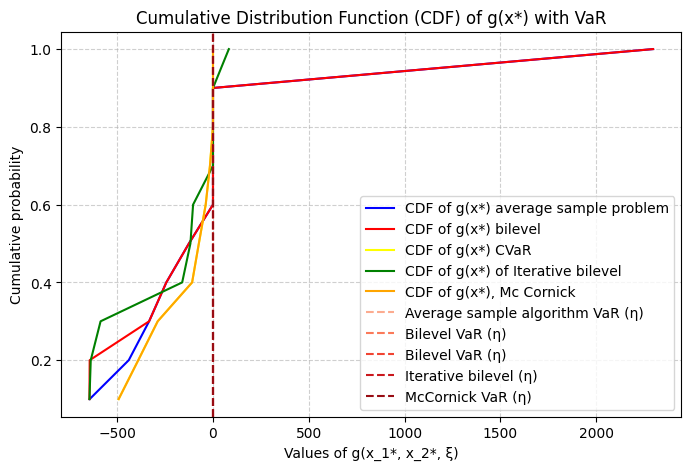

In [171]:
# Cumulative plot of g
g_values1_n10 = calc_g_n(example4_p1_n10, N5s, inflows1_scen_n10, inflows2_scen_n10 )
g_values3_n10 = calc_g_n(example4_p3_n10, N5s, inflows1_scen_n10, inflows2_scen_n10 )
g_values4_n10 = calc_g_n(example4_p4_n10, N5s, inflows1_scen_n10, inflows2_scen_n10 )
g_values5_n10 = calc_g_n(example4_p5_n10, N5s, inflows1_scen_n10, inflows2_scen_n10 )
g_values7_n10 = calc_g_n(example4_p7_n10, N5s, inflows1_scen_n10, inflows2_scen_n10 )

# Sort values for the cumulative distribution function
g_n10_values1_sorted = np.sort(g_values1_n10)
g_n10_values3_sorted = np.sort(g_values3_n10)
g_n10_values4_sorted = np.sort(g_values4_n10)
g_n10_values5_sorted = np.sort(g_values5_n10)
g_n10_values7_sorted = np.sort(g_values7_n10)
cdf_values = np.arange(1, N5s + 1) / N5s  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n10_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) average sample problem")
plt.plot(g_n10_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) bilevel")
plt.plot(g_n10_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n10_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) of Iterative bilevel")
plt.plot(g_n10_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*), Mc Cornick ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example4_p1_n10.eta.value, color=colors[0], linestyle='--', label="Average sample algorithm VaR (η)")
plt.axvline(x=example4_p3_n10.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example4_p4_n10.eta.value, color=colors[2], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example4_p5_n10.eta.value, color=colors[3], linestyle='--', label="Iterative bilevel (η)")
plt.axvline(x=example4_p7_n10.eta.value, color=colors[4], linestyle='--', label="McCornick VaR (η)")

# Plot settings
plt.xlabel("Values of g(x_1*, x_2*, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

n=500

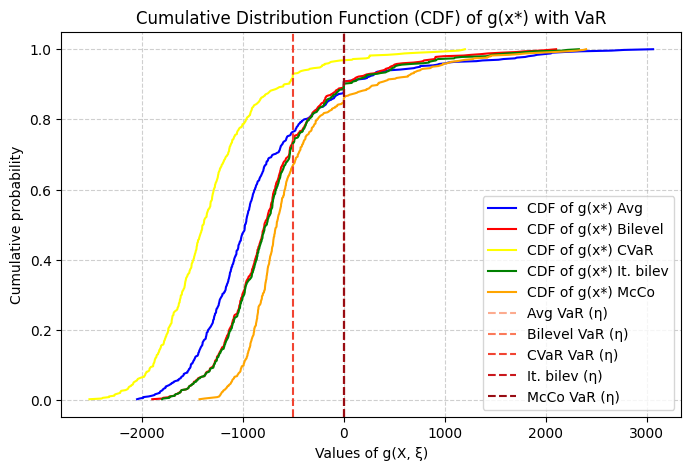

In [408]:
# Cumulative plot of g
g_values1_n500 = calc_g_n(example4_p1_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values3_n500 = calc_g_n(example4_p3_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values4_n500 = calc_g_n(example4_p4_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values5_n500 = calc_g_n(example4_p5_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )
g_values7_n500 = calc_g_n(example4_p7_n500, N5l, inflows1_scen_n500, inflows2_scen_n500 )

# Sort values for the cumulative distribution function
g_n500_values1_sorted = np.sort(g_values1_n500)
g_n500_values3_sorted = np.sort(g_values3_n500)
g_n500_values4_sorted = np.sort(g_values4_n500)
g_n500_values5_sorted = np.sort(g_values5_n500)
g_n500_values7_sorted = np.sort(g_values7_n500)
cdf_values = np.arange(1, N5l + 1) / N5l  # Cumulative fractions by adding one value per solution

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(g_n500_values1_sorted, cdf_values, linestyle="-", color="b", markersize=3, label="CDF of g(x*) Avg")
plt.plot(g_n500_values3_sorted, cdf_values, linestyle="-", color="r", markersize=3, label="CDF of g(x*) Bilevel")
plt.plot(g_n500_values4_sorted, cdf_values, linestyle="-", color="yellow", markersize=3, label="CDF of g(x*) CVaR")
plt.plot(g_n500_values5_sorted, cdf_values, linestyle="-", color="g", markersize=3, label="CDF of g(x*) It. bilev")
plt.plot(g_n500_values7_sorted, cdf_values, linestyle="-", color="orange", markersize=3, label="CDF of g(x*) McCo ")

# Create a color scale from dark red to light red
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 5))  # Adjust the range to control brightness

# Plot the lines with the new colors
plt.axvline(x=example4_p1_n500.eta.value, color=colors[0], linestyle='--', label="Avg VaR (η)")
plt.axvline(x=example4_p3_n500.eta.value, color=colors[1], linestyle='--', label="Bilevel VaR (η)")
plt.axvline(x=example4_p4_n500.eta.value, color=colors[2], linestyle='--', label="CVaR VaR (η)")
plt.axvline(x=example4_p5_n500.eta.value, color=colors[3], linestyle='--', label="It. bilev (η)")
plt.axvline(x=example4_p7_n500.eta.value, color=colors[4], linestyle='--', label="McCo VaR (η)")

# Plot settings
plt.xlabel("Values of g(X, ξ)")
plt.ylabel("Cumulative probability")
plt.title("Cumulative Distribution Function (CDF) of g(x*) with VaR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig('Example4_n500_accum_plot.png')
plt.show()


Plot the inflows of water for each turbine

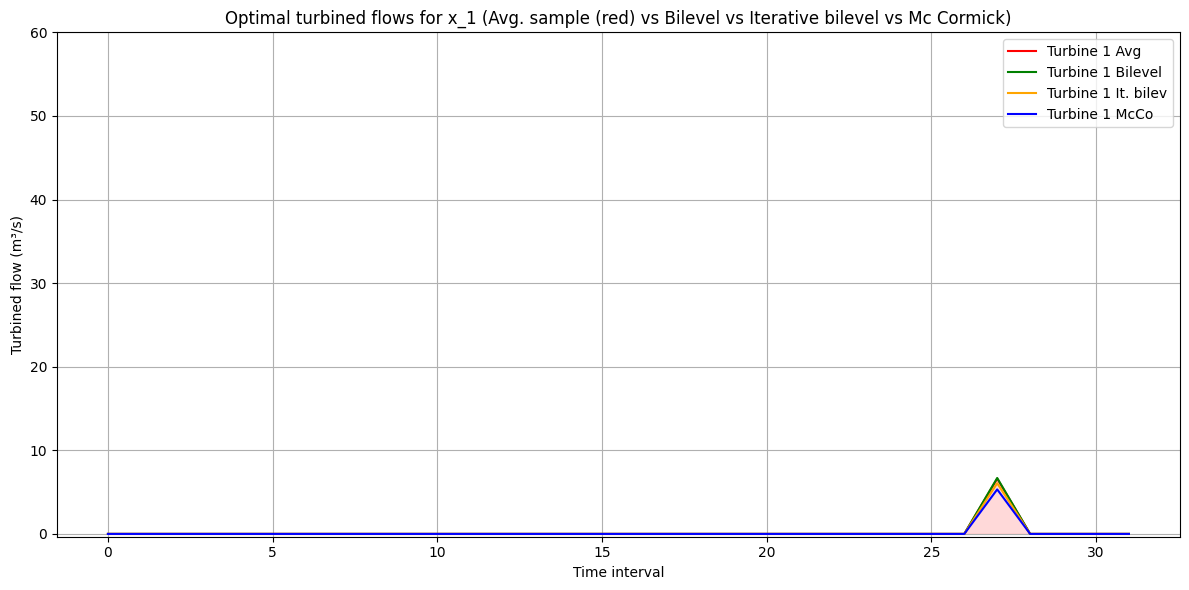

In [56]:
#I create the variable with the iterative bilevel solution for n=500 and Mc Cormick
time = np.arange(32)

X_sol1_n500 = np.empty((3,32))
for t in example4_p1_n500.T:
    for j in example4_p1_n500.J:
        X_sol1_n500[j,t] = example4_p1_n500.x[j,t].value

X_sol3_n500 = np.empty((3,32))
for t in example4_p3_n500.T:
    for j in example4_p3_n500.J:
        X_sol3_n500[j,t] = example4_p3_n500.x[j,t].value
        
X_sol5_n500 = np.empty((3,32))
for t in example4_p5_n500.T:
    for j in example4_p5_n500.J:
        X_sol5_n500[j,t] = example4_p5_n500.x[j,t].value

X_sol7_n500 = np.empty((3,32))
for t in example4_p7_n500.T:
    for j in example4_p7_n500.J:
        X_sol7_n500[j,t] = example4_p7_n500.x[j,t].value
        
    

# Plot the flows for x1 vs average sample
plt.figure(figsize=(12, 6))
plt.plot(time, X_sol1_n500[0], label='Turbine 1 Avg', color='red')
plt.fill_between(time, X_sol1_n500[0], color='red', alpha=0.15)
plt.plot(time, X_sol3_n500[0], label='Turbine 1 Bilevel', color='green')
plt.plot(time, X_sol5_n500[0], label='Turbine 1 It. bilev', color='orange')
plt.plot(time, X_sol7_n500[0], label='Turbine 1 McCo', color='blue')

# Títulos y leyenda
plt.title('Optimal turbined flows for x_1 (Avg. sample (red) vs Bilevel vs Iterative bilevel vs Mc Cormick)')
plt.xlabel('Time interval')
plt.ylabel('Turbined flow (m³/s)')
plt.ylim(top=60)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Flows_turbine1.png')
plt.show()

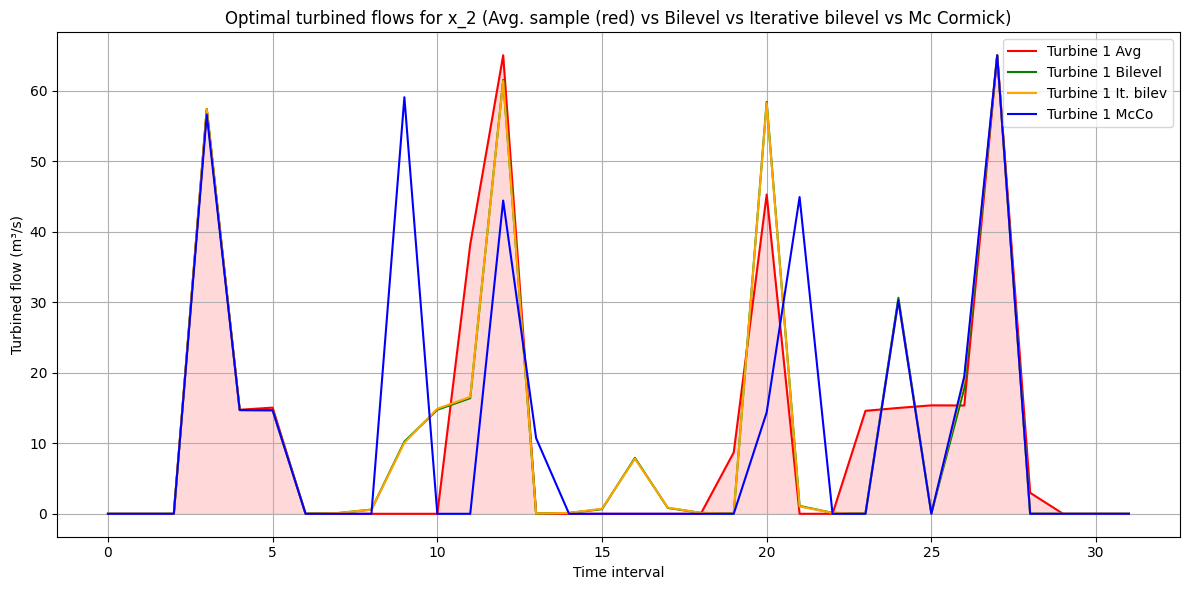

In [ ]:
#I create the variable with the iterative bilevel solution for n=500 and Mc Cormick
# Plot the flows for x1 vs average sample
plt.figure(figsize=(12, 6))
plt.plot(time, X_sol1_n500[1], label='Turbine 1 Avg', color='red')
plt.fill_between(time, X_sol1_n500[1], color='red', alpha=0.15)
plt.plot(time, X_sol3_n500[1], label='Turbine 1 Bilevel', color='green')
plt.plot(time, X_sol5_n500[1], label='Turbine 1 It. bilev', color='orange')
plt.plot(time, X_sol7_n500[1], label='Turbine 1 McCo', color='blue')


# Títulos y leyenda
plt.title('Optimal turbined flows for x_2 (Avg. sample (red) vs Bilevel vs Iterative bilevel vs Mc Cormick)')
plt.xlabel('Time interval')
plt.ylabel('Turbined flow (m³/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Flows_turbine2.png')
plt.show()

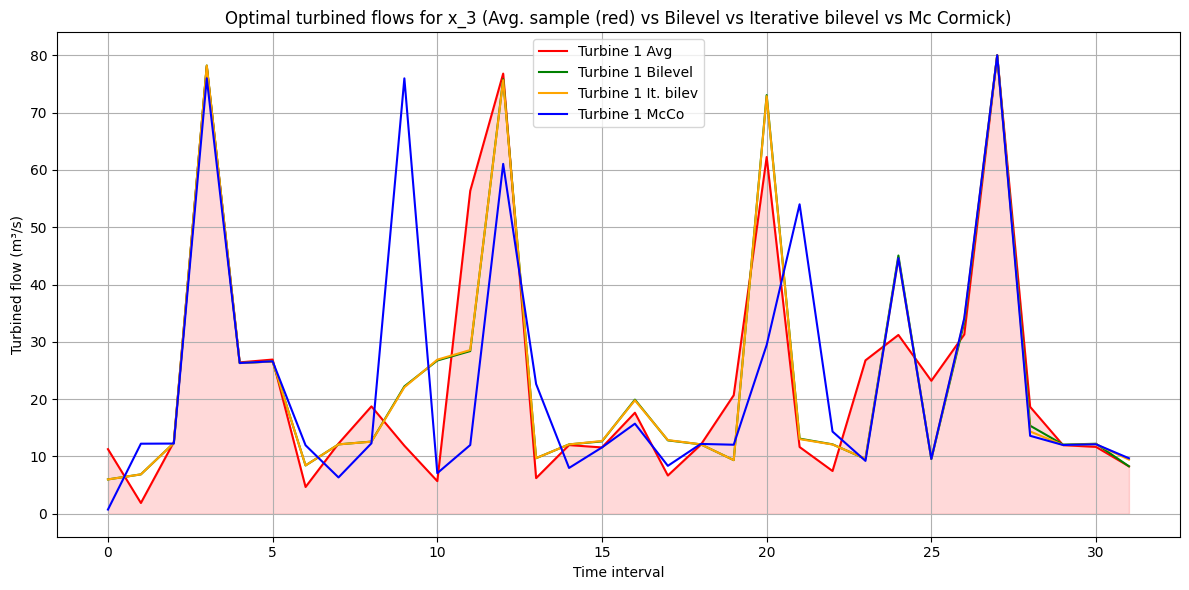

In [411]:
#I create the variable with the iterative bilevel solution for n=500 and Mc Cormick
# Plot the flows for x3 vs average sample
plt.figure(figsize=(12, 6))
plt.plot(time, X_sol1_n500[2], label='Turbine 1 Avg', color='red')
plt.fill_between(time, X_sol1_n500[2], color='red', alpha=0.15)
plt.plot(time, X_sol3_n500[2], label='Turbine 1 Bilevel', color='green')
plt.plot(time, X_sol5_n500[2], label='Turbine 1 It. bilev', color='orange')
plt.plot(time, X_sol7_n500[2], label='Turbine 1 McCo', color='blue')


# Títulos y leyenda
plt.title('Optimal turbined flows for x_3 (Avg. sample (red) vs Bilevel vs Iterative bilevel vs Mc Cormick)')
plt.xlabel('Time interval')
plt.ylabel('Turbined flow (m³/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Flows_turbine3.png')
plt.show()

In [249]:
print("In Mc Cormick the flows sum: ", sum(X_sol7_n500[1]) )

print("In Average Sample the flows sum: ", sum(X_sol1_n500[1]) )


In Mc Cormick the flows sum:  374.16648260941304
In Average Sample the flows sum:  372.60199932678967


# Time and result Comparisons

## Example 1, N=10

In [36]:
#Parameters for example 1 
results_example1_N10 = []

In [37]:
N=10
for j in range(10):
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    # Create and solve model 
    model = create_model1(M=10, N=N, p=p1, simulated_data=sim_data, g_function=g_1, f_function=f_1)

    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value,
        "Status": str(result.solver.status)
    }
    results_example1_N10.append(result_dict)

In [38]:
N=10
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p1, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_1, f_function= f_1)

    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status)
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_1)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_1,
            f_function=f_1
        )

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status)
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel  = bilevel_iteration_loop(max_iterations, tolerance, M=100, p=p1, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, g= g_1, f = f_1)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status)
    }
    
    ############## Mc Cormick ############
    
    g_values = [g_1(x1_ini, x2_ini, sim_data[j,:]) for j in range(N)]
    M = max(g_values)
    
    Dicc_N = compute_g_bounds(g_1,sim_data,N, x1_ini, x2_ini, M)
    model_mc_cormick = create_model7(p= p1, N  = N, simulated_data = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], g_function = g_1, f_function = f_1)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status)
}
    
    results_example1_N10.append(result_dict_cvar)
    results_example1_N10.append(result_dict_bilevel)
    results_example1_N10.append(result_dict_iter_bilevel)
    results_example1_N10.append(result_dict_mc_cormick)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[0]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Los pesos para esta k son: [-0.2  0.8 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2  0.8 -0.2]
Optimal x1: 0.8384335509958168, x2: 3.7748176004517586, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: -4.613251151447575
Iteration 2 with k = 1
Los pesos para esta k son: [-0.2  0.8 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2  0.8 -0.2]
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[0]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[0]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also http

In [39]:
# Convertimos todo en un DataFrame
df_results_example1_N10 = pd.DataFrame(results_example1_N10)

# Opcional: guardarlo como CSV
df_results_example1_N10.to_csv("C:/Users/laull/TFM/resultados_example1_N10.csv", index=False)

N=500

In [132]:
#Parameters for example 1 and example 2
results_example1_N500 = []

In [133]:
N=500
for j in range(10):
    
    print("We are in iteration", j)
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    # Create and solve model 
    model = create_model1(M=10, N=N, p=p1, simulated_data=sim_data, g_function=g_1, f_function=f_1)

    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None , 
        "Status": str(result.solver.status),
        "Sol_x": [model.x[0].value, model.x[1].value]
    }
    results_example1_N500.append(result_dict)

We are in iteration 0
We are in iteration 1
We are in iteration 2
containing a solution
We are in iteration 3
We are in iteration 4
containing a solution
We are in iteration 5
We are in iteration 6
containing a solution
We are in iteration 7
containing a solution
We are in iteration 8
We are in iteration 9


In [134]:
N=500
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p1, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_1, f_function= f_1)

    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status),
        "Sol_x": [model_cvar.x[0].value, model_cvar.x[1].value]
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_1)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_1,
            f_function=f_1
        )

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status),
            "Sol_x": [model_bilevel.x[0].value, model_bilevel.x[1].value]
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop(max_iterations, tolerance, M=100, p=p1, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, g= g_1, f = f_1)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status),
        "Sol_x": [model_iter_bilevel.x[0].value, model_iter_bilevel.x[1].value]
    }
    
    ############## Mc Cormick ############
    
    g_values = [g_1(x1_ini, x2_ini, sim_data[j,:]) for j in range(N)]
    M = max(g_values)
    
    Dicc_N = compute_g_bounds(g_1,sim_data,N, x1_ini, x2_ini, M/2)
    model_mc_cormick = create_model7(p= p1, N  = N, simulated_data = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], g_function = g_1, f_function = f_1)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status),
        "Sol_x": [model_mc_cormick.x[0].value, model_mc_cormick.x[1].value]
}
    
    results_example1_N500.append(result_dict_cvar)
    results_example1_N500.append(result_dict_bilevel)
    results_example1_N500.append(result_dict_iter_bilevel)
    results_example1_N500.append(result_dict_mc_cormick)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[455]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 0.8703209043136222, x2: 3.84084146859155, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: -4.711162372905172
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[455]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[273]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 0.9738703329424632, x2: 3.672206480475137, eta: 0.0
Optimal the

In [135]:
# Convertimos todo en un DataFrame
df_results_example1_N500 = pd.DataFrame(results_example1_N500)

# Opcional: guardarlo como CSV
df_results_example1_N500.to_csv("C:/Users/laull/TFM/resultados_example1_N500.csv", index=False)

Iterations_mc_cormick_ex1 = [2,2,4,2,3,2,2,2,2,2]

We see the percentiles and the probability of satyisfying the condition

In [178]:
rows = []

for idx, row in df_results_example1_N500.iterrows():
    method = row["Method"]
    x1_ini, x2_ini = row["Sol_x"]

    # Simulación correspondiente a esta solución
    np.random.seed(10 + idx)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    g_vals = [g_1(x1_ini, x2_ini, sim_data[k, :]) for k in range(sim_data.shape[0])]

    # Percentil 80 y proporción de satisfacción
    perc80 = np.percentile(g_vals, 80)
    prob_satisf_rest = np.mean(np.array(g_vals) <= 0)

    rows.append({
        "method": method,
        "sol_x": [x1_ini, x2_ini],
        "percentil_80": perc80,
        "prob_satisf_rest": prob_satisf_rest
    })

# Convertimos a DataFrame
percentiles_example1_80 = pd.DataFrame(rows).sort_values(by="method").reset_index(drop=True)
percentiles_example1_80.to_csv("percentiles_example1_80.csv")

In [179]:
percentiles_example1_80


method                                     sol_x  percentil_80  \
0   Average_sample  [1.0257430909137186, 3.6946406262597318]      0.002022   
1   Average_sample   [0.9973547235008262, 3.651300289346711]      0.000764   
2   Average_sample  [1.0366808206073803, 3.6235112564314047]      0.000614   
3   Average_sample    [1.09189743915269, 3.5831227723714507]      0.004162   
4   Average_sample   [1.9815006766398024, 2.718642914998793]      0.000706   
5   Average_sample  [0.8782876134697568, 3.7869344175390087]      0.000642   
6   Average_sample  [0.5777955894235294, 4.0756108538254665]      0.000263   
7   Average_sample   [0.5934341626224892, 4.038925106498305]      0.001967   
8   Average_sample   [0.7610411773590204, 3.907897641974577]      0.000330   
9   Average_sample  [1.2609668496187076, 3.4123975897917176]      0.001178   
10         Bilevel  [1.0845474538958861, 3.5737093876021753]      0.010294   
11         Bilevel   [1.1414734467406737, 3.513607573115318]      0.001161   
12         Bilevel   [0.8293555455673274, 3.833170205764025]     -0.011466   
13         Bilevel     [0.935217637883626, 3.70709204190428]      0.038037   
14         Bilevel  [0.8703541951241224, 3.8408121967713673]      0.025877   
15         Bilevel    [1.112046441310163, 3.525248952671864]     -0.030149   
16         Bilevel    [0.9299830345001396, 3.73662812844802]     -0.031003   
17         Bilevel   [0.8689562194377258, 3.758852482073281]     -0.027560   
18         Bilevel  [1.1964816957687958, 3.4976000868630823]      0.053200   
19         Bilevel  [1.3475157470501253, 3.3159699320084144]      0.026064   
20            CVaR    [1.131954404656353, 3.349598586271561]     -0.189401   
21            CVaR   [0.8040752863621903, 3.671751909663507]     -0.148919   
22            CVaR  [0.8282368552505316, 3.6127092817070388]     -0.188803   
23            CVaR  [1.0620287970693745, 3.3705860537733625]     -0.245378   
24            CVaR   [1.0811605535924889, 3.358504865204241]     -0.244442   
25            CVaR   [1.045885274682619, 3.3842763465949304]     -0.250990   
26            CVaR  [0.9171504043022685, 3.5160761615529563]     -0.211317   
27            CVaR  [0.9022310839996792, 3.5620746263919867]     -0.218570   
28            CVaR  [0.8352289171761995, 3.6575299993820427]     -0.160101   
29            CVaR  [1.2436556222095196, 3.2075027224324293]     -0.178159   
30    Iter_Bilevel   [0.851085968385344, 3.7775273887365617]      0.005608   
31    Iter_Bilevel  [1.0996806936129624, 3.5414282108929163]     -0.019289   
32    Iter_Bilevel   [1.138778780005933, 3.5152370063614735]      0.016259   
33    Iter_Bilevel   [1.2932112330832588, 3.377632137855383]     -0.006320   
34    Iter_Bilevel   [0.8782876134696238, 3.786934417539187]     -0.018421   
35    Iter_Bilevel   [1.196478355399368, 3.4976023995808823]      0.057427   
36    Iter_Bilevel   [0.978466649996984, 3.6909274244108263]     -0.026868   
37    Iter_Bilevel    [1.084563959631587, 3.573690475601258]      0.014130   
38    Iter_Bilevel   [0.9738703329424632, 3.672206480475137]     -0.009804   
39    Iter_Bilevel    [0.8703209043136222, 3.84084146859155]      0.139753   
40      MC_cormick  [1.2156310494214677, 3.5190420906994313]      0.072301   
41      MC_cormick  [1.1299015617395283, 3.5298504762137224]     -0.008460   
42      MC_cormick   [1.2977135978492542, 3.342224757362037]     -0.051426   
43      MC_cormick   [1.0726734806312475, 3.601336654717693]     -0.007261   
44      MC_cormick  [0.8864749976036992, 3.8101771891575127]      0.075163   
45      MC_cormick    [1.014575902413576, 3.632734953483265]      0.008724   
46      MC_cormick   [1.1573110960882997, 3.538398604922248]      0.035457   
47      MC_cormick   [0.9179491451455631, 3.821315069170298]      0.057542   
48      MC_cormick   [0.8502743026919823, 3.864835783705595]      0.066060   
49      MC_cormick   [0.9287985641171559, 3.766835332698016]      0.108916   

    prob_satisf_rest  
0         

In [180]:
# Calcular media y mediana de prob_satisf_rest
summary_prob = percentiles_example1_80.groupby("method")["prob_satisf_rest"].agg(
    mean_prob="mean",
    median_prob="median"
)

# Calcular min, max, media y mediana de percentil_80
summary_perc = percentiles_example1_80.groupby("method")["percentil_80"].agg(
    min_perc="min",
    max_perc="max",
    mean_perc="mean",
    median_perc="median"
)

# Unir ambos resúmenes
df_summary_stats = pd.concat([summary_prob, summary_perc], axis=1).reset_index()
df_summary_stats

method  mean_prob  median_prob  min_perc  max_perc  mean_perc  \
0  Average_sample     0.7996        0.800  0.000263  0.004162   0.001265   
1         Bilevel     0.7958        0.796 -0.031003  0.053200   0.005446   
2            CVaR     0.9144        0.912 -0.250990 -0.148919  -0.203608   
3    Iter_Bilevel     0.7886        0.798 -0.026868  0.139753   0.015248   
4      MC_cormick     0.7722        0.759 -0.051426  0.108916   0.035702   

   median_perc  
0     0.000735  
1     0.005727  
2    -0.200359  
3    -0.000356  
4     0.046500

**Boxplots Example 1 N=500**

C:\Users\laull\AppData\Local\Temp\ipykernel_5740\1414864221.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_Extime.set_xticklabels(names)


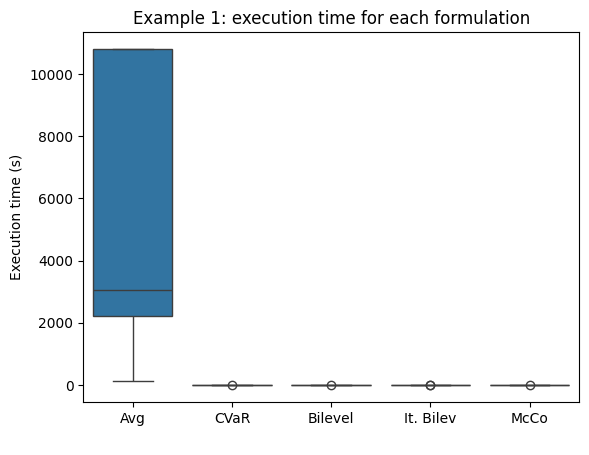

In [43]:
custom_colors = ["#1f77b4",  # dark blue 
                "#ff7f0e",  # orange
                "#2ca02c",  # green
                "#d62728",  # red
                "#9467bd"]  # purple

names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex1_Extime = sns.boxplot(data=df_results_example1_N500, x='Method', y='Execution_time', hue = 'Method', palette = custom_colors)

boxplot_ex1_Extime.set_xticklabels(names)
boxplot_ex1_Extime.set(xlabel=' ', ylabel='Execution time (s)', title= "Example 1: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example1_N500.png")
plt.show()


C:\Users\laull\AppData\Local\Temp\ipykernel_5740\3725019551.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_Extime.set_xticklabels(names)


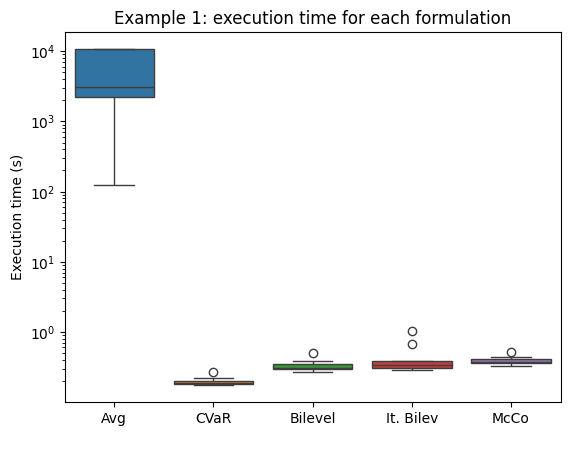

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# Plot
boxplot_ex1_Extime = sns.boxplot(
    data=df_results_example1_N500,
    x='Method',
    y='Execution_time',
    hue='Method',
    palette=custom_colors
)

boxplot_ex1_Extime.set_xticklabels(names)
boxplot_ex1_Extime.set(
    xlabel=' ',
    ylabel='Execution time (s)',
    title="Example 1: execution time for each formulation"
)

# Set y-axis to logarithmic scale
boxplot_ex1_Extime.set_yscale('log')

plt.savefig("C:/Users/laull/TFM/Log_Extime_example1_N500.png")
plt.show()


C:\Users\laull\AppData\Local\Temp\ipykernel_5664\366761597.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_Extime.set_xticklabels(names)


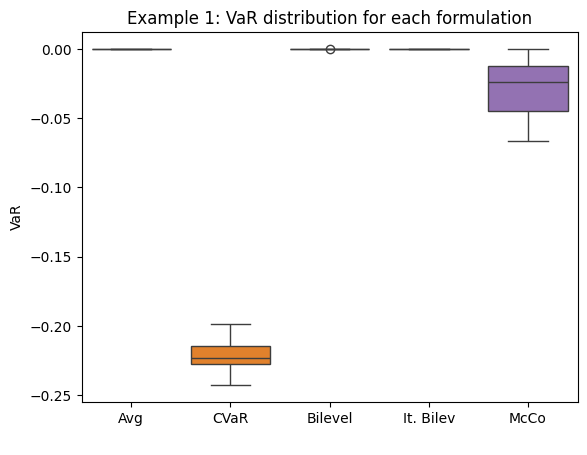

In [414]:
custom_colors = ["#1f77b4",  # dark blue 
                "#ff7f0e",  # orange
                "#2ca02c",  # green
                "#d62728",  # red
                "#9467bd"]  # purple

names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex1_Extime = sns.boxplot(data=df_results_example1_N500, x='Method', y='VaR', hue = 'Method', palette = custom_colors)

boxplot_ex1_Extime.set_xticklabels(names)
boxplot_ex1_Extime.set(xlabel=' ', ylabel='VaR', title= "Example 1: VaR distribution for each formulation")

plt.savefig("C:/Users/laull/TFM/VaRs_example1_N500.png")
plt.show()


In [161]:
df_results_example1_N500.groupby("Method")["Execution_time"].mean()

Method
Average_sample    5560.919459
Bilevel              0.333843
CVaR                 0.196610
Iter_Bilevel         0.433230
MC_cormick           0.390773
Name: Execution_time, dtype: float64

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\2241127521.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_objective.set_xticklabels(names)


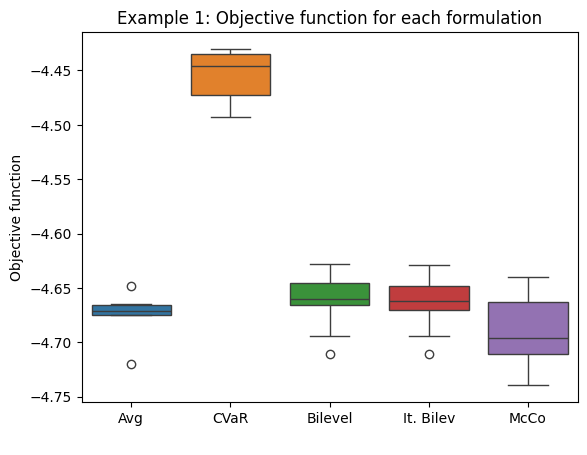

In [415]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex1_objective = sns.boxplot(data=df_results_example1_N500, x='Method', y='Objective_value', hue = 'Method', palette = custom_colors)

boxplot_ex1_objective.set_xticklabels(names)
boxplot_ex1_objective.set(xlabel=' ', ylabel='Objective function', title= "Example 1: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example1_N500.png")
plt.show()

## Example 2, N=10



In [ ]:
results_example2_N10 = []

In [47]:
N=10
for j in range(10):
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    # Create and solve model 
    model = create_model1(M=100, N=N, p=p1, simulated_data=sim_data, g_function=g_2, f_function=f_2)

    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status)
    }
    results_example2_N10.append(result_dict)

In [48]:
N=10	
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p1, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_2, f_function= f_2)

    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status)
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_2)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_2,
            f_function=f_2
        )

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status)
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop(max_iterations, tolerance, M=200, p=p1, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, g= g_2, f = f_2)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status)
    }
    
    ############## Mc Cormick ############
    
    g_values = [g_2(x1_ini, x2_ini, sim_data[j,:]) for j in range(N)]
    M = max(g_values)
    
    Dicc_N = compute_g_bounds(g_2,sim_data,N, x1_ini, x2_ini, M/2)
    model_mc_cormick = create_model7(p= p1, N  = N, simulated_data = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], g_function = g_2, f_function = f_2)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status)
    }
    
    results_example2_N10.append(result_dict_cvar)
    results_example2_N10.append(result_dict_bilevel)
    results_example2_N10.append(result_dict_iter_bilevel)
    results_example2_N10.append(result_dict_mc_cormick)


We are in iteration 0


WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Los pesos para esta k son: [-0.2 -0.2  0.8 -0.2 -0.2  0.8 -0.2 -0.2 -0.2 -0.2]
Optimal x1: 1.4779222485160421, x2: 0.0, eta: 0.0
Optimal theta: 0.0
Objective value in iteration 1: 2.1842541726587137
Iteration 2 with k = 1
Los pesos para esta k son: [-0.2 -0.2  0.8 -0.2 -0.2  0.8 -0.2 -0.2 -0.2 -0.2]
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[9]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[5]' to a numeric value `-0.2000000000000004`
outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/er

In [49]:
# Dataframe creation and save it to csv
df_results_example2_N10 = pd.DataFrame(results_example2_N10)
df_results_example2_N10.to_csv("C:/Users/laull/TFM/resultados_example2_N10.csv", index=False)

N=500

In [ ]:
results_example2_N500 = []
Xs_example2_n500 =  []

In [92]:
N=500
for j in range(10):
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    # Create and solve model 
    model = create_model1(M=100, N=N, p=p1, simulated_data=sim_data, g_function=g_2, f_function=f_2)

    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status),
        "Sol_x": [model.x[0].value, model.x[1].value]
    }
    
    results_example2_N500.append(result_dict)

In [ ]:
N=500	
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p1, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_2, f_function= f_2)

    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status),
        "Sol_x": [model_cvar.x[0].value, model_cvar.x[1].value]
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_2)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_2,
            f_function=f_2
        )

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status),
            "Sol_x": [model_bilevel.x[0].value, model_bilevel.x[1].value]
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop(max_iterations, tolerance, M=200, p=p1, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, g= g_2, f = f_2)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status),
            "Sol_x": [model_iter_bilevel.x[0].value, model_iter_bilevel.x[1].value]
    }
    
    ############## Mc Cormick ############
    
    g_values = [g_2(x1_ini, x2_ini, sim_data[j,:]) for j in range(N)]
    M = max(g_values)
    
    Dicc_N = compute_g_bounds(g_2,sim_data,N, x1_ini, x2_ini, M/2)
    model_mc_cormick = create_model7(p= p1, N  = N, simulated_data = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], g_function = g_2, f_function = f_2)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status),
            "Sol_x": [model_mc_cormick.x[0].value, model_mc_cormick.x[1].value]
    }
    
    results_example2_N500.append(result_dict_cvar)
    results_example2_N500.append(result_dict_bilevel)
    results_example2_N500.append(result_dict_iter_bilevel)
    results_example2_N500.append(result_dict_mc_cormick)


We are in iteration 0
WARNING (W1002): Setting Var 'pi[269]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 1.6116809575706845, x2: 4.0577390643204546e-05, eta: -0.17219540029212513
Optimal theta: 1.220546223889517e-10
Objective value in iteration 1: 2.597515535053408
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[269]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[19]' to a numeric value
`-0.20000000000001705` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 1.6755885120925802, x2: 

In [94]:
# Dataframe creation and save it to csv

df_results_example2_N500 = pd.DataFrame(results_example2_N500)
df_results_example2_N500.to_csv("C:/Users/laull/TFM/resultados_example2_N500.csv", index=False)

Iterations_mc_cormick_ex2 = [2,4,3,4,4,6,3,3,2,3]

We study the 0.8 quantile distribution of the samples:

In [181]:
rows = []

for idx, row in df_results_example2_N500.iterrows():
    method = row["Method"]
    x1_ini, x2_ini = row["Sol_x"]

    # Simulación correspondiente a esta solución
    np.random.seed(10 + idx)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    g_vals = [g_2(x1_ini, x2_ini, sim_data[k, :]) for k in range(sim_data.shape[0])]

    # Percentil 80 y proporción de satisfacción
    perc80 = np.percentile(g_vals, 80)
    prob_satisf_rest = np.mean(np.array(g_vals) <= 0)

    rows.append({
        "method": method,
        "sol_x": [x1_ini, x2_ini],
        "percentil_80": perc80,
        "prob_satisf_rest": prob_satisf_rest
    })

# Convertimos a DataFrame
percentiles_example2_80 = pd.DataFrame(rows).sort_values(by="method").reset_index(drop=True)
percentiles_example2_80.to_csv("percentiles_example2_80.csv")

In [182]:
percentiles_example2_80

method                                         sol_x  \
0   Average_sample                     [1.5469790354682278, 0.0]   
1   Average_sample                     [1.5589577370807914, 0.0]   
2   Average_sample                     [1.5629121062252218, 0.0]   
3   Average_sample                      [1.551951914133846, 0.0]   
4   Average_sample                     [1.5809194821170596, 0.0]   
5   Average_sample                     [1.5641866843976722, 0.0]   
6   Average_sample                     [1.5505252443805606, 0.0]   
7   Average_sample                     [1.5445083477164447, 0.0]   
8   Average_sample                     [1.5566157904689395, 0.0]   
9   Average_sample                     [1.5665041479207589, 0.0]   
10         Bilevel  [1.5629093851669678, -9.261810741070351e-09]   
11         Bilevel    [1.55661369104692, -7.867732506044171e-09]   
12         Bilevel  [1.5641842979924958, -8.064838902797774e-09]   
13         Bilevel  [1.5589556127217696, -7.895635412285475e-09]   
14         Bilevel  [1.5469769600254175, -7.886189893345542e-09]   
15         Bilevel   [1.5505232683189805, -7.82976626253988e-09]   
16         Bilevel  [1.5665021352101938, -7.817396057886482e-09]   
17         Bilevel  [1.5445064603306742, -7.717682403532595e-09]   
18         Bilevel   [1.5809172757283456, -7.94506144009649e-09]   
19         Bilevel  [1.5519499522889186, -7.804417852121659e-09]   
20            CVaR                      [1.716247327567751, 0.0]   
21            CVaR                      [1.677337109933309, 0.0]   
22            CVaR                     [1.6666189622092047, 0.0]   
23            CVaR                     [1.6495747720800709, 0.0]   
24            CVaR                     [1.6710642565603795, 0.0]   
25            CVaR                     [1.6796833391332142, 0.0]   
26            CVaR                      [1.677966427877206, 0.0]   
27            CVaR                     [1.6817241779589251, 0.0]   
28            CVaR                      [1.651286756930569, 0.0]   
29            CVaR                     [1.6672788935115905, 0.0]   
30    Iter_Bilevel                     [1.5445068048419013, 0.0]   
31    Iter_Bilevel                      [1.550524949469631, 0.0]   
32    Iter_Bilevel   [1.5566157920729535, 1.412304154849194e-09]   
33    Iter_Bilevel                     [1.5519503028243242, 0.0]   
34    Iter_Bilevel                     [1.5641831925141447, 0.0]   
35    Iter_Bilevel                     [1.5809113775112358, 0.0]   
36    Iter_Bilevel   [1.5986008987354203, 4.059123566762217e-05]   
37    Iter_Bilevel                     [1.5629116080356027, 0.0]   
38    Iter_Bilevel                     [1.5589562447179657, 0.0]   
39    Iter_Bilevel  [1.6116809575706845, 4.0577390643204546e-05]   
40      MC_cormick   [1.5928570280134609, 3.147936189237433e-09]   
41      MC_cormick  [1.5436547659512618, 1.5361576427217018e-09]   
42      MC_cormick   [1.5698860721904329, 3.408667104992312e-09]   
43      MC_cormick   [1.572767313390018, 3.3000125556392406e-09]   
44      MC_cormick  [1.5467187347255895, 3.3416790543274538e-09]   
45      MC_cormick   [1.5576359846339294, 3.047318117086929e-09]   
46      MC_cormick  [1.5924162993598983, 3.7142892464706186e-09]   
47      MC_cormick    [1.5460484128007004, 1.53597908615294e-09]   
48      MC_cormick  [1.5608098544611477, 1.5342925204723683e-09]   
49      MC_cormick   [1.5663260365111613, 3.270608458964363e-09]   

    percentil_80  prob_satisf_rest  
0       0.000041             0.798  
1       0.000435             0.798  
2       0.000804             0.798  
3       0.000924             0.798  
4       0.001071             0.800  
5       0.000763             0.798  
6       0.001317             0.798  
7       0.001197             0.798  
8       0.000082             0.798  
9       0.001108             0.798  
10     -0.022167             0.820  
11      0.049444             0.772  
12      0.000773             0.800  
13     -0.048995         

In [183]:
# Calcular media y mediana de prob_satisf_rest
summary_prob_ex2 = percentiles_example2_80.groupby("method")["prob_satisf_rest"].agg(
    mean_prob="mean",
    median_prob="median"
)

# Calcular min, max, media y mediana de percentil_80
summary_perc_ex2 = percentiles_example2_80.groupby("method")["percentil_80"].agg(
    min_perc="min",
    max_perc="max",
    mean_perc="mean",
    median_perc="median"
)

# Unir ambos resúmenes
df_summary_stats_ex2 = pd.concat([summary_prob_ex2, summary_perc_ex2], axis=1).reset_index()
df_summary_stats_ex2

method  mean_prob  median_prob  min_perc  max_perc  mean_perc  \
0  Average_sample     0.7982        0.798  0.000041  0.001317   0.000774   
1         Bilevel     0.8008        0.796 -0.064528  0.056548   0.000342   
2            CVaR     0.9250        0.926 -0.394310 -0.274754  -0.334152   
3    Iter_Bilevel     0.8172        0.814 -0.188673  0.046130  -0.040713   
4      MC_cormick     0.8072        0.804 -0.098940  0.045551  -0.013784   

   median_perc  
0     0.000864  
1     0.005409  
2    -0.319477  
3    -0.021607  
4    -0.011226

**Boxplots** Example 2 N=500

C:\Users\laull\AppData\Local\Temp\ipykernel_5740\1572093885.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex2_Extime.set_xticklabels(names)


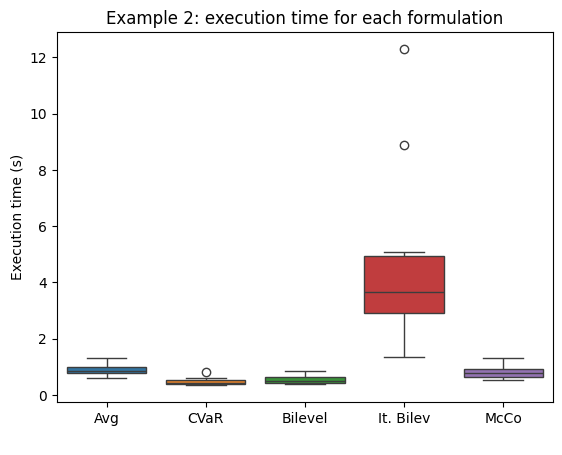

In [46]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex2_Extime = sns.boxplot(data=df_results_example2_N500, x='Method', y='Execution_time', hue= 'Method', palette=custom_colors)

boxplot_ex2_Extime.set_xticklabels(names)
boxplot_ex2_Extime.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 2: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example2_N500.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5740\3838029096.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex2_Extime.set_xticklabels(names)


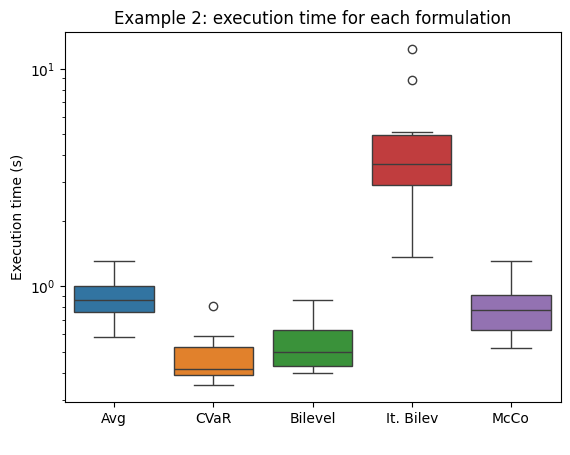

In [49]:

#Plot
boxplot_ex2_Extime = sns.boxplot(data=df_results_example2_N500, x='Method', y='Execution_time', hue = 'Method', palette = custom_colors)

boxplot_ex2_Extime.set_xticklabels(names)
boxplot_ex2_Extime.set(xlabel=' ', ylabel='Execution time (s)', title= "Example 2: execution time for each formulation")

# Set y-axis to logarithmic scale
boxplot_ex2_Extime.set_yscale('log')

plt.savefig("C:/Users/laull/TFM/Log_Extime_example2_N500.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3875757357.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_Extime.set_xticklabels(names)


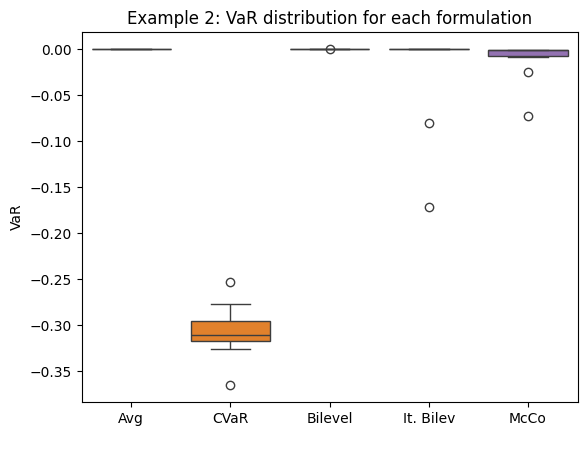

In [418]:
custom_colors = ["#1f77b4",  # dark blue 
                "#ff7f0e",  # orange
                "#2ca02c",  # green
                "#d62728",  # red
                "#9467bd"]  # purple

names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex1_Extime = sns.boxplot(data=df_results_example2_N500, x='Method', y='VaR', hue = 'Method', palette = custom_colors)

boxplot_ex1_Extime.set_xticklabels(names)
boxplot_ex1_Extime.set(xlabel=' ', ylabel='VaR', title= "Example 2: VaR distribution for each formulation")

plt.savefig("C:/Users/laull/TFM/VaRs_example2_N500.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\1167667730.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex2_objective.set_xticklabels(names)


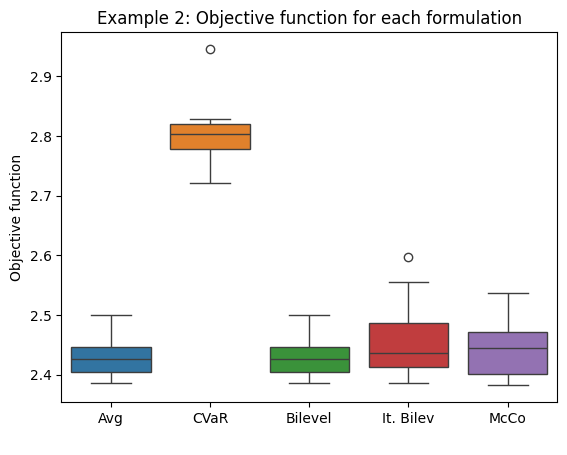

In [419]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# plot
boxplot_ex2_objective = sns.boxplot(
    data=df_results_example2_N500,
    x='Method',
    y='Objective_value',
    hue='Method',
    palette=custom_colors
)

boxplot_ex2_objective.set_xticklabels(names)
boxplot_ex2_objective.set( xlabel = " ", ylabel='Objective function', title= "Example 2: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example2_N500.png")
plt.show()

**Bilevel comparisons**:
N=1000  

In [208]:
results_example2_N1000 = []
N=1000	

for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)
    
    #### Initialization values: the solution is around (1.54, 0). We start from (1.2,0.1) and (5,2)

    #Next algorithms
    #Initialization step
    x1_ini = 1.3
    x2_ini = 0.1
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_2)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_2,
            f_function=f_2
        )

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status)
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Bilevel, worse initial values ################
    
    #Initialization step
    x1_ini = 5
    x2_ini = 2
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_2)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel_worse = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_2,
            f_function=f_2
        )

        start_time = time.time()
        result_bilevel_worse = opt2.solve(model_bilevel_worse)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel_worse = {
            "Method": "Bilevel worse",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel_worse.Objective) if result_bilevel_worse.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel_worse.eta.value if result_bilevel_worse.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel_worse.solver.status)
        }

    except Exception as e:
        result_dict_bilevel_worse = {
            "Method": "Bilevel worse",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    results_example2_N1000.append(result_dict_bilevel)
    results_example2_N1000.append(result_dict_bilevel_worse)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[386]' to a numeric value
`-0.20000000000004547` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `0.6907991704597645` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1002): Setting Var 'pi[656]' to a numeric value
`-0.20000000000004547` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[667]' to a numeric value
`-0.20000000000004547` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1001): Setting Var 'eta' to a value `0.6962586765726928` (float64)
not in domain NonPositiveReals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
W

In [209]:
df_results_example2_N1000 = pd.DataFrame(results_example2_N1000)
df_results_example2_N1000.to_csv("C:/Users/laull/TFM/resultados_example2_N1000.csv", index=False)

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3820117391.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex2_objective.set_xticklabels(names)


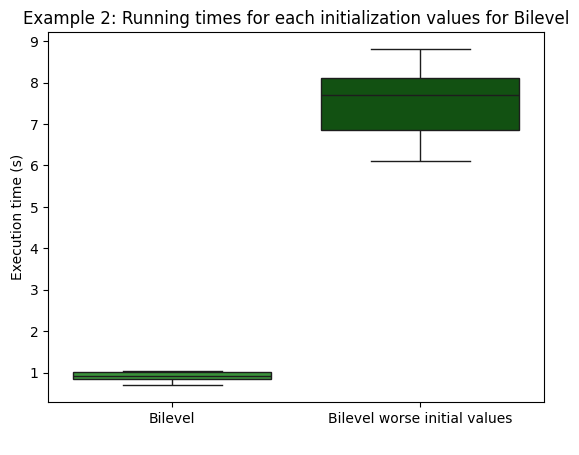

In [ ]:
custom_colors2 = [ "#2ca02c",  "#075b07"]  
# Names
names = [ 'Bilevel',  'Bilevel worse initial values']

# plot
boxplot_ex2_objective = sns.boxplot(
    data=df_results_example2_N1000,
    x='Method',
    y='Execution_time',
    hue='Method',
    palette=custom_colors2
)

boxplot_ex2_objective.set_xticklabels(names)(1.2,0.1) and (5,2)
boxplot_ex2_objective.set( xlabel = " ", ylabel='Execution time (s)', title= "Example 2: Running times for each initialization values for Bilevel")

plt.savefig("C:/Users/laull/TFM/Extime_example2_N1000_bilevel.png")
plt.show()

N=1000 (general)

In [250]:
results_example2_N1000 = []

In [253]:
N=1000
for j in range(10):
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data = np.column_stack((
        np.random.normal(mean[0], std_dev[0], N),
        np.random.normal(mean[1], std_dev[1], N)
    ))

    # Create and solve model 
    model = create_model1(M=100, N=N, p=p1, simulated_data=sim_data, g_function=g_2, f_function=f_2)

    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status)
    }
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p1, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_2, f_function= f_2)

    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status)
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values(x1=x1_ini, x2=x2_ini, sim_matrix=sim_data, p=p1, N=N, g=g_2)
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3(
            p=p1,
            matrix_xi=sim_data,
            x_ini=x_ini_dict,
            u_ini=u_ini_dict,
            v_ini=v_ini_dict,
            pi_ini=pi_ini_dict,
            eta_ini=eta_ini,
            N=N,
            g_function=g_2,
            f_function=f_2
        )

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status)
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop(max_iterations, tolerance, M=200, p=p1, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, g= g_2, f = f_2)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status)
    }
    
    ############## Mc Cormick ############
    
    g_values = [g_2(x1_ini, x2_ini, sim_data[j,:]) for j in range(N)]
    M = max(g_values)
    
    Dicc_N = compute_g_bounds(g_2,sim_data,N, x1_ini, x2_ini, M/2)
    model_mc_cormick = create_model7(p= p1, N  = N, simulated_data = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], g_function = g_2, f_function = f_2)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status)
    }
    
    results_example2_N1000.append(result_dict)
    results_example2_N1000.append(result_dict_cvar)
    results_example2_N1000.append(result_dict_bilevel)
    results_example2_N1000.append(result_dict_iter_bilevel)
    results_example2_N1000.append(result_dict_mc_cormick)


WARNING (W1002): Setting Var 'pi[742]' to a numeric value
`-0.20000000000004547` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 1.5798164639482772, x2: 4.05924732194761e-05, eta: -0.08343957983512656
Optimal theta: 8.265248863976994e-10
Objective value in iteration 1: 2.4958202267147644
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[742]' to a numeric value
`-0.20000000000004547` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'pi[346]' to a numeric value
`-0.20000000000004547` outside the bounds (-0.19999999999999996, 0.8).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 1.6111111887445058, x2: 0.0, eta: -0.15574799575438658
Optimal theta

In [254]:
df_results_example2_N1000 = pd.DataFrame(results_example2_N1000)
df_results_example2_N1000.to_csv("C:/Users/laull/TFM/resultados_example2_N1000.csv", index=False)


C:\Users\laull\AppData\Local\Temp\ipykernel_5664\2365571809.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex3_Extime.set_xticklabels(names)


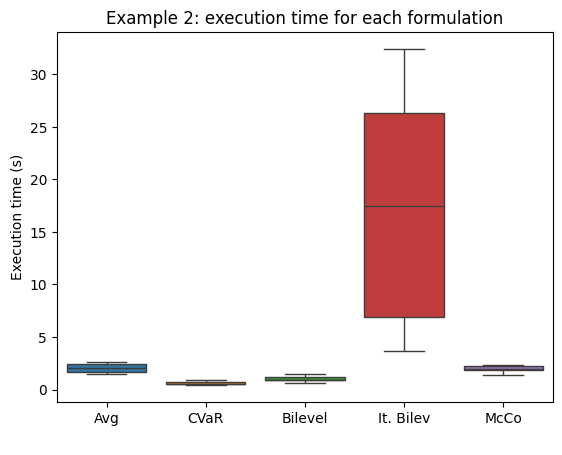

In [420]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex3_Extime = sns.boxplot(data=df_results_example2_N1000, x='Method', y='Execution_time', hue= 'Method', palette=custom_colors)

boxplot_ex3_Extime.set_xticklabels(names)
boxplot_ex3_Extime.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 2: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example2_N1000.png")
plt.show()


C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3721766021.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex2_objective.set_xticklabels(names)


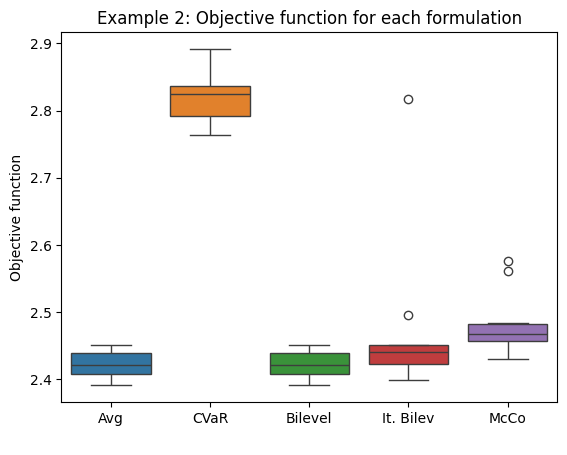

In [421]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# plot
boxplot_ex2_objective = sns.boxplot(
    data=df_results_example2_N1000,
    x='Method',
    y='Objective_value',
    hue='Method',
    palette=custom_colors
)

boxplot_ex2_objective.set_xticklabels(names)
boxplot_ex2_objective.set( xlabel = " ", ylabel='Objective function', title= "Example 2: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example2_N1000.png")
plt.show()

## Example 3

N=500

In [97]:
results_example3_N500 = []

In [101]:
N=500
for j in range(10):
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data =  np.column_stack((
    np.random.uniform(1, 4, N),  # First column between 1 and 4
    np.random.uniform(1/3, 1, N)  # Second column between 1/3 and 1
	))

    # Create and add restrictions for g_3b
    model = create_model1(M=50, N=N, p=p3, simulated_data=sim_data, g_function=g_3a, f_function=f_3)

    model.g_v2 = Expression(model.J, rule=lambda model, j: g_3b(model.x[0], model.x[1], sim_data[j, :]))
    model.prob_v2 = Constraint(model.J, rule=lambda model, j: model.g_v2[j] - model.eta <= M * (1 - model.y[j]))

	#Solve it
    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status),
        "Sol_x": [model.x[0].value, model.x[1].value]
    }
    results_example3_N500.append(result_dict)

In [ ]:
N=500	
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    sim_data =  np.column_stack((
    np.random.uniform(1, 4, N),  # First column between 1 and 4
    np.random.uniform(1/3, 1, N)  # Second column between 1/3 and 1
	))
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p3, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_3a, f_function= f_3)

    model_cvar.g_v2 = Expression(model_cvar.J, rule=lambda model_cvar, j: g_3b(model_cvar.x[0], model_cvar.x[1], sim_data[j, :]))
    model_cvar.prob_v2  =  Constraint(model_cvar.J, rule=lambda model_cvar, j: model_cvar.g_v2[j] - model_cvar.eta <= model_cvar.v[j])


    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status),
        "Sol_x": [model_cvar.x[0].value, model_cvar.x[1].value]
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values_2gs(x1_ini, x2_ini, sim_data, p3, N, g_3a, g_3b )
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    g_ini_dict = {j: resultado["g_ini"][j] for j in range(N)}
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3_2gs(p = p3, matrix_xi = sim_data, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict, eta_ini =eta_ini, N = N, ga_function = g_3a, gb_function = g_3b, f_function = f_3) 
        

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status),
            "Sol_x": [model_bilevel.x[0].value, model_bilevel.x[1].value]
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop3(max_iterations, tolerance, M=100, p=p3, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, ga= g_3a, gb = g_3b, f = f_3)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status),
        "Sol_x": [model_iter_bilevel.x[0].value, model_iter_bilevel.x[1].value]
    }
    
    ############## Mc Cormick ############
    
    M = max(resultado["g_ini"])
    
    Dicc_N = compute_g_bounds(g_3max,sim_data,N, x1_ini, x2_ini, M/2)
	
    model_mc_cormick = create_model7_2gs(p= p3, N  = N, matriz_xi = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], ga_function = g_3a, gb_function = g_3b, f_function = f_3)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status),
        "Sol_x": [model_mc_cormick.x[0].value, model_mc_cormick.x[1].value]
    }
    
    results_example3_N500.append(result_dict_cvar)
    results_example3_N500.append(result_dict_bilevel)
    results_example3_N500.append(result_dict_iter_bilevel)
    results_example3_N500.append(result_dict_mc_cormick)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[192]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 3.3719601086565807, x2: 2.8482808468063294, eta: 9.090909090618954e-09
Optimal theta: -9.990841292334356e-09
Objective value in iteration 1: 6.220239956378781
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[192]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[274]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 3.351903835067174, x2: 2.

In [111]:
# Dataframe creation and save it to csv
df_results_example3_N500 = pd.DataFrame(results_example3_N500)
df_results_example3_N500.to_csv("C:/Users/laull/TFM/resultados_example3_N500.csv", index=False)

Iterations_mc_cormick_ex3 = [2,2,2,2,2,2,2,2,2,2]

We compute the percentil for each method and the probability of satyisfying the restriction:

In [184]:
rows = []

for idx, row in df_results_example3_N500.iterrows():
    method = row["Method"]
    x1_ini, x2_ini = row["Sol_x"]

    # Simulación correspondiente a esta solución
    np.random.seed(10 + idx)
    sim_data =  np.column_stack((
    np.random.uniform(1, 4, N),  # First column between 1 and 4
    np.random.uniform(1/3, 1, N)  # Second column between 1/3 and 1
	))

    g_vals = [g_3max(x1_ini, x2_ini, sim_data[k, :]) for k in range(sim_data.shape[0])]

    # Percentil 80 y proporción de satisfacción
    perc90 = np.percentile(g_vals, 90)
    prob_satisf_rest = np.mean(np.array(g_vals) <= 0)

    rows.append({
        "method": method,
        "sol_x": [x1_ini, x2_ini],
        "percentil_90": perc90,
        "prob_satisf_rest": prob_satisf_rest
    })

# Convertimos a DataFrame
percentiles_example3_80 = pd.DataFrame(rows).sort_values(by="method").reset_index(drop=True)
percentiles_example3_80.to_csv("percentiles_example3_80.csv")

In [185]:
percentiles_example3_80

method                                     sol_x  percentil_90  \
0   Average_sample    [3.209361570270049, 2.923083154788559]      0.000284   
1   Average_sample   [3.062346099010891, 2.9712319582684676]      0.006184   
2   Average_sample   [3.036365226847163, 2.9869782419079067]      0.000722   
3   Average_sample   [3.1229257187758077, 2.951877377023359]      0.000219   
4   Average_sample   [3.011075326451566, 2.9947896220745642]      0.001078   
5   Average_sample  [3.2878304146990183, 2.8976026720798824]      0.002878   
6   Average_sample    [3.1448300775063323, 2.94643873387595]      0.001776   
7   Average_sample  [3.0979759573725882, 2.9632507283912073]      0.000227   
8   Average_sample   [3.213133561639879, 2.9258902755038854]      0.000944   
9   Average_sample   [3.1817647857767524, 2.935958617200132]      0.001115   
10         Bilevel   [3.207413821920665, 2.8739564786162846]      0.061976   
11         Bilevel    [3.496371524783775, 2.799543949673981]     -0.067456   
12         Bilevel    [3.417437643059315, 2.839487754159715]     -0.032212   
13         Bilevel  [3.4190874459057787, 2.7769585048477317]      0.023708   
14         Bilevel   [3.3387808760827062, 2.863819165217675]     -0.010456   
15         Bilevel   [3.414659780785748, 2.8110222364047095]     -0.016579   
16         Bilevel     [3.316367867389338, 2.86103799201016]     -0.019670   
17         Bilevel    [3.305995571410956, 2.873440633778981]      0.009312   
18         Bilevel   [3.239810340769633, 2.8672755194589037]      0.004457   
19         Bilevel  [3.3295639071321625, 2.8523786580834143]     -0.024873   
20            CVaR     [3.243913618134908, 3.16930018181553]     -0.296446   
21            CVaR    [3.4190119464630016, 3.17149513067875]     -0.367648   
22            CVaR   [3.3103237269827233, 3.189220394284868]     -0.335799   
23            CVaR   [3.448082884395578, 3.0472567395887444]     -0.311843   
24            CVaR   [3.4943416003104293, 3.124306130942257]     -0.349369   
25            CVaR    [3.242988496593406, 3.280807268391958]     -0.369094   
26            CVaR   [3.4157178450789716, 3.082027377393662]     -0.239594   
27            CVaR     [3.32303283338954, 3.177081422881066]     -0.319759   
28            CVaR   [3.3671671271092167, 3.199145634113896]     -0.356964   
29            CVaR    [3.332238826236619, 3.199187600983673]     -0.383706   
30    Iter_Bilevel     [3.31149342307691, 2.870519685344555]     -0.009731   
31    Iter_Bilevel   [3.456734836855413, 2.7905387423380694]      0.082113   
32    Iter_Bilevel   [3.4142822793717795, 2.829415655345854]     -0.018949   
33    Iter_Bilevel  [3.3329301433686767, 2.8506003674238465]      0.032928   
34    Iter_Bilevel   [3.4174435530299396, 2.839485752098468]     -0.021112   
35    Iter_Bilevel    [3.23981205065827, 2.8672749186039996]      0.024081   
36    Iter_Bilevel     [3.351795453733884, 2.82291886376824]      0.048640   
37    Iter_Bilevel     [3.24341509238342, 2.860928386123975]      0.081043   
38    Iter_Bilevel    [3.351903835067174, 2.803894821323237]     -0.001912   
39    Iter_Bilevel  [3.3719601086565807, 2.8482808468063294]      0.005074   
40      MC_cormick  [3.2439136181349073, 2.9044881611993723]     -0.089165   
41      MC_cormick   [3.447851024235308, 2.7953672865316883]     -0.031349   
42      MC_cormick    [3.33223882623662, 2.9649609626850033]     -0.154594   
43      MC_cormick    [3.242988496593405, 3.053695153352127]     -0.164766   
44      MC_cormick   [3.3103237269827233, 2.949941814847341]     -0.074943   
45      MC_cormick  [3.4157178450789707, 2.8465992555982527]     -0.034339   
46      MC_cormick    [3.49434160031043, 2.9604537434158464]     -0.198785   
47      MC_cormick  [3.3671671271092163, 2.9911895636546237]     -0.180385   
48      MC_cormick    [3.419011946463004, 2.974157393785454]     -0.182094   
49      MC_cormick  [3.3230328333895396, 2.9505879995541995]     -0.111814   

    prob_satisf_rest  
0         

Boxplots Example 3 N=500


C:\Users\laull\AppData\Local\Temp\ipykernel_5740\3209278496.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex3_Extime.set_xticklabels(names)


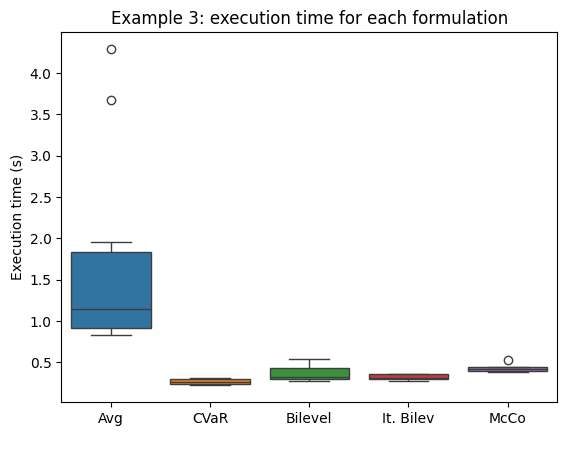

In [186]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex3_Extime = sns.boxplot(data=df_results_example3_N500, x='Method', y='Execution_time', hue= 'Method', palette=custom_colors)

boxplot_ex3_Extime.set_xticklabels(names)
boxplot_ex3_Extime.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 3: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example3_N500.png")
plt.show()


C:\Users\laull\AppData\Local\Temp\ipykernel_5664\1872524819.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex3_objective.set_xticklabels(names)


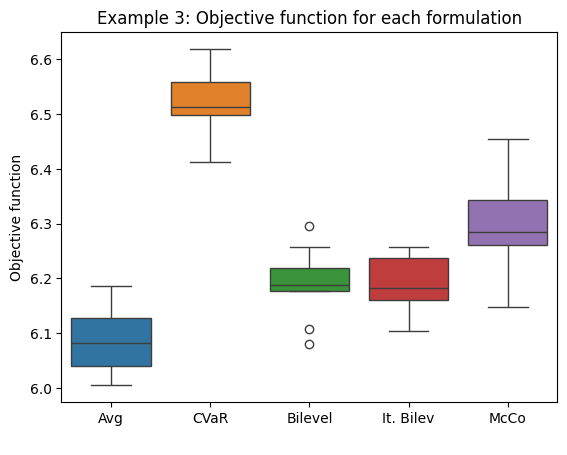

In [423]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  

# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# plot
boxplot_ex3_objective = sns.boxplot(
    data=df_results_example3_N500,
    x='Method',
    y='Objective_value',
    hue='Method',
    palette=custom_colors
)

boxplot_ex3_objective.set_xticklabels(names)
boxplot_ex3_objective.set( xlabel = " ", ylabel='Objective function', title= "Example 3: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example3_N500.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3682061698.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_Extime.set_xticklabels(names)


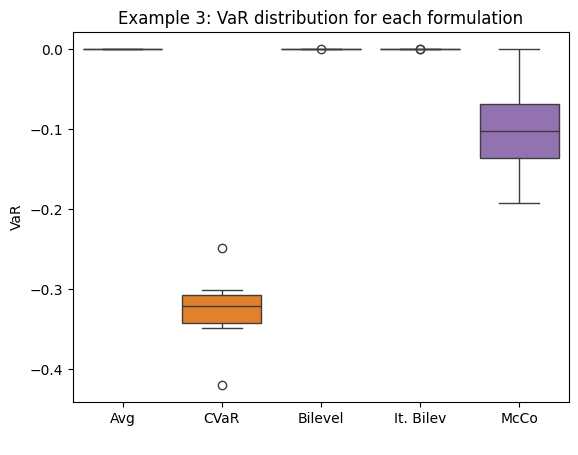

In [424]:
custom_colors = ["#1f77b4",  # dark blue 
                "#ff7f0e",  # orange
                "#2ca02c",  # green
                "#d62728",  # red
                "#9467bd"]  # purple

names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex1_Extime = sns.boxplot(data=df_results_example3_N500, x='Method', y='VaR', hue = 'Method', palette = custom_colors)

boxplot_ex1_Extime.set_xticklabels(names)
boxplot_ex1_Extime.set(xlabel=' ', ylabel='VaR', title= "Example 3: VaR distribution for each formulation")

plt.savefig("C:/Users/laull/TFM/VaRs_example3_N500.png")
plt.show()

N=1000

In [257]:
results_example3_N1000 = []

In [ ]:
N=1000
for j in range(10):
    
    print(f"We are in iteration {j}")
        
    # Create data simulation
    np.random.seed(10 + j)
    sim_data =  np.column_stack((
    np.random.uniform(1, 4, N),  # First column between 1 and 4
    np.random.uniform(1/3, 1, N)  # Second column between 1/3 and 1
	))

    # Create and add restrictions for g_3b
    model = create_model1(M=50, N=N, p=p3, simulated_data=sim_data, g_function=g_3a, f_function=f_3)

    model.g_v2 = Expression(model.J, rule=lambda model, j: g_3b(model.x[0], model.x[1], sim_data[j, :]))
    model.prob_v2 = Constraint(model.J, rule=lambda model, j: model.g_v2[j] - model.eta <= M * (1 - model.y[j]))

	#Solve it
    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status)
    }
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4(p = p3, matrix_xi= sim_data, x_ini = {0: 1.0, 1: 1.0}, v_ini = 1.0, eta_ini = -1.0, probs = probabilities_model,
                            N=N, g_function=g_3a, f_function= f_3)

    model_cvar.g_v2 = Expression(model_cvar.J, rule=lambda model_cvar, j: g_3b(model_cvar.x[0], model_cvar.x[1], sim_data[j, :]))
    model_cvar.prob_v2  =  Constraint(model_cvar.J, rule=lambda model_cvar, j: model_cvar.g_v2[j] - model_cvar.eta <= model_cvar.v[j])


    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status)
    }
    
    #Next algorithms
    #Initialization step
    x1_ini = model_cvar.x[0].value
    x2_ini = model_cvar.x[1].value
    resultado = initialize_values_2gs(x1_ini, x2_ini, sim_data, p3, N, g_3a, g_3b )
    x_ini_dict = {0: x1_ini , 1: x2_ini}  
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(N)}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(N)}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(N)} 
    g_ini_dict = {j: resultado["g_ini"][j] for j in range(N)}
    eta_ini = resultado["eta_ini"] 

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3_2gs(p = p3, matrix_xi = sim_data, x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict, eta_ini =eta_ini, N = N, ga_function = g_3a, gb_function = g_3b, f_function = f_3) 
        

        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status)
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop3(max_iterations, tolerance, M=100, p=p3, matrix_xi = sim_data, num_scen=N, x1_v0=x1_ini, x2_v0=x2_ini, ga= g_3a, gb = g_3b, f = f_3)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status)
    }
    
    ############## Mc Cormick ############
    
    M = max(resultado["g_ini"])
    
    Dicc_N = compute_g_bounds(g_3max,sim_data,N, x1_ini, x2_ini, M/2)
	
    model_mc_cormick = create_model7_2gs(p= p3, N  = N, matriz_xi = sim_data, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini= v_ini_dict, eta_ini = eta_ini, pi_ini= pi_ini_dict, g_LO =  Dicc_N["g_lo"], g_UP = Dicc_N["g_up"], ga_function = g_3a, gb_function = g_3b, f_function = f_3)

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status)
    }
    
    results_example3_N1000.append(result_dict)
    results_example3_N1000.append(result_dict_cvar)
    results_example3_N1000.append(result_dict_bilevel)
    results_example3_N1000.append(result_dict_iter_bilevel)
    results_example3_N1000.append(result_dict_mc_cormick)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[146]' to a numeric value
`-0.10000000000002274` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 3.3336332761195986, x2: 2.861688334422919, eta: 7.494096438125727e-09
Optimal theta: -9.974756162937379e-09
Objective value in iteration 1: 6.195320613066902
Iteration 2 with k = 1
Terminating: π vector matches a previously generated vector.
Algorithm completed.
WARNING (W1002): Setting Var 'pi[146]' to a numeric value
`-0.10000000000002274` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[324]' to a numeric value
`-0.10000000000002274` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal x1: 3.224911203492058, x2: 2.8

In [260]:
# Dataframe creation and save it to csv
df_results_example3_N1000 = pd.DataFrame(results_example3_N1000)
df_results_example3_N1000.to_csv("C:/Users/laull/TFM/resultados_example3_N1000.csv", index=False)


Boxplots Example 3 N=1000

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\1596633048.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex3_Extime.set_xticklabels(names)


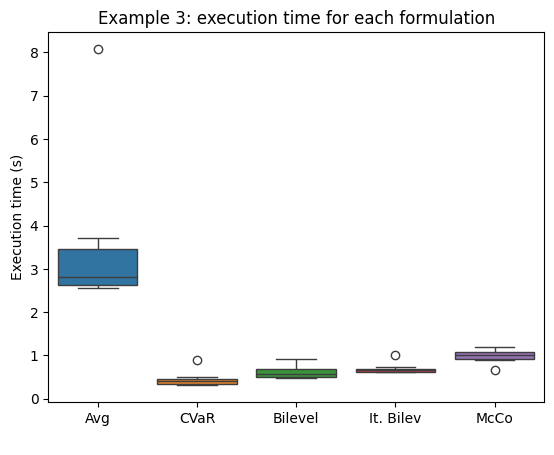

In [425]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex3_Extime = sns.boxplot(data=df_results_example3_N1000, x='Method', y='Execution_time', hue= 'Method', palette=custom_colors)

boxplot_ex3_Extime.set_xticklabels(names)
boxplot_ex3_Extime.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 3: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example3_N1000.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\1263243333.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex3_objective.set_xticklabels(names)


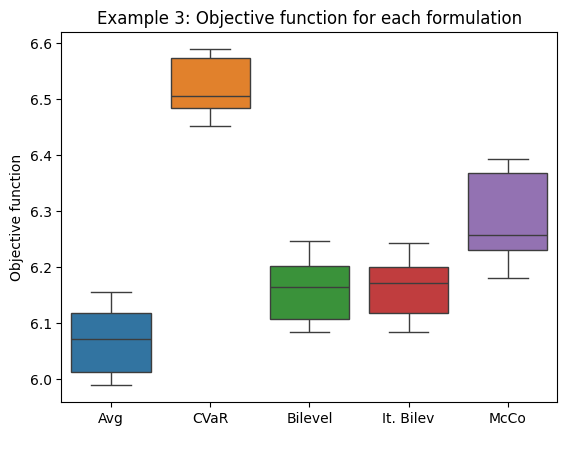

In [426]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  

# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# plot
boxplot_ex3_objective = sns.boxplot( data=df_results_example3_N1000,  x='Method',
    y='Objective_value', hue='Method', palette=custom_colors )

boxplot_ex3_objective.set_xticklabels(names)
boxplot_ex3_objective.set( xlabel = " ", ylabel='Objective function', title= "Example 3: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example3_N1000.png")
plt.show()

## Example 4, iterative Comparisons

N = 500

In [122]:
results_example4_N500 = []

In [124]:
N=500
for j in range(10):
    
    print("We are in iteration", j)
        
    # Create data simulation
    np.random.seed(10 + j)
    noise1_N = np.random.randn(N, T)  # My standard normal N(0,1) for each reservoir
    noise2_N = np.random.randn(N, T)
    inflows1_scen_N = mu1 + noise1_N @ L1.T   # mu_x + Z * L^T
    inflows2_scen_N = mu2 + noise2_N @ L2.T
	
    # Create and add restrictions for g_3b
    M=10000
    model = create_model1_4gs(M,T, N, alpha, m_matrix = upper_oper_limits, c1=c1, c2=c2, c3=c3, inflows1 = inflows1_scen_N,
                                    inflows2= inflows2_scen_N)

	#Solve it
    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    #Save the decsion variables
    X = np.empty((3,32))
    for t in model.T:
        for j in model.J:
            X[j,t] = model.x[j,t].value

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status),
        "Sol_x": X
    }
    results_example4_N500.append(result_dict)

In [125]:
N=500	
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    noise1_N = np.random.randn(N, T)  # My standard normal N(0,1) for each reservoir
    noise2_N = np.random.randn(N, T)
    inflows1_scen_N = mu1 + noise1_N @ L1.T   # mu_x + Z * L^T
    inflows2_scen_N = mu2 + noise2_N @ L2.T
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4_4gs(p = alpha,inflows1 = inflows1_scen_N, inflows2 = inflows2_scen_N, v_ini = 1, eta_ini = 0, probs = probabilities_model, N=N
                                    , m_matrix= upper_oper_limits)


    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    #Save decision variables
    X_cvar = np.empty((3,32))
    for t in model_cvar.T:
        for j in model_cvar.J:
            X_cvar[j,t] = model_cvar.x[j,t].value

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status),
        "Sol_x": X_cvar
    }
    
    #Next algorithms
    #Initialization step

            
    resultado = initialize_values_4gs(X = X_cvar, p= alpha, S=N, inflows1= inflows1_scen_N, inflows2 = inflows2_scen_N)
    x_ini_dict = {(j, t): X_cvar[j, t] for j in range(3) for t in range(32)}
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
    g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
    eta_ini = resultado["eta_ini"]

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3_4gs(p = alpha, T = 32, N = N, inflows1 =inflows1_scen_N , inflows2 =inflows2_scen_N , m_matrix = upper_oper_limits, 
                                x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict , eta_ini = eta_ini)

        
        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time
        
        #Save decision variables
        X_bilevel = np.empty((3,32))
        for t in model_bilevel.T:
            for j in model_bilevel.J:
                X_bilevel[j,t] = model_bilevel.x[j,t].value

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status),
            "Sol_x": X_bilevel
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()  #In this case the loop compute the iterations and return the last model solved
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop_4gs(max_iterations, tolerance, M=100, p= alpha, data_inflows1 = inflows1_scen_N, data_inflows2 = inflows2_scen_N, num_scen=N, modelo_ini= model_cvar)
    end_time = time.time()    

    exec_time = end_time - start_time
    
    #Save decision variables
    X_iter = np.empty((3,32))
    for t in model_bilevel.T:
        for j in model_bilevel.J:
            X_iter[j,t] = model_bilevel.x[j,t].value

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status),
        "Sol_x": X_iter
    }
    
    ############## Mc Cormick ############
    
    M = max(resultado["g_ini"])

    Dicc_N = compute_g_bounds_4gs( inflows1_scen_N, inflows2_scen_N, N, model_cvar, M)
    g_LO = Dicc_N["g_lo"]
    g_UP = Dicc_N["g_up"]

    model_mc_cormick =  create_model7_4gs(p= alpha, N= N, inflows1= inflows1_scen_N, inflows2= inflows2_scen_N, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini = v_ini_dict, eta_ini = eta_ini, pi_ini = pi_ini_dict, g_LO = g_LO, g_UP = g_UP, m_matrix = upper_oper_limits )

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    print("El eta para esta iteración", j," es", model_mc_cormick.eta.value)
    
    #Save decision variables
    X_mcco = np.empty((3,32))
    for t in model_mc_cormick.T:
        for j in model_mc_cormick.J:
            X_mcco[j,t] = model_mc_cormick.x[j,t].value
            
    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status),
        "Sol_x": X_mcco
    }
    
    results_example4_N500.append(result_dict_cvar)
    results_example4_N500.append(result_dict_bilevel)
    results_example4_N500.append(result_dict_iter_bilevel)
    results_example4_N500.append(result_dict_mc_cormick)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[330]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal Values of Variables for gf:
x[turbine 0 at time 0] = -9.55559237065567e-09
x[turbine 1 at time 0] = -9.534326872368278e-09
x[turbine 2 at time 0] = 5.994566476516004
x[turbine 0 at time 1] = -9.555592365750796e-09
x[turbine 1 at time 1] = -9.534326866982763e-09
x[turbine 2 at time 1] = 6.880439376251935
x[turbine 0 at time 2] = -9.369385704516638e-09
x[turbine 1 at time 2] = -9.301490297879136e-09
x[turbine 2 at time 2] = 12.594888748910732
x[turbine 0 at time 3] = -6.107334274780806e-09
x[turbine 1 at time 3] = 57.3625254886196
x[turbine 2 at time 3] = 77.9605572531429
x[turbine 0 at time 4] = -5.134167846851852e-09
x[turbine 1 at time 4] = 14.700046669737576
x[turbine 2 at time 4] = 26.29943198348064
x[turbine 0 at time 5] = -3.51222379

In [174]:
# Dataframe creation and save it to csv
df_results_example4_N500 = pd.DataFrame(results_example4_N500)
df_results_example4_N500.to_csv("C:/Users/laull/TFM/resultados_example4_N500.csv", index=False)
Iterations_mc_cormick_ex4 = [3,3,3,3,3,3,3,3,3,3]

We now compute the percentiles and the probability

In [175]:
rows = []

for idx, row in df_results_example4_N500.iterrows():
    method = row["Method"]
    X = row["Sol_x"]

    # Simulación correspondiente a esta solución
    np.random.seed(10 + idx)
    noise1_N = np.random.randn(N, T)  # My standard normal N(0,1) for each reservoir
    noise2_N = np.random.randn(N, T)
    inflows1_scen_N = mu1 + noise1_N @ L1.T   # mu_x + Z * L^T
    inflows2_scen_N = mu2 + noise2_N @ L2.T
	
	
    resultado = initialize_values_4gs(X = X, p= alpha, S=N, inflows1= inflows1_scen_N, inflows2 = inflows2_scen_N)
    g_vals = resultado["g_ini"]
	
    # Percentil 90 y proporción de satisfacción
    perc90 = np.percentile(g_vals, 90)
    prob_satisf_rest = np.mean(np.array(g_vals) < 0)

    rows.append({
        "method": method,
        "sol_x": f"Sol. iteracion {idx}",
        "percentil_90": perc90,
        "prob_satisf_rest": prob_satisf_rest
    })

# Convertimos a DataFrame
percentiles_example4_90 = pd.DataFrame(rows).sort_values(by="method").reset_index(drop=True)
percentiles_example4_90.to_csv("percentiles_example4_90.csv")

In [177]:
percentiles_example4_90

method              sol_x  percentil_90  prob_satisf_rest
0   Average_sample   Sol. iteracion 0  6.213128e-11             0.878
1   Average_sample   Sol. iteracion 1  8.658390e-11             0.882
2   Average_sample   Sol. iteracion 2  7.554419e-11             0.888
3   Average_sample   Sol. iteracion 3  6.450136e-10             0.888
4   Average_sample   Sol. iteracion 4  4.479261e-12             0.898
5   Average_sample   Sol. iteracion 5  1.767901e-10             0.882
6   Average_sample   Sol. iteracion 6  3.115929e-10             0.880
7   Average_sample   Sol. iteracion 7  6.851479e-11             0.892
8   Average_sample   Sol. iteracion 8  1.203716e-10             0.878
9   Average_sample   Sol. iteracion 9 -4.865797e-12             0.902
10         Bilevel  Sol. iteracion 19  5.353139e+02             0.840
11         Bilevel  Sol. iteracion 43 -7.165048e+00             0.900
12         Bilevel  Sol. iteracion 31  2.803295e+02             0.856
13         Bilevel  Sol. iteracion 15 -2.382604e+01             0.902
14         Bilevel  Sol. iteracion 11  8.472918e+01             0.882
15         Bilevel  Sol. iteracion 35 -2.685288e-01             0.900
16         Bilevel  Sol. iteracion 47  2.453157e+02             0.868
17         Bilevel  Sol. iteracion 39  1.084858e+02             0.882
18         Bilevel  Sol. iteracion 27  5.790058e+01             0.890
19         Bilevel  Sol. iteracion 23  5.384049e+02             0.806
20            CVaR  Sol. iteracion 26 -6.207200e+02             0.952
21            CVaR  Sol. iteracion 30 -8.597369e+02             0.966
22            CVaR  Sol. iteracion 38 -5.000362e+02             0.948
23            CVaR  Sol. iteracion 34 -8.697260e+02             0.962
24            CVaR  Sol. iteracion 42 -7.835062e+02             0.976
25            CVaR  Sol. iteracion 18 -7.701834e+02             0.964
26            CVaR  Sol. iteracion 14 -7.870393e+02             0.978
27            CVaR  Sol. iteracion 46 -8.325119e+02             0.942
28            CVaR  Sol. iteracion 10 -5.406475e+02             0.948
29            CVaR  Sol. iteracion 22 -4.868184e+02             0.944
30    Iter_Bilevel  Sol. iteracion 40  1.358469e+02             0.884
31    Iter_Bilevel  Sol. iteracion 36  7.318278e+00             0.896
32    Iter_Bilevel  Sol. iteracion 44  1.409684e+02             0.884
33    Iter_Bilevel  Sol. iteracion 24  3.275068e+02             0.850
34    Iter_Bilevel  Sol. iteracion 32  2.017917e+02             0.858
35    Iter_Bilevel  Sol. iteracion 28 -9.589591e-01             0.900
36    Iter_Bilevel  Sol. iteracion 48  8.025418e+01             0.878
37    Iter_Bilevel  Sol. iteracion 20  2.698354e+02             0.852
38    Iter_Bilevel  Sol. iteracion 16  3.363623e+01             0.894
39    Iter_Bilevel  Sol. iteracion 12  1.360300e+02             0.872
40      MC_cormick  Sol. iteracion 29  5.932066e+02             0.824
41      MC_cormick  Sol. iteracion 37  1.083921e+03             0.742
42      MC_cormick  Sol. iteracion 25  9.013193e+02             0.764
43      MC_cormick  Sol. iteracion 21  1.167448e+03             0.682
44      MC_cormick  Sol. iteracion 41  1.474867e+03             0.586
45      MC_cormick  Sol. iteracion 17  5.789596e+02             0.832
46      MC_cormick  Sol. iteracion 45  9.306931e+02             0.786
47      MC_cormick  Sol. iteracion 13  2.909787e+02             0.832
48      MC_cormick  Sol. iteracion 33  1.456922e+03             0.654
49      MC_cormick  Sol. iteracion 49  1.530601e+03             0.656

In [176]:
# Calcular media y mediana de prob_satisf_rest
summary_prob_ex4 = percentiles_example4_90.groupby("method")["prob_satisf_rest"].agg(
    mean_prob="mean",
    median_prob="median"
)

# Calcular min, max, media y mediana de percentil_90
summary_perc_ex4 = percentiles_example4_90.groupby("method")["percentil_90"].agg(
    min_perc="min",
    max_perc="max",
    mean_perc="mean",
    median_perc="median"
)

# Unir ambos resúmenes
df_summary_stats_ex4 = pd.concat([summary_prob_ex4, summary_perc_ex4], axis=1).reset_index()
df_summary_stats_ex4

method  mean_prob  median_prob      min_perc      max_perc  \
0  Average_sample     0.8868        0.885 -4.865797e-12  6.450136e-10   
1         Bilevel     0.8726        0.882 -2.382604e+01  5.384049e+02   
2            CVaR     0.9580        0.957 -8.697260e+02 -4.868184e+02   
3    Iter_Bilevel     0.8768        0.881 -9.589591e-01  3.275068e+02   
4      MC_cormick     0.7358        0.753  2.909787e+02  1.530601e+03   

      mean_perc   median_perc  
0  1.546156e-10  8.106404e-11  
1  1.819220e+02  9.660748e+01  
2 -7.050926e+02 -7.768448e+02  
3  1.332229e+02  1.359385e+02  
4  1.000892e+03  1.007307e+03

## Boxplot Example 4 $N=500$

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3139104059.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex4_Extime.set_xticklabels(names)


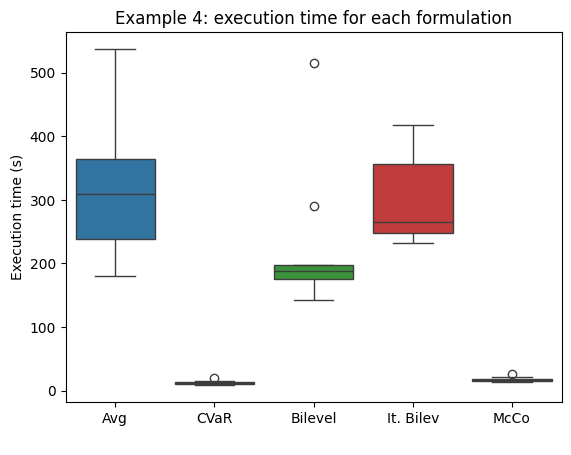

In [427]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex4_Extime = sns.boxplot(data=df_results_example4_N500, x='Method', y='Execution_time', hue= 'Method', palette=custom_colors)

boxplot_ex4_Extime.set_xticklabels(names)
boxplot_ex4_Extime.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 4: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example4_N500.png")
plt.show()


C:\Users\laull\AppData\Local\Temp\ipykernel_5664\1486003719.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex4_objective.set_xticklabels(names)


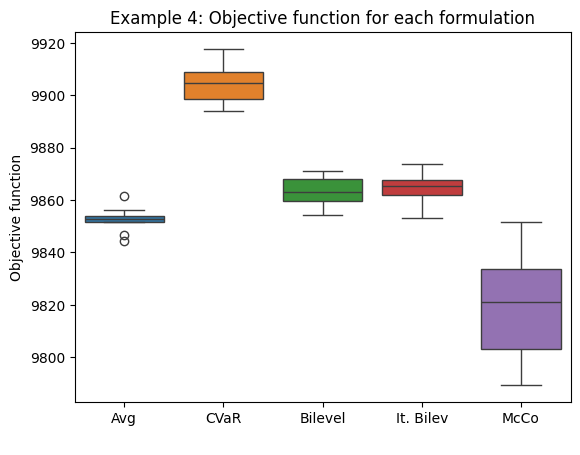

In [428]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# plot
boxplot_ex4_objective = sns.boxplot(
    data=df_results_example4_N500,
    x='Method',
    y='Objective_value',
    hue='Method',
    palette=custom_colors
)

boxplot_ex4_objective.set_xticklabels(names)
boxplot_ex4_objective.set( xlabel = " ", ylabel='Objective function', title= "Example 4: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example4_N500.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3262257031.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex1_Extime.set_xticklabels(names)


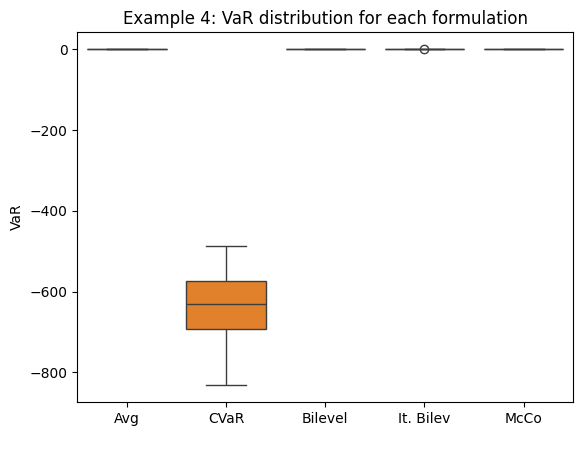

In [429]:
custom_colors = ["#1f77b4",  # dark blue 
                "#ff7f0e",  # orange
                "#2ca02c",  # green
                "#d62728",  # red
                "#9467bd"]  # purple

names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex1_Extime = sns.boxplot(data=df_results_example4_N500, x='Method', y='VaR', hue = 'Method', palette = custom_colors)

boxplot_ex1_Extime.set_xticklabels(names)
boxplot_ex1_Extime.set(xlabel=' ', ylabel='VaR', title= "Example 4: VaR distribution for each formulation")

plt.savefig("C:/Users/laull/TFM/VaRs_example4_N500.png")
plt.show()

Now with the Mc Cormick M and M/2 to compare

In [83]:
results_example4_N500_v2 = results_example4_N500

N=500	
for j in range(10):
    print("We are in iteration", j)
    
    # Simulated data 
    np.random.seed(10 + j)
    noise1_N = np.random.randn(N, T)  # My standard normal N(0,1) for each reservoir
    noise2_N = np.random.randn(N, T)
    inflows1_scen_N = mu1 + noise1_N @ L1.T   # mu_x + Z * L^T
    inflows2_scen_N = mu2 + noise2_N @ L2.T
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4_4gs(p = alpha,inflows1 = inflows1_scen_N, inflows2 = inflows2_scen_N, v_ini = 1, eta_ini = 0, probs = probabilities_model, N=N
                                    , m_matrix= upper_oper_limits)


    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status)
    }
    
    #Next algorithms
    #Initialization step
	
    X_sol = np.empty((3,32))
    for t in model_cvar.T:
        for j in model_cvar.J:
            X_sol[j,t] = model_cvar.x[j,t].value
            
    resultado = initialize_values_4gs(X = X_sol, p= alpha, S=N, inflows1= inflows1_scen_N, inflows2 = inflows2_scen_N)
    x_ini_dict = {(j, t): X_sol[j, t] for j in range(3) for t in range(32)}
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
    g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
    eta_ini = resultado["eta_ini"]

    ############## Mc Cormick ############
    
    M = max(resultado["g_ini"])

    Dicc_N = compute_g_bounds_4gs( inflows1_scen_N, inflows2_scen_N, N, model_cvar, M/2)
    g_LO = Dicc_N["g_lo"]
    g_UP = Dicc_N["g_up"]

    model_mc_cormick =  create_model7_4gs(p= alpha, N= N, inflows1= inflows1_scen_N, inflows2= inflows2_scen_N, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini = v_ini_dict, eta_ini = eta_ini, pi_ini = pi_ini_dict, g_LO = g_LO, g_UP = g_UP, m_matrix = upper_oper_limits )

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick_v2",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status)
    }
    
    results_example4_N500_v2.append(result_dict_mc_cormick)

We are in iteration 0
WARNING (W1002): Setting Var 'pi[330]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 1
WARNING (W1002): Setting Var 'pi[296]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 2
WARNING (W1002): Setting Var 'pi[72]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 3
WARNING (W1002): Setting Var 'pi[294]' to a numeric value
`-0.10000000000000853` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
We are in iteration 4
WARNING (W1002): Setting Var 'pi[422]' to a numeric value
`-0.10000000000000853` outside the bo

In [ ]:
df_results_example4_N500_v2 = pd.DataFrame(results_example4_N500_v2)
df_results_example4_N500_v2.to_csv("C:/Users/laull/TFM/resultados_example4_N500_v2.csv", index=False)

C:\Users\laull\AppData\Local\Temp\ipykernel_5740\2470965544.py:6: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  boxplot_ex4_objective = sns.boxplot(
C:\Users\laull\AppData\Local\Temp\ipykernel_5740\2470965544.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex4_objective.set_xticklabels(names)


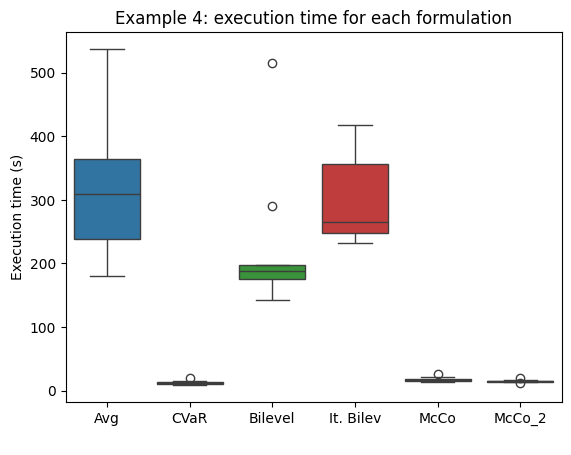

In [40]:

custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo', 'McCo_2']

# plot
boxplot_ex4_objective = sns.boxplot(
    data=df_results_example4_N500_v2,
    x='Method',
    y='Execution_time',
    hue='Method',
    palette=custom_colors
)

boxplot_ex4_objective.set_xticklabels(names)
boxplot_ex4_objective.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 4: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example4_N500_v2.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5740\3471564728.py:6: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  boxplot_ex4_objective = sns.boxplot(
C:\Users\laull\AppData\Local\Temp\ipykernel_5740\3471564728.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex4_objective.set_xticklabels(names)


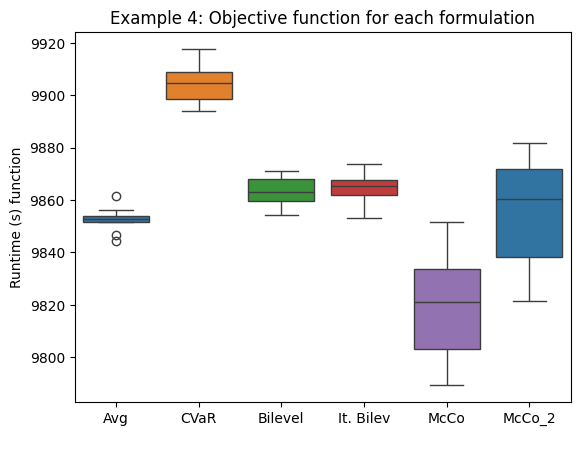

In [41]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo', 'McCo_2']

# plot
boxplot_ex4_objective = sns.boxplot(
    data=df_results_example4_N500_v2,
    x='Method',
    y='Objective_value',
    hue='Method',
    palette=custom_colors
)

boxplot_ex4_objective.set_xticklabels(names)
boxplot_ex4_objective.set( xlabel = " ", ylabel='Runtime (s) function', title= "Example 4: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example4_N500_v2.png")
plt.show()

N=1000

In [263]:
results_example4_N1000 = []

In [264]:
N=1000
for j in range(10):
        
    # Create data simulation
    np.random.seed(10 + j)
    noise1_N = np.random.randn(N, T)  # My standard normal N(0,1) for each reservoir
    noise2_N = np.random.randn(N, T)
    inflows1_scen_N = mu1 + noise1_N @ L1.T   # mu_x + Z * L^T
    inflows2_scen_N = mu2 + noise2_N @ L2.T
	
    # Create and add restrictions for g_3b
    M=10000
    model = create_model1_4gs(M,T, N, alpha, m_matrix = upper_oper_limits, c1=c1, c2=c2, c3=c3, inflows1 = inflows1_scen_N,
                                    inflows2= inflows2_scen_N)

	#Solve it
    start_time = time.time()
    result = opt.solve(model)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result in dictionary
    result_dict = {
        "Method": "Average_sample",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model.Objective) if result.solver.status == SolverStatus.ok else None,
        "VaR": model.eta.value if result.solver.status == SolverStatus.ok else None,
        "Status": str(result.solver.status)
    }
    
    probabilities_model =  [1/N]*N
    probabilities_model = np.array(probabilities_model)

    ################################################# Solve CVaR ################################################################
    model_cvar = create_model4_4gs(p = alpha,inflows1 = inflows1_scen_N, inflows2 = inflows2_scen_N, v_ini = 1, eta_ini = 0, probs = probabilities_model, N=N
                                    , m_matrix= upper_oper_limits)


    start_time = time.time()
    result_cvar = opt.solve(model_cvar)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_cvar = {
        "Method": "CVaR",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_cvar.Objective) if result_cvar.solver.status == SolverStatus.ok else None,
        "VaR": model_cvar.eta.value if result_cvar.solver.status == SolverStatus.ok else None , 
        "Status": str(result_cvar.solver.status)
    }
    
    #Next algorithms
    #Initialization step
	
    X_sol = np.empty((3,32))
    for t in model_cvar.T:
        for j in model_cvar.J:
            X_sol[j,t] = model_cvar.x[j,t].value
            
    resultado = initialize_values_4gs(X = X_sol, p= alpha, S=N, inflows1= inflows1_scen_N, inflows2 = inflows2_scen_N)
    x_ini_dict = {(j, t): X_sol[j, t] for j in range(3) for t in range(32)}
    u_ini_dict = {j: resultado["u_ini"][j] for j in range(len(resultado["u_ini"]))}  
    v_ini_dict = {j: resultado["v_ini"][j] for j in range(len(resultado["v_ini"]))}  
    pi_ini_dict = {j: resultado["pi_ini"][j] for j in range(len(resultado["pi_ini"]))}  
    g_ini_dict = {j: resultado["g_ini"][j] for j in range(len(resultado["pi_ini"]))}  
    eta_ini = resultado["eta_ini"]

    ########### Bilevel #######################
    try:
        model_bilevel = create_model3_4gs(p = alpha, T = 32, N = N, inflows1 =inflows1_scen_N , inflows2 =inflows2_scen_N , m_matrix = upper_oper_limits, 
                                x_ini = x_ini_dict, u_ini = u_ini_dict, v_ini = v_ini_dict, pi_ini = pi_ini_dict, g_ini = g_ini_dict , eta_ini = eta_ini)

        
        start_time = time.time()
        result_bilevel = opt2.solve(model_bilevel)
        end_time = time.time()

        exec_time = end_time - start_time

        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": exec_time,
            "Objective_value": value(model_bilevel.Objective) if result_bilevel.solver.status == SolverStatus.ok else None,
            "VaR": model_bilevel.eta.value if result_bilevel.solver.status == SolverStatus.ok else None,
            "Status": str(result_bilevel.solver.status)
        }

    except Exception as e:
        result_dict_bilevel = {
            "Method": "Bilevel",
            "N": N,
            "Execution_time": None,
            "Objective_value": None,
            "VaR": None,
            "Status": f"no_solved ({str(e).splitlines()[0]})"
        }

    
    ###################### Iterative bilevel ################
    
    start_time = time.time()  #In this case the loop compute the iterations and return the last model solved
    model_iter_bilevel, result_iter_bilevel = bilevel_iteration_loop_4gs(max_iterations, tolerance, M=100, p= alpha, data_inflows1 = inflows1_scen_N, data_inflows2 = inflows2_scen_N, num_scen=N, modelo_ini= model_cvar)
    end_time = time.time()    

    exec_time = end_time - start_time

    # Save result
    result_dict_iter_bilevel = {
        "Method": "Iter_Bilevel",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_iter_bilevel.Objective) if result_iter_bilevel.solver.status == SolverStatus.ok else None,
        "VaR": model_iter_bilevel.eta.value if result_iter_bilevel.solver.status == SolverStatus.ok else None , 
        "Status": str(result_iter_bilevel.solver.status)
    }
    
    ############## Mc Cormick ############
    
    M = max(resultado["g_ini"])

    Dicc_N = compute_g_bounds_4gs( inflows1_scen_N, inflows2_scen_N, N, model_cvar, M)
    g_LO = Dicc_N["g_lo"]
    g_UP = Dicc_N["g_up"]

    model_mc_cormick =  create_model7_4gs(p= alpha, N= N, inflows1= inflows1_scen_N, inflows2= inflows2_scen_N, x_ini = x_ini_dict, u_ini= u_ini_dict, v_ini = v_ini_dict, eta_ini = eta_ini, pi_ini = pi_ini_dict, g_LO = g_LO, g_UP = g_UP, m_matrix = upper_oper_limits )

    start_time = time.time()
    result_mc_cormick = opt.solve(model_mc_cormick)
    end_time = time.time()

    exec_time = end_time - start_time

    # Save result
    result_dict_mc_cormick = {
        "Method": "MC_cormick",
        "N": N,
        "Execution_time": exec_time,
        "Objective_value": value(model_mc_cormick.Objective) if result_mc_cormick.solver.status == SolverStatus.ok else None,
        "VaR": model_mc_cormick.eta.value if result_mc_cormick.solver.status == SolverStatus.ok else None , 
        "Status": str(result_mc_cormick.solver.status)
    }
    
    results_example4_N1000.append(result_dict)
    results_example4_N1000.append(result_dict_cvar)
    results_example4_N1000.append(result_dict_bilevel)
    results_example4_N1000.append(result_dict_iter_bilevel)
    results_example4_N1000.append(result_dict_mc_cormick)

WARNING (W1002): Setting Var 'pi[541]' to a numeric value
`-0.10000000000002274` outside the bounds (-0.09999999999999998, 0.9).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Iteration 1 with k = 0
Optimal Values of Variables for gf:
x[turbine 0 at time 0] = -9.555592377836864e-09
x[turbine 1 at time 0] = -9.53432688025908e-09
x[turbine 2 at time 0] = 6.014227090890024
x[turbine 0 at time 1] = -9.555592367986953e-09
x[turbine 1 at time 1] = -9.534326869442181e-09
x[turbine 2 at time 1] = 6.79390786564797
x[turbine 0 at time 2] = -9.369385705448301e-09
x[turbine 1 at time 2] = -9.301490299033854e-09
x[turbine 2 at time 2] = 12.254569641021755
x[turbine 0 at time 3] = -6.107334274898875e-09
x[turbine 1 at time 3] = 56.888773939081624
x[turbine 2 at time 3] = 78.20960116352022
x[turbine 0 at time 4] = -5.1341678468914e-09
x[turbine 1 at time 4] = 14.374039565879833
x[turbine 2 at time 4] = 26.189440716685056
x[turbine 0 at time 5] = -3.5122237964635866e-09
x[turbin

In [265]:
df_results_example4_N1000 = pd.DataFrame(results_example4_N1000)
df_results_example4_N1000.to_csv("C:/Users/laull/TFM/resultados_example4_N1000.csv", index=False)

We compute the percentiles 90 of the solution and then the probability of the restriction being satisfied

In [ ]:
N=500
rows = []

methods = df_results_example3_N500["Method"].unique()

for method in methods:
    df_method = df_results_example3_N500[df_results_example3_N500["Method"] == method]
    
    g_all = []

    for j in range(10):  # 10 simulaciones con diferentes semillas
        # Simulated data
        np.random.seed(10 + j)
        sim_data =  np.column_stack((
        np.random.uniform(1, 4, N),  # First column between 1 and 4
        np.random.uniform(1/3, 1, N)  # Second column between 1/3 and 1
        ))

        for _, row in df_method.iterrows():
            x1_ini, x2_ini = row["Sol_x"]
            g_vals = [g_3max(x1_ini, x2_ini, sim_data[j,:]) for j in range(sim_data.shape[0])]
            g_all.extend(g_vals)

    # Ahora que tenemos todos los g(x1, x2, ξ) para este método:
    perc90 = np.percentile(g_all, 90)
    prob_satisf_rest = np.mean(np.array(g_all) < 0)

    rows.append({
        "method": method,
        "percentil_90": perc90,
        "prob_satisf_rest": prob_satisf_rest
    })

# Convertir a DataFrame final (una fila por método)
df_summary_example3 = pd.DataFrame(rows).sort_values(by="method").reset_index(drop=True)
df_summary_example3

## Boxplots Example 4 N=1000

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\3009466216.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex4_Extime.set_xticklabels(names)


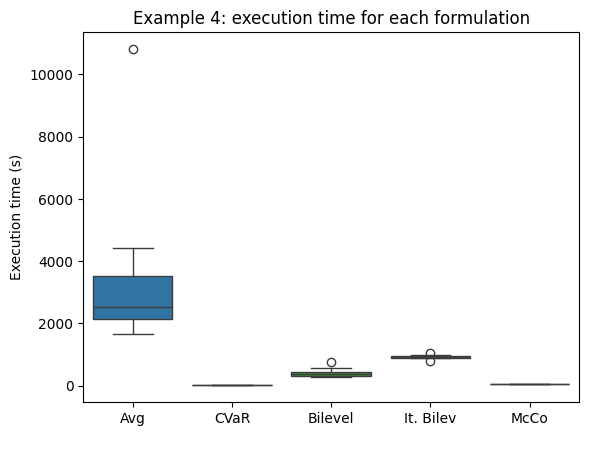

In [432]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

#Plot
boxplot_ex4_Extime = sns.boxplot(data=df_results_example4_N1000, x='Method', y='Execution_time', hue= 'Method', palette=custom_colors)

boxplot_ex4_Extime.set_xticklabels(names)
boxplot_ex4_Extime.set( xlabel = " " , ylabel='Execution time (s)', title= "Example 4: execution time for each formulation")

plt.savefig("C:/Users/laull/TFM/Extime_example4_N1000.png")
plt.show()

C:\Users\laull\AppData\Local\Temp\ipykernel_5664\2674188741.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot_ex4_objective.set_xticklabels(names)


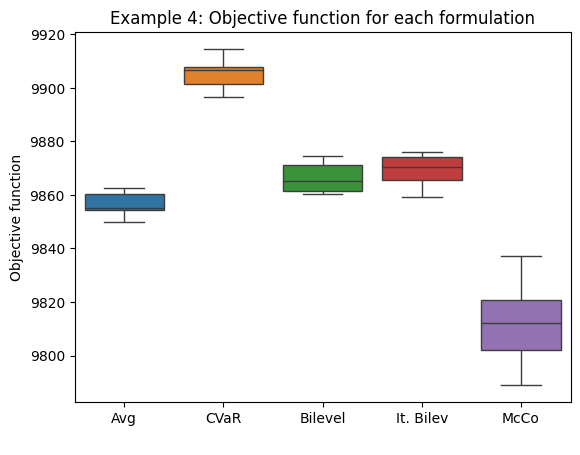

In [433]:
custom_colors = ["#1f77b4",  "#ff7f0e",  "#2ca02c",  "#d62728",  "#9467bd"]  
# Names
names = ['Avg', 'CVaR', 'Bilevel',  'It. Bilev', 'McCo']

# plot
boxplot_ex4_objective = sns.boxplot(
    data=df_results_example4_N1000,
    x='Method',
    y='Objective_value',
    hue='Method',
    palette=custom_colors
)

boxplot_ex4_objective.set_xticklabels(names)
boxplot_ex4_objective.set( xlabel = " ", ylabel='Objective function', title= "Example 4: Objective function for each formulation")

plt.savefig("C:/Users/laull/TFM/Objective_example4_N1000.png")
plt.show()

**Iterations for Mc Cormick**

In [225]:
iterations_dict = {'Ex1': Iterations_mc_cormick_ex1,
                'Ex2': Iterations_mc_cormick_ex2,
                'Ex3': Iterations_mc_cormick_ex3,
                'Ex4': Iterations_mc_cormick_ex4}

iterations_df = pd.DataFrame(iterations_dict)
iterations_df.head()


summary_iterations = pd.DataFrame ({
    'min': iterations_df.min(),
    'mean': iterations_df.mean(),
    'mode': iterations_df.mode().iloc[0],
    'max': iterations_df.max()
})
print(summary_iterations)

     min  mean  mode  max
Ex1    2   2.3     2    4
Ex2    2   3.4     3    6
Ex3    2   2.0     2    2
Ex4    3   3.0     3    3
